# fine tune version make more stable between different training and evaluation of your models more stable.

# teacher model

Starting teacher training (min_count >= 10) with early stopping and LR scheduling...
[Teacher] Epoch 1/100 | Loss: 3.5457 | Train Acc: 20.72% | Test Acc: 6.17%
[Teacher] Epoch 2/100 | Loss: 2.1779 | Train Acc: 17.06% | Test Acc: 12.35%
[Teacher] Epoch 3/100 | Loss: 1.1773 | Train Acc: 39.33% | Test Acc: 17.28%
[Teacher] Epoch 4/100 | Loss: 0.6039 | Train Acc: 70.41% | Test Acc: 34.57%
[Teacher] Epoch 5/100 | Loss: 0.2721 | Train Acc: 67.87% | Test Acc: 34.57%
[Teacher] Epoch 6/100 | Loss: 0.1364 | Train Acc: 79.09% | Test Acc: 45.68%
[Teacher] Epoch 7/100 | Loss: 0.0609 | Train Acc: 34.99% | Test Acc: 13.58%
[Teacher] Epoch 8/100 | Loss: 0.0266 | Train Acc: 70.29% | Test Acc: 33.33%
[Teacher] Epoch 9/100 | Loss: 0.0143 | Train Acc: 99.57% | Test Acc: 79.01%
[Teacher] Epoch 10/100 | Loss: 0.0077 | Train Acc: 97.58% | Test Acc: 69.14%
[Teacher] Epoch 11/100 | Loss: 0.0049 | Train Acc: 99.26% | Test Acc: 70.37%
[Teacher] Epoch 12/100 | Loss: 0.0027 | Train Acc: 83.87% | Test Acc: 53.09%
[

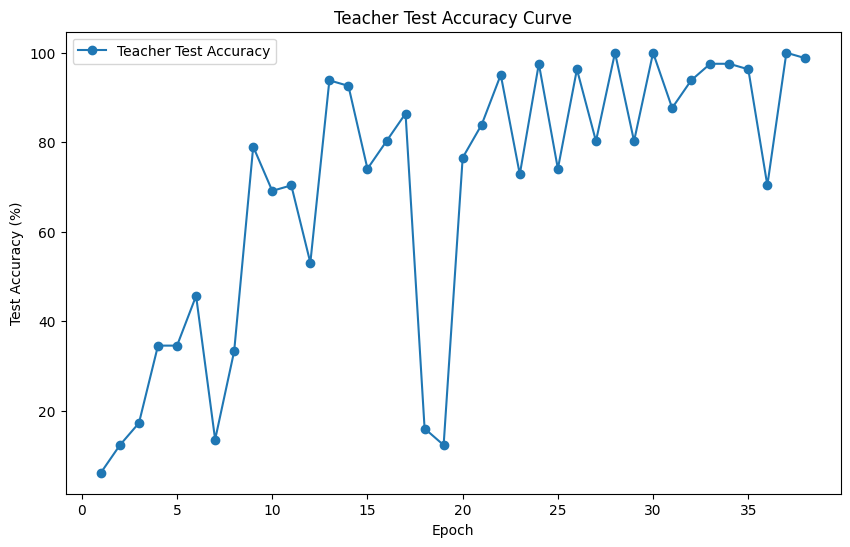

In [ ]:
import math
import random
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from Bio import SeqIO
import matplotlib.pyplot as plt

# Set device
device = (
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

###################################
# 1. Data Preparation Functions
###################################

def parse_fasta_with_labels(fasta_file):
    data = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        header = record.description.strip()
        sequence = str(record.seq).upper()
        label = header.split()[0]
        data.append((label, sequence))
    return data

def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, seq in raw_data:
        label_to_samples[label].append(seq)
    train_data = []
    test_data = []
    for label, seqs in label_to_samples.items():
        random.shuffle(seqs)
        test_seq = seqs[0]
        train_seqs = seqs[1:]
        test_data.append((label, test_seq))
        for s in train_seqs:
            train_data.append((label, s))
    return train_data, test_data

def generate_kmers(sequence, k=6):
    kmers = []
    for i in range(len(sequence) - k + 1):
        kmers.append(sequence[i:i+k])
    return kmers

def build_kmer_vocab(dataset, k=6):
    kmer_set = set()
    for _, seq in dataset:
        kmers = generate_kmers(seq, k)
        kmer_set.update(kmers)
    vocab = {"<UNK>": 0}
    for i, kmer in enumerate(sorted(kmer_set), start=1):
        vocab[kmer] = i
    return vocab

def encode_sequence(sequence, vocab, k=6):
    kmers = generate_kmers(sequence, k)
    encoded = [vocab.get(kmer, vocab["<UNK>"]) for kmer in kmers]
    return encoded

def filter_classes(raw_data, min_count=5):
    label_counts = Counter([label for (label, _) in raw_data])
    filtered_data = [(label, seq) for (label, seq) in raw_data if label_counts[label] >= min_count]
    return filtered_data

def reverse_complement(seq):
    # For simplicity, we just reverse the sequence.
    return seq[::-1]

def create_paired_data(data_list):
    paired = []
    for label, seq in data_list:
        rev_seq = reverse_complement(seq)
        paired.append((label, seq, rev_seq))
    return paired

class TwoFastaKmerDataset(Dataset):
    """
    Each item: (encoded_seq_fwd, encoded_seq_rev, label_idx)
    """
    def __init__(self, paired_data, vocab, k=6):
        super().__init__()
        self.vocab = vocab
        self.k = k
        labels = sorted(set(item[0] for item in paired_data))
        self.label2idx = {lbl: i for i, lbl in enumerate(labels)}
        self.encoded_data = []
        for label, fwd_seq, rev_seq in paired_data:
            x1 = encode_sequence(fwd_seq, self.vocab, k=self.k)
            x2 = encode_sequence(rev_seq, self.vocab, k=self.k)
            y = self.label2idx[label]
            self.encoded_data.append((x1, x2, y))
    
    def __len__(self):
        return len(self.encoded_data)
    
    def __getitem__(self, idx):
        return self.encoded_data[idx]
    
    def get_vocab_size(self):
        return len(self.vocab)
    
    def get_num_classes(self):
        return len(self.label2idx)

def collate_fn_two(batch):
    seqs_fwd, seqs_rev, labels = zip(*batch)
    seqs_fwd_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_fwd]
    seqs_rev_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_rev]
    padded_fwd = pad_sequence(seqs_fwd_tensors, batch_first=True, padding_value=0)
    padded_rev = pad_sequence(seqs_rev_tensors, batch_first=True, padding_value=0)
    labels_tensors = torch.tensor(labels, dtype=torch.long)
    return padded_fwd, padded_rev, labels_tensors

###################################
# 2. Model Architecture
###################################

class ViTDeepSEAEncoder(nn.Module):
    """
    k-mer embedding, DeepSEA-style conv block, projection,
    positional embedding, Transformer encoding, and mean pooling.
    """
    def __init__(
        self,
        vocab_size,
        embed_dim=128,
        d_model=256,
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.2,
        max_seq_len=1000
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.deepsea_conv = nn.Sequential(
            nn.Conv1d(in_channels=embed_dim, out_channels=num_conv_filters[0], kernel_size=conv_kernel_sizes[0]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[0]),
            nn.Conv1d(in_channels=num_conv_filters[0], out_channels=num_conv_filters[1], kernel_size=conv_kernel_sizes[1]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[1]),
            nn.Conv1d(in_channels=num_conv_filters[1], out_channels=num_conv_filters[2], kernel_size=conv_kernel_sizes[2]),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.bn = nn.BatchNorm1d(num_conv_filters[2])
        self.proj = nn.Linear(num_conv_filters[2], d_model)
        self.max_tokens = 150
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.max_tokens, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
        self.final_norm = nn.LayerNorm(d_model)
        
    def forward(self, x):
        x = self.embedding(x)            # [B, seq_len, embed_dim]
        x = x.transpose(1, 2)            # [B, embed_dim, seq_len]
        x = self.deepsea_conv(x)         # [B, num_conv_filters[-1], L_out]
        x = self.bn(x)
        x = x.transpose(1, 2)            # [B, L_out, num_conv_filters[-1]]
        x = self.proj(x)                 # [B, L_out, d_model]
        B, L, _ = x.size()
        pos_embed = self.pos_embedding[:, :L, :]
        x = x + pos_embed
        x = self.transformer_encoder(x)
        x = self.final_norm(x)
        x = x.mean(dim=1)
        return x

class TwoViTDeepSEAFusionDNAClassifierWithFC(nn.Module):
    """
    Two-branch model: processes forward and reverse sequences,
    concatenates features, and applies a fully-connected layer.
    """
    def __init__(
        self,
        vocab_size,
        num_classes,
        embed_dim=128,
        d_model=256,
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.2,
        max_seq_len=1000
    ):
        super().__init__()
        self.vit_branch1 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        self.vit_branch2 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        self.fc = nn.Linear(2 * d_model, num_classes)
    
    def forward(self, x1, x2):
        f1 = self.vit_branch1(x1)
        f2 = self.vit_branch2(x2)
        fused = torch.cat([f1, f2], dim=1)
        logits = self.fc(fused)
        return logits

###################################
# 3. Build Vocabulary and Dataset
###################################
fasta_file = "data2/fungi_ITS_cleaned.fasta"
raw_data = parse_fasta_with_labels(fasta_file)
vocab = build_kmer_vocab(raw_data, k=6)

###################################
# Teacher Training (min_count >= 10)
###################################
teacher_data = filter_classes(raw_data, min_count=10)
teacher_train_data, teacher_test_data = create_train_test_split(teacher_data)
teacher_paired_train = create_paired_data(teacher_train_data)
teacher_paired_test = create_paired_data(teacher_test_data)
teacher_dataset = TwoFastaKmerDataset(teacher_paired_train, vocab, k=6)
teacher_test_dataset = TwoFastaKmerDataset(teacher_paired_test, vocab, k=6)

teacher_train_loader = DataLoader(teacher_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
teacher_test_loader = DataLoader(teacher_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_teacher = teacher_dataset.get_num_classes()
vocab_size = teacher_dataset.get_vocab_size()

teacher_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_teacher,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer_teacher = optim.AdamW(teacher_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler_teacher = optim.lr_scheduler.ReduceLROnPlateau(optimizer_teacher, mode='max', factor=0.5, patience=5, verbose=True)

teacher_epochs = 100
best_teacher_acc = 0.0
best_teacher_state = None
patience = 10
patience_counter = 0

# For plotting
teacher_train_acc_list = []
teacher_test_acc_list = []

print("Starting teacher training (min_count >= 10) with early stopping and LR scheduling...")
for epoch in range(1, teacher_epochs + 1):
    teacher_model.train()
    total_loss = 0.0
    for fwd, rev, labels in teacher_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_teacher.zero_grad()
        logits = teacher_model(fwd, rev)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(teacher_model.parameters(), max_norm=1.0)
        optimizer_teacher.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(teacher_train_loader)
    
    # Evaluate training accuracy
    teacher_model.eval()
    train_correct = 0
    train_total = 0
    with torch.no_grad():
        for fwd, rev, labels in teacher_train_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(teacher_model(fwd, rev), dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)
    train_acc = 100.0 * train_correct / train_total
    teacher_train_acc_list.append(train_acc)
    
    # Evaluate test accuracy
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for fwd, rev, labels in teacher_test_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(teacher_model(fwd, rev), dim=1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)
    teacher_test_acc = 100.0 * test_correct / test_total
    teacher_test_acc_list.append(teacher_test_acc)
    
    scheduler_teacher.step(teacher_test_acc)
    
    print(f"[Teacher] Epoch {epoch}/{teacher_epochs} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {teacher_test_acc:.2f}%")
    
    if teacher_test_acc > best_teacher_acc:
        best_teacher_acc = teacher_test_acc
        best_teacher_state = teacher_model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch}.")
        break

teacher_model.load_state_dict(best_teacher_state)
for param in teacher_model.parameters():
    param.requires_grad = False
teacher_model.eval()
print(f"Best Teacher Accuracy: {best_teacher_acc:.2f}%")

###################################
# Plotting Test Accuracy Curves
###################################
plt.figure(figsize=(10,6))
plt.plot(range(1, len(teacher_test_acc_list)+1), teacher_test_acc_list, label="Teacher Test Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Teacher Test Accuracy Curve")
plt.legend()
plt.show()

# new improvement

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting teacher training (min_count >= 10) with early stopping and LR scheduling...


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[Teacher] Epoch 1/100 | Loss: 3.6162 | Train Acc: 11.97% | Test Acc: 3.70%
[Teacher] Epoch 2/100 | Loss: 2.1898 | Train Acc: 11.35% | Test Acc: 3.70%
[Teacher] Epoch 3/100 | Loss: 1.2714 | Train Acc: 33.56% | Test Acc: 13.58%
[Teacher] Epoch 4/100 | Loss: 0.6742 | Train Acc: 37.28% | Test Acc: 14.81%
[Teacher] Epoch 5/100 | Loss: 0.3341 | Train Acc: 28.85% | Test Acc: 23.46%
[Teacher] Epoch 6/100 | Loss: 0.1559 | Train Acc: 55.65% | Test Acc: 27.16%
[Teacher] Epoch 7/100 | Loss: 0.0700 | Train Acc: 25.93% | Test Acc: 7.41%
[Teacher] Epoch 8/100 | Loss: 0.0324 | Train Acc: 65.57% | Test Acc: 25.93%
[Teacher] Epoch 9/100 | Loss: 0.0148 | Train Acc: 74.13% | Test Acc: 43.21%
[Teacher] Epoch 10/100 | Loss: 0.0079 | Train Acc: 99.63% | Test Acc: 74.07%
[Teacher] Epoch 11/100 | Loss: 0.0055 | Train Acc: 100.00% | Test Acc: 90.12%
[Teacher] Epoch 12/100 | Loss: 0.0047 | Train Acc: 100.00% | Test Acc: 91.36%
[Teacher] Epoch 13/100 | Loss: 0.0044 | Train Acc: 100.00% | Test Acc: 90.12%
[Teacher

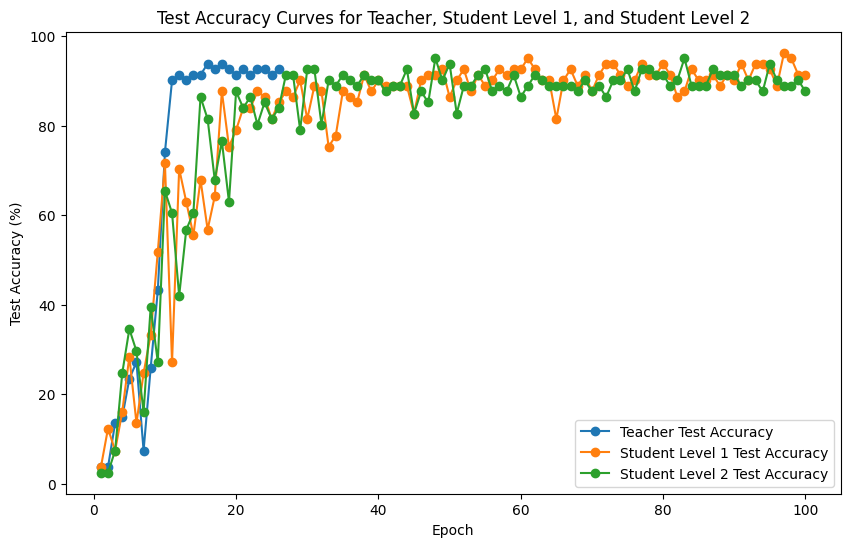

In [1]:
import math
import random
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # For KL divergence in distillation
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from Bio import SeqIO
import matplotlib.pyplot as plt  # For plotting

# Set device
device = (
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

###################################
# 1. Data Preparation Functions
###################################

def parse_fasta_with_labels(fasta_file):
    data = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        header = record.description.strip()
        sequence = str(record.seq).upper()
        label = header.split()[0]
        data.append((label, sequence))
    return data

def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, seq in raw_data:
        label_to_samples[label].append(seq)
    train_data = []
    test_data = []
    for label, seqs in label_to_samples.items():
        random.shuffle(seqs)
        test_seq = seqs[0]
        train_seqs = seqs[1:]
        test_data.append((label, test_seq))
        for s in train_seqs:
            train_data.append((label, s))
    return train_data, test_data

def generate_kmers(sequence, k=6):
    kmers = []
    for i in range(len(sequence) - k + 1):
        kmers.append(sequence[i:i+k])
    return kmers

def build_kmer_vocab(dataset, k=6):
    kmer_set = set()
    for _, seq in dataset:
        kmers = generate_kmers(seq, k)
        kmer_set.update(kmers)
    vocab = {"<UNK>": 0}
    for i, kmer in enumerate(sorted(kmer_set), start=1):
        vocab[kmer] = i
    return vocab

def encode_sequence(sequence, vocab, k=6):
    kmers = generate_kmers(sequence, k)
    encoded = [vocab.get(kmer, vocab["<UNK>"]) for kmer in kmers]
    return encoded

def filter_classes(raw_data, min_count=5):
    label_counts = Counter([label for (label, _) in raw_data])
    filtered_data = [(label, seq) for (label, seq) in raw_data if label_counts[label] >= min_count]
    return filtered_data

def reverse_complement(seq):
    # For simplicity, we just reverse the sequence.
    return seq[::-1]


# new added augmentation
def augment_sequence(seq, mutation_prob=0.1):
    nucleotides = ['A', 'C', 'G', 'T']
    return ''.join(
        ch if random.random() > mutation_prob else random.choice(nucleotides)
        for ch in seq
    )

def create_paired_data(data_list, augment=False):
    paired = []
    for label, seq in data_list:
        if augment:
            seq = augment_sequence(seq)
        rev_seq = reverse_complement(seq)
        paired.append((label, seq, rev_seq))
    return paired

class TwoFastaKmerDataset(Dataset):
    """
    Each item: (encoded_seq_fwd, encoded_seq_rev, label_idx)
    """
    def __init__(self, paired_data, vocab, k=6):
        super().__init__()
        self.vocab = vocab
        self.k = k
        labels = sorted(set(item[0] for item in paired_data))
        self.label2idx = {lbl: i for i, lbl in enumerate(labels)}
        self.encoded_data = []
        for label, fwd_seq, rev_seq in paired_data:
            x1 = encode_sequence(fwd_seq, self.vocab, k=self.k)
            x2 = encode_sequence(rev_seq, self.vocab, k=self.k)
            y = self.label2idx[label]
            self.encoded_data.append((x1, x2, y))
    
    def __len__(self):
        return len(self.encoded_data)
    
    def __getitem__(self, idx):
        return self.encoded_data[idx]
    
    def get_vocab_size(self):
        return len(self.vocab)
    
    def get_num_classes(self):
        return len(self.label2idx)

def collate_fn_two(batch):
    seqs_fwd, seqs_rev, labels = zip(*batch)
    seqs_fwd_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_fwd]
    seqs_rev_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_rev]
    padded_fwd = pad_sequence(seqs_fwd_tensors, batch_first=True, padding_value=0)
    padded_rev = pad_sequence(seqs_rev_tensors, batch_first=True, padding_value=0)
    labels_tensors = torch.tensor(labels, dtype=torch.long)
    return padded_fwd, padded_rev, labels_tensors

###################################
# 2. Model Architecture
###################################

class ViTDeepSEAEncoder(nn.Module):
    """
    This module performs:
      1. k-mer embedding.
      2. A DeepSEA-style convolutional block.
      3. Batch normalization on the conv output.
      4. A linear projection to d_model.
      5. Addition of positional embeddings.
      6. Transformer encoding over the tokens.
      7. An extra LayerNorm (final normalization) followed by mean pooling.
    """
    def __init__(
        self,
        vocab_size,
        embed_dim=128,
        d_model=256,  # Output feature dimension
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.2, 
        max_seq_len=1000
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.deepsea_conv = nn.Sequential(
            nn.Conv1d(in_channels=embed_dim, out_channels=num_conv_filters[0], kernel_size=conv_kernel_sizes[0]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[0]),
            nn.Conv1d(in_channels=num_conv_filters[0], out_channels=num_conv_filters[1], kernel_size=conv_kernel_sizes[1]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[1]),
            nn.Conv1d(in_channels=num_conv_filters[1], out_channels=num_conv_filters[2], kernel_size=conv_kernel_sizes[2]),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.bn = nn.BatchNorm1d(num_conv_filters[2])
        self.proj = nn.Linear(num_conv_filters[2], d_model)
        self.max_tokens = 150  
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.max_tokens, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
        self.final_norm = nn.LayerNorm(d_model)  # Additional normalization
        
    def forward(self, x):
        # x: [B, seq_len]
        x = self.embedding(x)            # [B, seq_len, embed_dim]
        x = x.transpose(1, 2)            # [B, embed_dim, seq_len]
        x = self.deepsea_conv(x)         # [B, num_conv_filters[-1], L_out]
        x = self.bn(x)                   # Batch normalization
        x = x.transpose(1, 2)            # [B, L_out, num_conv_filters[-1]]
        x = self.proj(x)                 # [B, L_out, d_model]
        B, L, _ = x.size()
        pos_embed = self.pos_embedding[:, :L, :]
        x = x + pos_embed
        x = self.transformer_encoder(x)  # [B, L, d_model]
        x = self.final_norm(x)           # Final LayerNorm on transformer output
        x = x.mean(dim=1)                # [B, d_model]
        return x

class TwoViTDeepSEAFusionDNAClassifierWithFC(nn.Module):
    """
    Two-branch model: each branch processes one sequence (forward and reverse).
    Their outputs (each d_model-dimensional) are concatenated and fed to a fully-connected layer.
    """
    def __init__(
        self,
        vocab_size,
        num_classes,
        embed_dim=128,
        d_model=256,
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.2,  
        max_seq_len=1000
    ):
        super().__init__()
        self.vit_branch1 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        self.vit_branch2 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        self.fc = nn.Linear(2 * d_model, num_classes)
    
    def forward(self, x1, x2):
        f1 = self.vit_branch1(x1)  # [B, d_model]
        f2 = self.vit_branch2(x2)  # [B, d_model]
        fused = torch.cat([f1, f2], dim=1)  # [B, 2*d_model]
        logits = self.fc(fused)             # [B, num_classes]
        return logits

###################################
# 3. Build Vocabulary from the Entire Dataset
###################################
fasta_file = "data2/fungi_ITS_cleaned.fasta"
raw_data = parse_fasta_with_labels(fasta_file)
vocab = build_kmer_vocab(raw_data, k=6)

###################################
# Stage 1: Teacher Training (for genera with >=10 samples)
###################################
teacher_data = filter_classes(raw_data, min_count=10)
teacher_train_data, teacher_test_data = create_train_test_split(teacher_data)
teacher_paired_train = create_paired_data(teacher_train_data)
teacher_paired_test = create_paired_data(teacher_test_data)
teacher_dataset = TwoFastaKmerDataset(teacher_paired_train, vocab, k=6)
teacher_test_dataset = TwoFastaKmerDataset(teacher_paired_test, vocab, k=6)

teacher_train_loader = DataLoader(teacher_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn_two)
teacher_test_loader = DataLoader(teacher_test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn_two)

num_classes_teacher = teacher_dataset.get_num_classes()
vocab_size = teacher_dataset.get_vocab_size()

teacher_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_teacher,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320, 480, 960),
    conv_kernel_sizes=(8, 8, 8),
    pool_kernel_sizes=(4, 4),
    num_transformer_layers=4,  # 2->4
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)


teacher_epochs = 100

optimizer_teacher = optim.AdamW(teacher_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler_teacher = optim.lr_scheduler.CosineAnnealingLR(optimizer_teacher, T_max=teacher_epochs)


best_teacher_acc = 0.0
best_teacher_state = None
patience = 10
patience_counter = 0

# For plotting
teacher_train_acc_list = []
teacher_test_acc_list = []

print("Starting teacher training (min_count >= 10) with early stopping and LR scheduling...")
for epoch in range(1, teacher_epochs + 1):
    teacher_model.train()
    total_loss = 0.0
    for fwd, rev, labels in teacher_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_teacher.zero_grad()
        logits = teacher_model(fwd, rev)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(teacher_model.parameters(), max_norm=1.0)
        optimizer_teacher.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(teacher_train_loader)
    
    # Evaluate training accuracy
    teacher_model.eval()
    train_correct = 0
    train_total = 0
    with torch.no_grad():
        for fwd, rev, labels in teacher_train_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(teacher_model(fwd, rev), dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)
    train_acc = 100.0 * train_correct / train_total
    teacher_train_acc_list.append(train_acc)
    
    # Evaluate test accuracy
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for fwd, rev, labels in teacher_test_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(teacher_model(fwd, rev), dim=1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)
    teacher_test_acc = 100.0 * test_correct / test_total
    teacher_test_acc_list.append(teacher_test_acc)
    
    scheduler_teacher.step(teacher_test_acc)
    
    print(f"[Teacher] Epoch {epoch}/{teacher_epochs} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {teacher_test_acc:.2f}%")
    
    if teacher_test_acc > best_teacher_acc:
        best_teacher_acc = teacher_test_acc
        best_teacher_state = teacher_model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch}.")
        break

teacher_model.load_state_dict(best_teacher_state)
for param in teacher_model.parameters():
    param.requires_grad = False
teacher_model.eval()
print(f"Best Teacher Accuracy: {best_teacher_acc:.2f}%")

###################################
# Stage 2: Student Level 1 Training with Distillation (min_count >= 8)
###################################
# Filter student data: classes with >=8 samples and restrict to teacher classes.
student8_data = filter_classes(raw_data, min_count=8)
teacher_class_set = set(teacher_dataset.label2idx.keys())
student8_data = [(label, seq) for (label, seq) in student8_data if label in teacher_class_set]

student8_train_data, student8_test_data = create_train_test_split(student8_data)
student8_paired_train = create_paired_data(student8_train_data)
student8_paired_test = create_paired_data(student8_test_data)
student8_dataset = TwoFastaKmerDataset(student8_paired_train, vocab, k=6)
student8_test_dataset = TwoFastaKmerDataset(student8_paired_test, vocab, k=6)

student8_train_loader = DataLoader(student8_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
student8_test_loader = DataLoader(student8_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_student8 = student8_dataset.get_num_classes()

student8_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student8,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer_student8 = optim.AdamW(student8_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Distillation hyperparameters
temperature = 4.0
alpha = 0.5

def distillation_loss(student_logits, teacher_logits, T):
    return F.kl_div(F.log_softmax(student_logits / T, dim=1),
                    F.softmax(teacher_logits / T, dim=1),
                    reduction="batchmean") * (T * T)

student8_epochs = 100
best_student8_acc = 0.0
best_student8_epoch = 0
student8_train_acc_list = []
student8_test_acc_list = []

print("\nStarting Student Level 1 training (min_count >= 8) with distillation from Teacher...")
for epoch in range(1, student8_epochs + 1):
    student8_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student8_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student8.zero_grad()
        student_logits = student8_model(fwd, rev)
        with torch.no_grad():
            teacher_logits = teacher_model(fwd, rev)
        ce_loss = criterion(student_logits, labels)
        kd_loss = distillation_loss(student_logits, teacher_logits, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student8_model.parameters(), max_norm=1.0)
        optimizer_student8.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student8_train_loader)
    
    # Evaluate train accuracy for Student Level 1
    student8_model.eval()
    train_correct = 0
    train_total = 0
    with torch.no_grad():
        for fwd, rev, labels in student8_train_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(student8_model(fwd, rev), dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)
    student8_train_acc = 100.0 * train_correct / train_total
    student8_train_acc_list.append(student8_train_acc)
    
    # Evaluate test accuracy for Student Level 1
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for fwd, rev, labels in student8_test_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(student8_model(fwd, rev), dim=1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)
    student8_test_acc = 100.0 * test_correct / test_total
    student8_test_acc_list.append(student8_test_acc)
    
    if student8_test_acc > best_student8_acc:
        best_student8_acc = student8_test_acc
        best_student8_epoch = epoch
        best_student8_state = student8_model.state_dict()
    
    print(f"[Student Level 1] Epoch {epoch}/{student8_epochs} | Loss: {avg_loss:.4f} | Train Acc: {student8_train_acc:.2f}% | Test Acc: {student8_test_acc:.2f}%")

print(f"\nHighest Student Level 1 Test Accuracy: {best_student8_acc:.2f}% at Epoch {best_student8_epoch}")
student8_model.load_state_dict(best_student8_state)
for param in student8_model.parameters():
    param.requires_grad = False
student8_model.eval()

###################################
# Stage 3: Student Level 2 Training with Distillation (min_count >= 5)
###################################
# Filter student data: classes with >=5 samples and restrict to classes present in Student Level 1.
student5_data = filter_classes(raw_data, min_count=5)
student5_data = [(label, seq) for (label, seq) in student5_data if label in set(student8_dataset.label2idx.keys())]

student5_train_data, student5_test_data = create_train_test_split(student5_data)
student5_paired_train = create_paired_data(student5_train_data)
student5_paired_test = create_paired_data(student5_test_data)
student5_dataset = TwoFastaKmerDataset(student5_paired_train, vocab, k=6)
student5_test_dataset = TwoFastaKmerDataset(student5_paired_test, vocab, k=6)

student5_train_loader = DataLoader(student5_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
student5_test_loader = DataLoader(student5_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_student5 = student5_dataset.get_num_classes()

student5_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student5,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer_student5 = optim.AdamW(student5_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Use same distillation hyperparameters:
temperature = 4.0
alpha = 0.5

student5_epochs = 100
best_student5_acc = 0.0
best_student5_epoch = 0
student5_acc_list = []

print("\nStarting Student Level 2 training (min_count >= 5) with distillation from Student Level 1...")
for epoch in range(1, student5_epochs + 1):
    student5_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student5_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student5.zero_grad()
        student5_logits = student5_model(fwd, rev)
        with torch.no_grad():
            teacher5_logits = student8_model(fwd, rev)
        ce_loss = criterion(student5_logits, labels)
        kd_loss = distillation_loss(student5_logits, teacher5_logits, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student5_model.parameters(), max_norm=1.0)
        optimizer_student5.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student5_train_loader)
    
    student5_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for fwd, rev, labels in student5_test_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(student5_model(fwd, rev), dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    student5_test_acc = 100.0 * correct / total
    student5_acc_list.append(student5_test_acc)
    
    if student5_test_acc > best_student5_acc:
        best_student5_acc = student5_test_acc
        best_student5_epoch = epoch
    
    print(f"[Student Level 2] Epoch {epoch}/{student5_epochs} | Loss: {avg_loss:.4f} | Test Acc: {student5_test_acc:.2f}%")

print(f"\nHighest Student Level 2 Test Accuracy: {best_student5_acc:.2f}% at Epoch {best_student5_epoch}")

###################################
# Plotting Test Accuracy Curves
###################################
plt.figure(figsize=(10,6))
plt.plot(range(1, len(teacher_test_acc_list)+1), teacher_test_acc_list, label="Teacher Test Accuracy", marker="o")
plt.plot(range(1, len(student8_test_acc_list)+1), student8_test_acc_list, label="Student Level 1 Test Accuracy", marker="o")
plt.plot(range(1, len(student5_acc_list)+1), student5_acc_list, label="Student Level 2 Test Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy Curves for Teacher, Student Level 1, and Student Level 2")
plt.legend()
plt.show()


In [17]:
import math
import random
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # For KL divergence in distillation
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from Bio import SeqIO
import matplotlib.pyplot as plt  # For plotting

# Set device
device = (
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

###################################
# 1. Data Preparation Functions
###################################

def parse_fasta_with_labels(fasta_file):
    data = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        header = record.description.strip()
        sequence = str(record.seq).upper()
        label = header.split()[0]
        data.append((label, sequence))
    return data

def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, seq in raw_data:
        label_to_samples[label].append(seq)
    train_data = []
    test_data = []
    for label, seqs in label_to_samples.items():
        random.shuffle(seqs)
        test_seq = seqs[0]
        train_seqs = seqs[1:]
        test_data.append((label, test_seq))
        for s in train_seqs:
            train_data.append((label, s))
    return train_data, test_data

def generate_kmers(sequence, k=6):
    kmers = []
    for i in range(len(sequence) - k + 1):
        kmers.append(sequence[i:i+k])
    return kmers

def build_kmer_vocab(dataset, k=6):
    kmer_set = set()
    for _, seq in dataset:
        kmers = generate_kmers(seq, k)
        kmer_set.update(kmers)
    vocab = {"<UNK>": 0}
    for i, kmer in enumerate(sorted(kmer_set), start=1):
        vocab[kmer] = i
    return vocab

def encode_sequence(sequence, vocab, k=6):
    kmers = generate_kmers(sequence, k)
    encoded = [vocab.get(kmer, vocab["<UNK>"]) for kmer in kmers]
    return encoded

def filter_classes(raw_data, min_count=10):
    label_counts = Counter([label for (label, _) in raw_data])
    filtered_data = [
        (label, seq) 
        for (label, seq) in raw_data
        if label_counts[label] >= min_count
    ]
    return filtered_data

def reverse_complement(seq):
    # For simplicity, we just reverse the sequence.
    return seq[::-1]

# new added augmentation
def augment_sequence(seq, mutation_prob=0.1):
    nucleotides = ['A', 'C', 'G', 'T']
    return ''.join(
        ch if random.random() > mutation_prob else random.choice(nucleotides)
        for ch in seq
    )

def create_paired_data(data_list, augment=False):
    paired = []
    for label, seq in data_list:
        if augment:
            seq = augment_sequence(seq)
        rev_seq = reverse_complement(seq)
        paired.append((label, seq, rev_seq))
    return paired

class TwoFastaKmerDataset(Dataset):
    def __init__(self, paired_data, vocab, k=6):
        super().__init__()
        self.vocab = vocab
        self.k = k
        labels = sorted(set(item[0] for item in paired_data))
        self.label2idx = {lbl: i for i, lbl in enumerate(labels)}
        self.encoded_data = []
        for label, fwd_seq, rev_seq in paired_data:
            x1 = encode_sequence(fwd_seq, self.vocab, k=self.k)
            x2 = encode_sequence(rev_seq, self.vocab, k=self.k)
            y = self.label2idx[label]
            self.encoded_data.append((x1, x2, y))
    
    def __len__(self):
        return len(self.encoded_data)
    
    def __getitem__(self, idx):
        return self.encoded_data[idx]
    
    def get_vocab_size(self):
        return len(self.vocab)
    
    def get_num_classes(self):
        return len(self.label2idx)

def collate_fn_two(batch):
    seqs_fwd, seqs_rev, labels = zip(*batch)
    seqs_fwd_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_fwd]
    seqs_rev_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_rev]
    padded_fwd = pad_sequence(seqs_fwd_tensors, batch_first=True, padding_value=0)
    padded_rev = pad_sequence(seqs_rev_tensors, batch_first=True, padding_value=0)
    labels_tensors = torch.tensor(labels, dtype=torch.long)
    return padded_fwd, padded_rev, labels_tensors

###################################
# 2. Model Architecture
###################################

class ViTDeepSEAEncoder(nn.Module):
    def __init__(
        self,
        vocab_size,
        embed_dim=128,
        d_model=256,  # Output feature dimension
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.2, 
        max_seq_len=1000
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.deepsea_conv = nn.Sequential(
            nn.Conv1d(in_channels=embed_dim, out_channels=num_conv_filters[0], kernel_size=conv_kernel_sizes[0]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[0]),
            nn.Conv1d(in_channels=num_conv_filters[0], out_channels=num_conv_filters[1], kernel_size=conv_kernel_sizes[1]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[1]),
            nn.Conv1d(in_channels=num_conv_filters[1], out_channels=num_conv_filters[2], kernel_size=conv_kernel_sizes[2]),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.bn = nn.BatchNorm1d(num_conv_filters[2])
        self.proj = nn.Linear(num_conv_filters[2], d_model)
        self.max_tokens = 150  
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.max_tokens, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
        self.final_norm = nn.LayerNorm(d_model)  # Additional normalization
        
    def forward(self, x):
        # x: [B, seq_len]
        x = self.embedding(x)            # [B, seq_len, embed_dim]
        x = x.transpose(1, 2)            # [B, embed_dim, seq_len]
        x = self.deepsea_conv(x)         # [B, num_conv_filters[-1], L_out]
        x = self.bn(x)                   # Batch normalization
        x = x.transpose(1, 2)            # [B, L_out, num_conv_filters[-1]]
        x = self.proj(x)                 # [B, L_out, d_model]
        B, L, _ = x.size()
        pos_embed = self.pos_embedding[:, :L, :]
        x = x + pos_embed
        x = self.transformer_encoder(x)  # [B, L, d_model]
        x = self.final_norm(x)           # Final LayerNorm on transformer output
        x = x.mean(dim=1)                # [B, d_model]
        return x

class TwoViTDeepSEAFusionDNAClassifierWithFC(nn.Module):
    def __init__(
        self,
        vocab_size,
        num_classes,
        embed_dim=128,
        d_model=256,
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.2,  
        max_seq_len=1000
    ):
        super().__init__()
        self.vit_branch1 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        self.vit_branch2 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        self.fc = nn.Linear(2 * d_model, num_classes)
    
    def forward(self, x1, x2):
        f1 = self.vit_branch1(x1)  # [B, d_model]
        f2 = self.vit_branch2(x2)  # [B, d_model]
        fused = torch.cat([f1, f2], dim=1)  # [B, 2*d_model]
        logits = self.fc(fused)             # [B, num_classes]
        return logits

###################################
# Helper functions for overlapping classes in distillation
###################################

def get_overlapping_indices(teacher_label2idx, student_label2idx):
    """
    Returns two lists:
      - teacher_indices: indices in the teacher model corresponding to overlapping classes.
      - student_indices: indices in the student model corresponding to the same overlapping classes.
    """
    teacher_indices = []
    student_indices = []
    for label, t_idx in teacher_label2idx.items():
        if label in student_label2idx:
            teacher_indices.append(t_idx)
            student_indices.append(student_label2idx[label])
    return teacher_indices, student_indices

def distillation_loss(student_logits, teacher_logits, student_overlap, teacher_overlap, T):
    """
    Computes the KL divergence on the overlapping class dimensions only.
    
    student_logits: [B, num_student_classes]
    teacher_logits: [B, num_teacher_classes]
    student_overlap: list of indices in student logits for overlapping classes.
    teacher_overlap: list of indices in teacher logits for overlapping classes.
    T: temperature.
    """
    # Extract only the overlapping classes from the logits.
    s_overlap = student_logits[:, student_overlap]  # shape: [B, num_overlap]
    t_overlap = teacher_logits[:, teacher_overlap]  # shape: [B, num_overlap]
    
    return F.kl_div(F.log_softmax(s_overlap / T, dim=1),
                    F.softmax(t_overlap / T, dim=1),
                    reduction="batchmean") * (T * T)

###################################
# 3. Build Vocabulary from the Entire Dataset
###################################
fasta_file = "data2/fungi_ITS_cleaned.fasta"
raw_data = parse_fasta_with_labels(fasta_file)
vocab = build_kmer_vocab(raw_data, k=6)

###################################
# Stage 1: Student 10 Training (min_count >= 10)
###################################
# (This stage is identical to your original teacher training code.)
student10_data = filter_classes(raw_data, min_count=10)
student10_train_data, student10_test_data = create_train_test_split(student10_data)
student10_paired_train = create_paired_data(student10_train_data)
student10_paired_test = create_paired_data(student10_test_data)
student10_dataset = TwoFastaKmerDataset(student10_paired_train, vocab, k=6)
student10_test_dataset = TwoFastaKmerDataset(student10_paired_test, vocab, k=6)

print("Student 10 classes (min_count>=10):")
for cls in student10_dataset.label2idx:
    print(cls)
print("Number of Student 10 classes:", student10_dataset.get_num_classes())

student10_train_loader = DataLoader(student10_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn_two)
student10_test_loader = DataLoader(student10_test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn_two)

num_classes_student10 = student10_dataset.get_num_classes()
vocab_size = student10_dataset.get_vocab_size()

student10_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student10,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320, 480, 960),
    conv_kernel_sizes=(8, 8, 8),
    pool_kernel_sizes=(4, 4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

student10_epochs = 100
optimizer_student10 = optim.AdamW(student10_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler_student10 = optim.lr_scheduler.CosineAnnealingLR(optimizer_student10, T_max=student10_epochs)

best_student10_acc = 0.0
best_student10_state = None
patience = 10
patience_counter = 0

print("Starting Student 10 training (min_count>=10) with early stopping and LR scheduling...")
for epoch in range(1, student10_epochs + 1):
    student10_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student10_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student10.zero_grad()
        logits = student10_model(fwd, rev)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student10_model.parameters(), max_norm=1.0)
        optimizer_student10.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student10_train_loader)
    
    # Evaluate training accuracy
    student10_model.eval()
    train_correct = 0
    train_total = 0
    with torch.no_grad():
        for fwd, rev, labels in student10_train_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(student10_model(fwd, rev), dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)
    train_acc = 100.0 * train_correct / train_total
    
    # Evaluate test accuracy
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for fwd, rev, labels in student10_test_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(student10_model(fwd, rev), dim=1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)
    student10_test_acc = 100.0 * test_correct / test_total
    
    scheduler_student10.step(student10_test_acc)
    
    print(f"[Student 10] Epoch {epoch}/{student10_epochs} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {student10_test_acc:.2f}%")
    
    if student10_test_acc > best_student10_acc:
        best_student10_acc = student10_test_acc
        best_student10_state = student10_model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch}.")
        break

student10_model.load_state_dict(best_student10_state)
for param in student10_model.parameters():
    param.requires_grad = False
student10_model.eval()
print(f"Best Student 10 Accuracy: {best_student10_acc:.2f}%")

###################################
# Stage 2: Student 8 Training with Distillation from Student 10 (min_count >= 8)
###################################
student8_data = filter_classes(raw_data, min_count=8)
student8_train_data, student8_test_data = create_train_test_split(student8_data)
student8_paired_train = create_paired_data(student8_train_data)
student8_paired_test = create_paired_data(student8_test_data)
student8_dataset = TwoFastaKmerDataset(student8_paired_train, vocab, k=6)
student8_test_dataset = TwoFastaKmerDataset(student8_paired_test, vocab, k=6)

print("\nStudent 8 classes (min_count>=8):")
for cls in student8_dataset.label2idx:
    print(cls)
print("Number of Student 8 classes:", student8_dataset.get_num_classes())

student8_train_loader = DataLoader(student8_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
student8_test_loader = DataLoader(student8_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_student8 = student8_dataset.get_num_classes()

student8_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student8,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer_student8 = optim.AdamW(student8_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Distillation hyperparameters
temperature = 4.0
alpha = 0.5

# Compute overlapping indices between Student 10 (teacher) and Student 8 (student)
teacher_overlap, student_overlap = get_overlapping_indices(student10_dataset.label2idx, student8_dataset.label2idx)
print("\nOverlapping classes for KD between Student 10 and Student 8:")
for label in student10_dataset.label2idx:
    if label in student8_dataset.label2idx:
        print(label)
print("Number of overlapping classes:", len(teacher_overlap))

student8_epochs = 100
best_student8_acc = 0.0
best_student8_state = None

print("\nStarting Student 8 training with distillation from Student 10...")
for epoch in range(1, student8_epochs + 1):
    student8_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student8_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student8.zero_grad()
        student_logits = student8_model(fwd, rev)
        with torch.no_grad():
            teacher_logits = student10_model(fwd, rev)
        ce_loss = criterion(student_logits, labels)
        kd_loss = kd_loss_fn(student_logits, teacher_logits, student_overlap, teacher_overlap, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student8_model.parameters(), max_norm=1.0)
        optimizer_student8.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student8_train_loader)
    
    # Evaluate Student 8 accuracy
    student8_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for fwd, rev, labels in student8_test_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(student8_model(fwd, rev), dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    student8_test_acc = 100.0 * correct / total
    
    if student8_test_acc > best_student8_acc:
        best_student8_acc = student8_test_acc
        best_student8_state = student8_model.state_dict()
    
    print(f"[Student 8] Epoch {epoch}/{student8_epochs} | Loss: {avg_loss:.4f} | Test Acc: {student8_test_acc:.2f}%")

print(f"\nHighest Student 8 Test Accuracy: {best_student8_acc:.2f}%")
student8_model.load_state_dict(best_student8_state)
for param in student8_model.parameters():
    param.requires_grad = False
student8_model.eval()

###################################
# Stage 3: Student 7 Training with Distillation from Student 8 (min_count >= 7)
###################################
student7_data = filter_classes(raw_data, min_count=7)
student7_train_data, student7_test_data = create_train_test_split(student7_data)
student7_paired_train = create_paired_data(student7_train_data)
student7_paired_test = create_paired_data(student7_test_data)
student7_dataset = TwoFastaKmerDataset(student7_paired_train, vocab, k=6)
student7_test_dataset = TwoFastaKmerDataset(student7_paired_test, vocab, k=6)

print("\nStudent 7 classes (min_count>=7):")
for cls in student7_dataset.label2idx:
    print(cls)
print("Number of Student 7 classes:", student7_dataset.get_num_classes())

student7_train_loader = DataLoader(student7_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
student7_test_loader = DataLoader(student7_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_student7 = student7_dataset.get_num_classes()

student7_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student7,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer_student7 = optim.AdamW(student7_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Compute overlapping indices between Student 8 (teacher) and Student 7 (student)
teacher_overlap_7, student_overlap_7 = get_overlapping_indices(student8_dataset.label2idx, student7_dataset.label2idx)
print("\nOverlapping classes for KD between Student 8 and Student 7:")
for label in student8_dataset.label2idx:
    if label in student7_dataset.label2idx:
        print(label)
print("Number of overlapping classes:", len(teacher_overlap_7))

student7_epochs = 100
best_student7_acc = 0.0
best_student7_state = None

print("\nStarting Student 7 training with distillation from Student 8...")
for epoch in range(1, student7_epochs + 1):
    student7_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student7_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student7.zero_grad()
        student_logits = student7_model(fwd, rev)
        with torch.no_grad():
            teacher_logits = student8_model(fwd, rev)
        ce_loss = criterion(student_logits, labels)
        kd_loss = kd_loss_fn(student_logits, teacher_logits, student_overlap_7, teacher_overlap_7, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student7_model.parameters(), max_norm=1.0)
        optimizer_student7.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student7_train_loader)
    
    # Evaluate Student 7 accuracy
    student7_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for fwd, rev, labels in student7_test_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(student7_model(fwd, rev), dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    student7_test_acc = 100.0 * correct / total
    
    if student7_test_acc > best_student7_acc:
        best_student7_acc = student7_test_acc
        best_student7_state = student7_model.state_dict()
    
    print(f"[Student 7] Epoch {epoch}/{student7_epochs} | Loss: {avg_loss:.4f} | Test Acc: {student7_test_acc:.2f}%")

print(f"\nHighest Student 7 Test Accuracy: {best_student7_acc:.2f}%")
student7_model.load_state_dict(best_student7_state)
for param in student7_model.parameters():
    param.requires_grad = False
student7_model.eval()

###################################
# Stage 4: Student 6 Training with Distillation from Student 7 (min_count >= 6)
###################################
student6_data = filter_classes(raw_data, min_count=6)
student6_train_data, student6_test_data = create_train_test_split(student6_data)
student6_paired_train = create_paired_data(student6_train_data)
student6_paired_test = create_paired_data(student6_test_data)
student6_dataset = TwoFastaKmerDataset(student6_paired_train, vocab, k=6)
student6_test_dataset = TwoFastaKmerDataset(student6_paired_test, vocab, k=6)

print("\nStudent 6 classes (min_count>=6):")
for cls in student6_dataset.label2idx:
    print(cls)
print("Number of Student 6 classes:", student6_dataset.get_num_classes())

student6_train_loader = DataLoader(student6_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
student6_test_loader = DataLoader(student6_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_student6 = student6_dataset.get_num_classes()

student6_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student6,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer_student6 = optim.AdamW(student6_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Compute overlapping indices between Student 7 (teacher) and Student 6 (student)
teacher_overlap_6, student_overlap_6 = get_overlapping_indices(student7_dataset.label2idx, student6_dataset.label2idx)
print("\nOverlapping classes for KD between Student 7 and Student 6:")
for label in student7_dataset.label2idx:
    if label in student6_dataset.label2idx:
        print(label)
print("Number of overlapping classes:", len(teacher_overlap_6))

student6_epochs = 100
best_student6_acc = 0.0
best_student6_state = None

print("\nStarting Student 6 training with distillation from Student 7...")
for epoch in range(1, student6_epochs + 1):
    student6_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student6_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student6.zero_grad()
        student_logits = student6_model(fwd, rev)
        with torch.no_grad():
            teacher_logits = student7_model(fwd, rev)
        ce_loss = criterion(student_logits, labels)
        kd_loss = kd_loss_fn(student_logits, teacher_logits, student_overlap_6, teacher_overlap_6, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student6_model.parameters(), max_norm=1.0)
        optimizer_student6.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student6_train_loader)
    
    # Evaluate Student 6 accuracy
    student6_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for fwd, rev, labels in student6_test_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(student6_model(fwd, rev), dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    student6_test_acc = 100.0 * correct / total
    
    if student6_test_acc > best_student6_acc:
        best_student6_acc = student6_test_acc
        best_student6_state = student6_model.state_dict()
    
    print(f"[Student 6] Epoch {epoch}/{student6_epochs} | Loss: {avg_loss:.4f} | Test Acc: {student6_test_acc:.2f}%")

print(f"\nHighest Student 6 Test Accuracy: {best_student6_acc:.2f}%")
student6_model.load_state_dict(best_student6_state)
for param in student6_model.parameters():
    param.requires_grad = False
student6_model.eval()

###################################
# Stage 5: Student 5 Training with Distillation from Student 6 (min_count >= 5)
###################################
student5_data = filter_classes(raw_data, min_count=5)
student5_train_data, student5_test_data = create_train_test_split(student5_data)
student5_paired_train = create_paired_data(student5_train_data)
student5_paired_test = create_paired_data(student5_test_data)
student5_dataset = TwoFastaKmerDataset(student5_paired_train, vocab, k=6)
student5_test_dataset = TwoFastaKmerDataset(student5_paired_test, vocab, k=6)

print("\nStudent 5 classes (min_count>=5):")
for cls in student5_dataset.label2idx:
    print(cls)
print("Number of Student 5 classes:", student5_dataset.get_num_classes())

student5_train_loader = DataLoader(student5_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
student5_test_loader = DataLoader(student5_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_student5 = student5_dataset.get_num_classes()

student5_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student5,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer_student5 = optim.AdamW(student5_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Compute overlapping indices between Student 6 (teacher) and Student 5 (student)
teacher_overlap_5, student_overlap_5 = get_overlapping_indices(student6_dataset.label2idx, student5_dataset.label2idx)
print("\nOverlapping classes for KD between Student 6 and Student 5:")
for label in student6_dataset.label2idx:
    if label in student5_dataset.label2idx:
        print(label)
print("Number of overlapping classes:", len(teacher_overlap_5))

student5_epochs = 100
best_student5_acc = 0.0
best_student5_state = None

print("\nStarting Student 5 training with distillation from Student 6...")
for epoch in range(1, student5_epochs + 1):
    student5_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student5_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student5.zero_grad()
        student_logits = student5_model(fwd, rev)
        with torch.no_grad():
            teacher_logits = student6_model(fwd, rev)
        ce_loss = criterion(student_logits, labels)
        kd_loss = kd_loss_fn(student_logits, teacher_logits, student_overlap_5, teacher_overlap_5, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student5_model.parameters(), max_norm=1.0)
        optimizer_student5.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student5_train_loader)
    
    # Evaluate Student 5 accuracy
    student5_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for fwd, rev, labels in student5_test_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(student5_model(fwd, rev), dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    student5_test_acc = 100.0 * correct / total
    
    if student5_test_acc > best_student5_acc:
        best_student5_acc = student5_test_acc
        best_student5_state = student5_model.state_dict()
    
    print(f"[Student 5] Epoch {epoch}/{student5_epochs} | Loss: {avg_loss:.4f} | Test Acc: {student5_test_acc:.2f}%")

print(f"\nHighest Student 5 Test Accuracy: {best_student5_acc:.2f}% at final epoch")
student5_model.load_state_dict(best_student5_state)
for param in student5_model.parameters():
    param.requires_grad = False
student5_model.eval()

###################################
# (Optional) Plotting Accuracy Curves for all models could be added here.
###################################


Student 10 classes (min_count>=10):
Absidia
Amanita
Apiospora
Arthroderma
Aspergillus
Backusella
Bambusicola
Blastobotrys
Boletus
Candida
Cantharellus
Cladophialophora
Clavaria
Clavulina
Colacogloea
Coprinopsis
Cortinarius
Crepidotus
Cyberlindnera
Cyphellophora
Elsinoe
Entoloma
Exophiala
Fomitiporia
Geastrum
Genea
Gymnopus
Hydnellum
Hygrocybe
Hygrophorus
Hymenochaete
Hypoxylon
Inocybe
Inosperma
Kazachstania
Lactarius
Lactifluus
Lecanora
Lepiota
Leucoagaricus
Lipomyces
Malassezia
Marasmius
Metschnikowia
Mortierella
Mucor
Mycena
Ogataea
Ophiocordyceps
Orbilia
Otidea
Perenniporia
Phylloporus
Phyllosticta
Pichia
Pluteus
Pseudosperma
Raffaelea
Ramaria
Roussoella
Russula
Saccharomycopsis
Saturnispora
Scolecobasidium
Scytinostroma
Spathaspora
Starmerella
Sugiyamaella
Suhomyces
Talaromyces
Tomentella
Trechispora
Tremella
Trichoderma
Tricholoma
Tuber
Verrucaria
Wickerhamiella
Wickerhamomyces
Xylaria
Xylodon
Number of Student 10 classes: 81
Starting Student 10 training (min_count>=10) with early

TwoViTDeepSEAFusionDNAClassifierWithFC(
  (vit_branch1): ViTDeepSEAEncoder(
    (embedding): Embedding(7325, 128, padding_idx=0)
    (deepsea_conv): Sequential(
      (0): Conv1d(128, 320, kernel_size=(8,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
      (3): Conv1d(320, 480, kernel_size=(8,), stride=(1,))
      (4): ReLU()
      (5): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
      (6): Conv1d(480, 960, kernel_size=(8,), stride=(1,))
      (7): ReLU()
      (8): Dropout(p=0.2, inplace=False)
    )
    (bn): BatchNorm1d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (proj): Linear(in_features=960, out_features=256, bias=True)
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256

In [ ]:
113-81

# with data aug

Student 10 classes (min_count>=10):
Absidia
Amanita
Apiospora
Arthroderma
Aspergillus
Backusella
Bambusicola
Blastobotrys
Boletus
Candida
Cantharellus
Cladophialophora
Clavaria
Clavulina
Colacogloea
Coprinopsis
Cortinarius
Crepidotus
Cyberlindnera
Cyphellophora
Elsinoe
Entoloma
Exophiala
Fomitiporia
Geastrum
Genea
Gymnopus
Hydnellum
Hygrocybe
Hygrophorus
Hymenochaete
Hypoxylon
Inocybe
Inosperma
Kazachstania
Lactarius
Lactifluus
Lecanora
Lepiota
Leucoagaricus
Lipomyces
Malassezia
Marasmius
Metschnikowia
Mortierella
Mucor
Mycena
Ogataea
Ophiocordyceps
Orbilia
Otidea
Perenniporia
Phylloporus
Phyllosticta
Pichia
Pluteus
Pseudosperma
Raffaelea
Ramaria
Roussoella
Russula
Saccharomycopsis
Saturnispora
Scolecobasidium
Scytinostroma
Spathaspora
Starmerella
Sugiyamaella
Suhomyces
Talaromyces
Tomentella
Trechispora
Tremella
Trichoderma
Tricholoma
Tuber
Verrucaria
Wickerhamiella
Wickerhamomyces
Xylaria
Xylodon
Number of Student 10 classes: 81
Starting Student 10 training (min_count>=10) with early

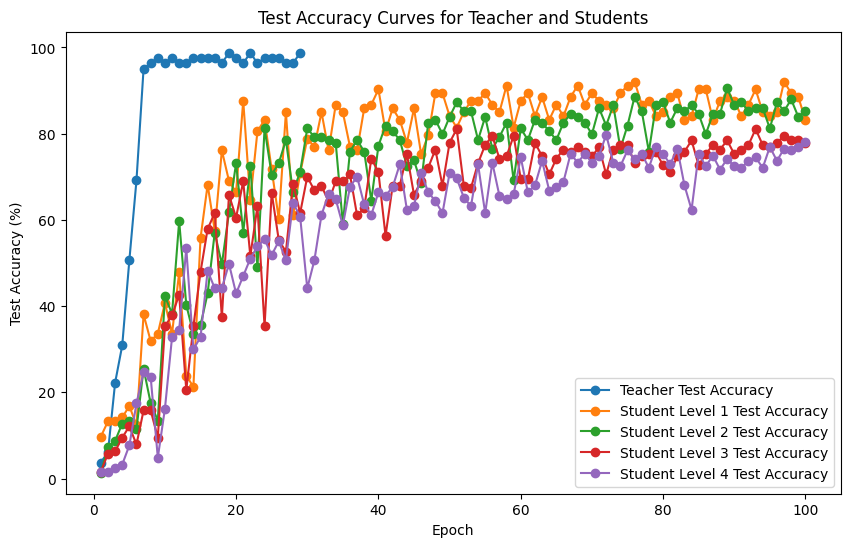

In [3]:
import math
import random
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # For KL divergence in distillation
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from Bio import SeqIO
import matplotlib.pyplot as plt  # For plotting

# Set device
device = (
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

###################################
# 1. Data Preparation Functions
###################################

def parse_fasta_with_labels(fasta_file):
    data = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        header = record.description.strip()
        sequence = str(record.seq).upper()
        label = header.split()[0]
        data.append((label, sequence))
    return data

def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, seq in raw_data:
        label_to_samples[label].append(seq)
    train_data = []
    test_data = []
    for label, seqs in label_to_samples.items():
        random.shuffle(seqs)
        test_seq = seqs[0]
        train_seqs = seqs[1:]
        test_data.append((label, test_seq))
        for s in train_seqs:
            train_data.append((label, s))
    return train_data, test_data

def generate_kmers(sequence, k=6):
    kmers = []
    for i in range(len(sequence) - k + 1):
        kmers.append(sequence[i:i+k])
    return kmers

def build_kmer_vocab(dataset, k=6):
    kmer_set = set()
    for _, seq in dataset:
        kmers = generate_kmers(seq, k)
        kmer_set.update(kmers)
    vocab = {"<UNK>": 0}
    for i, kmer in enumerate(sorted(kmer_set), start=1):
        vocab[kmer] = i
    return vocab

def encode_sequence(sequence, vocab, k=6):
    kmers = generate_kmers(sequence, k)
    encoded = [vocab.get(kmer, vocab["<UNK>"]) for kmer in kmers]
    return encoded

def filter_classes(raw_data, min_count=10):
    label_counts = Counter([label for (label, _) in raw_data])
    filtered_data = [
        (label, seq) 
        for (label, seq) in raw_data
        if label_counts[label] >= min_count
    ]
    return filtered_data

def reverse_complement(seq):
    # For simplicity, we just reverse the sequence.
    return seq[::-1]

# New added augmentation
def augment_sequence(seq, mutation_prob=0.1):
    nucleotides = ['A', 'C', 'G', 'T']
    return ''.join(
        ch if random.random() > mutation_prob else random.choice(nucleotides)
        for ch in seq
    )

def create_paired_data(data_list, augment=False):
    paired = []
    for label, seq in data_list:
        if augment:
            seq = augment_sequence(seq)
        rev_seq = reverse_complement(seq)
        paired.append((label, seq, rev_seq))
    return paired

class TwoFastaKmerDataset(Dataset):
    def __init__(self, paired_data, vocab, k=6):
        super().__init__()
        self.vocab = vocab
        self.k = k
        labels = sorted(set(item[0] for item in paired_data))
        self.label2idx = {lbl: i for i, lbl in enumerate(labels)}
        self.encoded_data = []
        for label, fwd_seq, rev_seq in paired_data:
            x1 = encode_sequence(fwd_seq, self.vocab, k=self.k)
            x2 = encode_sequence(rev_seq, self.vocab, k=self.k)
            y = self.label2idx[label]
            self.encoded_data.append((x1, x2, y))
    
    def __len__(self):
        return len(self.encoded_data)
    
    def __getitem__(self, idx):
        return self.encoded_data[idx]
    
    def get_vocab_size(self):
        return len(self.vocab)
    
    def get_num_classes(self):
        return len(self.label2idx)

def collate_fn_two(batch):
    seqs_fwd, seqs_rev, labels = zip(*batch)
    seqs_fwd_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_fwd]
    seqs_rev_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_rev]
    padded_fwd = pad_sequence(seqs_fwd_tensors, batch_first=True, padding_value=0)
    padded_rev = pad_sequence(seqs_rev_tensors, batch_first=True, padding_value=0)
    labels_tensors = torch.tensor(labels, dtype=torch.long)
    return padded_fwd, padded_rev, labels_tensors

###################################
# 2. Model Architecture
###################################

class ViTDeepSEAEncoder(nn.Module):
    def __init__(
        self,
        vocab_size,
        embed_dim=128,
        d_model=256,  # Output feature dimension
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.2, 
        max_seq_len=1000
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.deepsea_conv = nn.Sequential(
            nn.Conv1d(in_channels=embed_dim, out_channels=num_conv_filters[0], kernel_size=conv_kernel_sizes[0]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[0]),
            nn.Conv1d(in_channels=num_conv_filters[0], out_channels=num_conv_filters[1], kernel_size=conv_kernel_sizes[1]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[1]),
            nn.Conv1d(in_channels=num_conv_filters[1], out_channels=num_conv_filters[2], kernel_size=conv_kernel_sizes[2]),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.bn = nn.BatchNorm1d(num_conv_filters[2])
        self.proj = nn.Linear(num_conv_filters[2], d_model)
        self.max_tokens = 150  
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.max_tokens, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
        self.final_norm = nn.LayerNorm(d_model)  # Additional normalization
        
    def forward(self, x):
        # x: [B, seq_len]
        x = self.embedding(x)            # [B, seq_len, embed_dim]
        x = x.transpose(1, 2)            # [B, embed_dim, seq_len]
        x = self.deepsea_conv(x)         # [B, num_conv_filters[-1], L_out]
        x = self.bn(x)                   # Batch normalization
        x = x.transpose(1, 2)            # [B, L_out, num_conv_filters[-1]]
        x = self.proj(x)                 # [B, L_out, d_model]
        B, L, _ = x.size()
        pos_embed = self.pos_embedding[:, :L, :]
        x = x + pos_embed
        x = self.transformer_encoder(x)  # [B, L, d_model]
        x = self.final_norm(x)           # Final LayerNorm on transformer output
        x = x.mean(dim=1)                # [B, d_model]
        return x

class TwoViTDeepSEAFusionDNAClassifierWithFC(nn.Module):
    def __init__(
        self,
        vocab_size,
        num_classes,
        embed_dim=128,
        d_model=256,
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.2,  
        max_seq_len=1000
    ):
        super().__init__()
        self.vit_branch1 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        self.vit_branch2 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        self.fc = nn.Linear(2 * d_model, num_classes)
    
    def forward(self, x1, x2):
        f1 = self.vit_branch1(x1)  # [B, d_model]
        f2 = self.vit_branch2(x2)  # [B, d_model]
        fused = torch.cat([f1, f2], dim=1)  # [B, 2*d_model]
        logits = self.fc(fused)             # [B, num_classes]
        return logits

###################################
# Helper functions for overlapping classes in distillation
###################################

def get_overlapping_indices(teacher_label2idx, student_label2idx):
    """
    Returns two lists:
      - teacher_indices: indices in the teacher model corresponding to overlapping classes.
      - student_indices: indices in the student model corresponding to the same overlapping classes.
    """
    teacher_indices = []
    student_indices = []
    for label, t_idx in teacher_label2idx.items():
        if label in student_label2idx:
            teacher_indices.append(t_idx)
            student_indices.append(student_label2idx[label])
    return teacher_indices, student_indices

def distillation_loss(student_logits, teacher_logits, student_overlap, teacher_overlap, T):
    """
    Computes the KL divergence on the overlapping class dimensions only.
    
    student_logits: [B, num_student_classes]
    teacher_logits: [B, num_teacher_classes]
    student_overlap: list of indices in student logits for overlapping classes.
    teacher_overlap: list of indices in teacher logits for overlapping classes.
    T: temperature.
    """
    # Extract only the overlapping classes from the logits.
    s_overlap = student_logits[:, student_overlap]  # shape: [B, num_overlap]
    t_overlap = teacher_logits[:, teacher_overlap]  # shape: [B, num_overlap]
    
    return F.kl_div(F.log_softmax(s_overlap / T, dim=1),
                    F.softmax(t_overlap / T, dim=1),
                    reduction="batchmean") * (T * T)

# Alias the distillation loss function as kd_loss_fn for clarity.
kd_loss_fn = distillation_loss

###################################
# 3. Build Vocabulary from the Entire Dataset
###################################
fasta_file = "data2/fungi_ITS_cleaned.fasta"
raw_data = parse_fasta_with_labels(fasta_file)
vocab = build_kmer_vocab(raw_data, k=6)

###################################
# Stage 1: Student 10 Training (min_count >= 10)
###################################
student10_data = filter_classes(raw_data, min_count=10)
student10_train_data, student10_test_data = create_train_test_split(student10_data)
student10_paired_train = create_paired_data(student10_train_data)
student10_paired_test = create_paired_data(student10_test_data)
student10_dataset = TwoFastaKmerDataset(student10_paired_train, vocab, k=6)
student10_test_dataset = TwoFastaKmerDataset(student10_paired_test, vocab, k=6)

print("Student 10 classes (min_count>=10):")
for cls in student10_dataset.label2idx:
    print(cls)
print("Number of Student 10 classes:", student10_dataset.get_num_classes())

student10_train_loader = DataLoader(student10_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn_two)
student10_test_loader = DataLoader(student10_test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn_two)

num_classes_student10 = student10_dataset.get_num_classes()
vocab_size = student10_dataset.get_vocab_size()

student10_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student10,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320, 480, 960),
    conv_kernel_sizes=(8, 8, 8),
    pool_kernel_sizes=(4, 4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

student10_epochs = 100
optimizer_student10 = optim.AdamW(student10_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler_student10 = optim.lr_scheduler.CosineAnnealingLR(optimizer_student10, T_max=student10_epochs)

best_student10_acc = 0.0
best_student10_state = None
patience = 10
patience_counter = 0

teacher_test_acc_list = []  # To store test accuracies over epochs

print("Starting Student 10 training (min_count>=10) with early stopping and LR scheduling...")
for epoch in range(1, student10_epochs + 1):
    student10_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student10_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student10.zero_grad()
        logits = student10_model(fwd, rev)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student10_model.parameters(), max_norm=1.0)
        optimizer_student10.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student10_train_loader)
    
    # Evaluate training accuracy
    student10_model.eval()
    train_correct = 0
    train_total = 0
    with torch.no_grad():
        for fwd, rev, labels in student10_train_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(student10_model(fwd, rev), dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)
    train_acc = 100.0 * train_correct / train_total
    
    # Evaluate test accuracy
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for fwd, rev, labels in student10_test_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(student10_model(fwd, rev), dim=1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)
    student10_test_acc = 100.0 * test_correct / test_total
    teacher_test_acc_list.append(student10_test_acc)
    
    scheduler_student10.step(student10_test_acc)
    
    print(f"[Student 10] Epoch {epoch}/{student10_epochs} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {student10_test_acc:.2f}%")
    
    if student10_test_acc > best_student10_acc:
        best_student10_acc = student10_test_acc
        best_student10_state = student10_model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch}.")
        break

student10_model.load_state_dict(best_student10_state)
for param in student10_model.parameters():
    param.requires_grad = False
student10_model.eval()
print(f"Best Student 10 Accuracy: {best_student10_acc:.2f}%")

###################################
# Stage 2: Student 8 Training with Distillation from Student 10 (min_count >= 8)
###################################
student8_data = filter_classes(raw_data, min_count=8)
student8_train_data, student8_test_data = create_train_test_split(student8_data)
student8_paired_train = create_paired_data(student8_train_data)
student8_paired_test = create_paired_data(student8_test_data)
student8_dataset = TwoFastaKmerDataset(student8_paired_train, vocab, k=6)
student8_test_dataset = TwoFastaKmerDataset(student8_paired_test, vocab, k=6)

print("\nStudent 8 classes (min_count>=8):")
for cls in student8_dataset.label2idx:
    print(cls)
print("Number of Student 8 classes:", student8_dataset.get_num_classes())

student8_train_loader = DataLoader(student8_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
student8_test_loader = DataLoader(student8_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_student8 = student8_dataset.get_num_classes()

student8_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student8,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer_student8 = optim.AdamW(student8_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Distillation hyperparameters
temperature = 4.0
alpha = 0.5

# Compute overlapping indices between Student 10 (teacher) and Student 8 (student)
teacher_overlap, student_overlap = get_overlapping_indices(student10_dataset.label2idx, student8_dataset.label2idx)
print("\nOverlapping classes for KD between Student 10 and Student 8:")
for label in student10_dataset.label2idx:
    if label in student8_dataset.label2idx:
        print(label)
print("Number of overlapping classes:", len(teacher_overlap))

student8_epochs = 100
best_student8_acc = 0.0
best_student8_state = None
student8_test_acc_list = []  # to record test accuracy over epochs

print("\nStarting Student 8 training with distillation from Student 10...")
for epoch in range(1, student8_epochs + 1):
    student8_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student8_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student8.zero_grad()
        student_logits = student8_model(fwd, rev)
        with torch.no_grad():
            teacher_logits = student10_model(fwd, rev)
        ce_loss = criterion(student_logits, labels)
        kd_loss = kd_loss_fn(student_logits, teacher_logits, student_overlap, teacher_overlap, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student8_model.parameters(), max_norm=1.0)
        optimizer_student8.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student8_train_loader)
    
    # Evaluate Student 8 accuracy
    student8_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for fwd, rev, labels in student8_test_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(student8_model(fwd, rev), dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    student8_test_acc = 100.0 * correct / total
    student8_test_acc_list.append(student8_test_acc)
    
    if student8_test_acc > best_student8_acc:
        best_student8_acc = student8_test_acc
        best_student8_state = student8_model.state_dict()
    
    print(f"[Student 8] Epoch {epoch}/{student8_epochs} | Loss: {avg_loss:.4f} | Test Acc: {student8_test_acc:.2f}%")

print(f"\nHighest Student 8 Test Accuracy: {best_student8_acc:.2f}%")
student8_model.load_state_dict(best_student8_state)
for param in student8_model.parameters():
    param.requires_grad = False
student8_model.eval()

###################################
# Stage 3: Student 7 Training with Distillation from Student 8 (min_count >= 7)
###################################
student7_data = filter_classes(raw_data, min_count=7)
student7_train_data, student7_test_data = create_train_test_split(student7_data)
student7_paired_train = create_paired_data(student7_train_data)
student7_paired_test = create_paired_data(student7_test_data)
student7_dataset = TwoFastaKmerDataset(student7_paired_train, vocab, k=6)
student7_test_dataset = TwoFastaKmerDataset(student7_paired_test, vocab, k=6)

print("\nStudent 7 classes (min_count>=7):")
for cls in student7_dataset.label2idx:
    print(cls)
print("Number of Student 7 classes:", student7_dataset.get_num_classes())

student7_train_loader = DataLoader(student7_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
student7_test_loader = DataLoader(student7_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_student7 = student7_dataset.get_num_classes()

student7_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student7,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer_student7 = optim.AdamW(student7_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Compute overlapping indices between Student 8 (teacher) and Student 7 (student)
teacher_overlap_7, student_overlap_7 = get_overlapping_indices(student8_dataset.label2idx, student7_dataset.label2idx)
print("\nOverlapping classes for KD between Student 8 and Student 7:")
for label in student8_dataset.label2idx:
    if label in student7_dataset.label2idx:
        print(label)
print("Number of overlapping classes:", len(teacher_overlap_7))

student7_epochs = 100
best_student7_acc = 0.0
best_student7_state = None
student7_test_acc_list = []  # record test accuracy over epochs

print("\nStarting Student 7 training with distillation from Student 8...")
for epoch in range(1, student7_epochs + 1):
    student7_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student7_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student7.zero_grad()
        student_logits = student7_model(fwd, rev)
        with torch.no_grad():
            teacher_logits = student8_model(fwd, rev)
        ce_loss = criterion(student_logits, labels)
        kd_loss = kd_loss_fn(student_logits, teacher_logits, student_overlap_7, teacher_overlap_7, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student7_model.parameters(), max_norm=1.0)
        optimizer_student7.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student7_train_loader)
    
    # Evaluate Student 7 accuracy
    student7_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for fwd, rev, labels in student7_test_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(student7_model(fwd, rev), dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    student7_test_acc = 100.0 * correct / total
    student7_test_acc_list.append(student7_test_acc)
    
    if student7_test_acc > best_student7_acc:
        best_student7_acc = student7_test_acc
        best_student7_state = student7_model.state_dict()
    
    print(f"[Student 7] Epoch {epoch}/{student7_epochs} | Loss: {avg_loss:.4f} | Test Acc: {student7_test_acc:.2f}%")

print(f"\nHighest Student 7 Test Accuracy: {best_student7_acc:.2f}%")
student7_model.load_state_dict(best_student7_state)
for param in student7_model.parameters():
    param.requires_grad = False
student7_model.eval()

###################################
# Stage 4: Student 6 Training with Distillation from Student 7 (min_count >= 6)
###################################
student6_data = filter_classes(raw_data, min_count=6)
student6_train_data, student6_test_data = create_train_test_split(student6_data)
student6_paired_train = create_paired_data(student6_train_data)
student6_paired_test = create_paired_data(student6_test_data)
student6_dataset = TwoFastaKmerDataset(student6_paired_train, vocab, k=6)
student6_test_dataset = TwoFastaKmerDataset(student6_paired_test, vocab, k=6)

print("\nStudent 6 classes (min_count>=6):")
for cls in student6_dataset.label2idx:
    print(cls)
print("Number of Student 6 classes:", student6_dataset.get_num_classes())

student6_train_loader = DataLoader(student6_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
student6_test_loader = DataLoader(student6_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_student6 = student6_dataset.get_num_classes()

student6_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student6,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer_student6 = optim.AdamW(student6_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Compute overlapping indices between Student 7 (teacher) and Student 6 (student)
teacher_overlap_6, student_overlap_6 = get_overlapping_indices(student7_dataset.label2idx, student6_dataset.label2idx)
print("\nOverlapping classes for KD between Student 7 and Student 6:")
for label in student7_dataset.label2idx:
    if label in student6_dataset.label2idx:
        print(label)
print("Number of overlapping classes:", len(teacher_overlap_6))

student6_epochs = 100
best_student6_acc = 0.0
best_student6_state = None
student6_test_acc_list = []  # record test accuracy over epochs

print("\nStarting Student 6 training with distillation from Student 7...")
for epoch in range(1, student6_epochs + 1):
    student6_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student6_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student6.zero_grad()
        student_logits = student6_model(fwd, rev)
        with torch.no_grad():
            teacher_logits = student7_model(fwd, rev)
        ce_loss = criterion(student_logits, labels)
        kd_loss = kd_loss_fn(student_logits, teacher_logits, student_overlap_6, teacher_overlap_6, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student6_model.parameters(), max_norm=1.0)
        optimizer_student6.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student6_train_loader)
    
    # Evaluate Student 6 accuracy
    student6_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for fwd, rev, labels in student6_test_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(student6_model(fwd, rev), dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    student6_test_acc = 100.0 * correct / total
    student6_test_acc_list.append(student6_test_acc)
    
    if student6_test_acc > best_student6_acc:
        best_student6_acc = student6_test_acc
        best_student6_state = student6_model.state_dict()
    
    print(f"[Student 6] Epoch {epoch}/{student6_epochs} | Loss: {avg_loss:.4f} | Test Acc: {student6_test_acc:.2f}%")

print(f"\nHighest Student 6 Test Accuracy: {best_student6_acc:.2f}%")
student6_model.load_state_dict(best_student6_state)
for param in student6_model.parameters():
    param.requires_grad = False
student6_model.eval()

###################################
# Stage 5: Student 5 Training with Distillation from Student 6 (min_count >= 5)
###################################
student5_data = filter_classes(raw_data, min_count=5)
student5_train_data, student5_test_data = create_train_test_split(student5_data)
student5_paired_train = create_paired_data(student5_train_data)
student5_paired_test = create_paired_data(student5_test_data)
student5_dataset = TwoFastaKmerDataset(student5_paired_train, vocab, k=6)
student5_test_dataset = TwoFastaKmerDataset(student5_paired_test, vocab, k=6)

print("\nStudent 5 classes (min_count>=5):")
for cls in student5_dataset.label2idx:
    print(cls)
print("Number of Student 5 classes:", student5_dataset.get_num_classes())

student5_train_loader = DataLoader(student5_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
student5_test_loader = DataLoader(student5_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_student5 = student5_dataset.get_num_classes()

student5_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student5,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer_student5 = optim.AdamW(student5_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Compute overlapping indices between Student 6 (teacher) and Student 5 (student)
teacher_overlap_5, student_overlap_5 = get_overlapping_indices(student6_dataset.label2idx, student5_dataset.label2idx)
print("\nOverlapping classes for KD between Student 6 and Student 5:")
for label in student6_dataset.label2idx:
    if label in student5_dataset.label2idx:
        print(label)
print("Number of overlapping classes:", len(teacher_overlap_5))

student5_epochs = 100
best_student5_acc = 0.0
best_student5_state = None
student5_acc_list = []  # record test accuracy over epochs

print("\nStarting Student 5 training with distillation from Student 6...")
for epoch in range(1, student5_epochs + 1):
    student5_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student5_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student5.zero_grad()
        student_logits = student5_model(fwd, rev)
        with torch.no_grad():
            teacher_logits = student6_model(fwd, rev)
        ce_loss = criterion(student_logits, labels)
        kd_loss = kd_loss_fn(student_logits, teacher_logits, student_overlap_5, teacher_overlap_5, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student5_model.parameters(), max_norm=1.0)
        optimizer_student5.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student5_train_loader)
    
    # Evaluate Student 5 accuracy
    student5_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for fwd, rev, labels in student5_test_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            preds = torch.argmax(student5_model(fwd, rev), dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    student5_test_acc = 100.0 * correct / total
    student5_acc_list.append(student5_test_acc)
    
    if student5_test_acc > best_student5_acc:
        best_student5_acc = student5_test_acc
        best_student5_state = student5_model.state_dict()
    
    print(f"[Student 5] Epoch {epoch}/{student5_epochs} | Loss: {avg_loss:.4f} | Test Acc: {student5_test_acc:.2f}%")

print(f"\nHighest Student 5 Test Accuracy: {best_student5_acc:.2f}% at final epoch")
student5_model.load_state_dict(best_student5_state)
for param in student5_model.parameters():
    param.requires_grad = False
student5_model.eval()

###################################
# Plotting Test Accuracy Curves
###################################
plt.figure(figsize=(10,6))
plt.plot(range(1, len(teacher_test_acc_list)+1), teacher_test_acc_list, label="Teacher Test Accuracy", marker="o")
plt.plot(range(1, len(student8_test_acc_list)+1), student8_test_acc_list, label="Student Level 1 Test Accuracy", marker="o")
plt.plot(range(1, len(student7_test_acc_list)+1), student7_test_acc_list, label="Student Level 2 Test Accuracy", marker="o")
plt.plot(range(1, len(student6_test_acc_list)+1), student6_test_acc_list, label="Student Level 3 Test Accuracy", marker="o")
plt.plot(range(1, len(student5_acc_list)+1), student5_acc_list, label="Student Level 4 Test Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy Curves for Teacher and Students")
plt.legend()
plt.show()


Student 10 classes (min_count>=10):
Absidia
Amanita
Apiospora
Arthroderma
Aspergillus
Backusella
Bambusicola
Blastobotrys
Boletus
Candida
Cantharellus
Cladophialophora
Clavaria
Clavulina
Colacogloea
Coprinopsis
Cortinarius
Crepidotus
Cyberlindnera
Cyphellophora
Elsinoe
Entoloma
Exophiala
Fomitiporia
Geastrum
Genea
Gymnopus
Hydnellum
Hygrocybe
Hygrophorus
Hymenochaete
Hypoxylon
Inocybe
Inosperma
Kazachstania
Lactarius
Lactifluus
Lecanora
Lepiota
Leucoagaricus
Lipomyces
Malassezia
Marasmius
Metschnikowia
Mortierella
Mucor
Mycena
Ogataea
Ophiocordyceps
Orbilia
Otidea
Perenniporia
Phylloporus
Phyllosticta
Pichia
Pluteus
Pseudosperma
Raffaelea
Ramaria
Roussoella
Russula
Saccharomycopsis
Saturnispora
Scolecobasidium
Scytinostroma
Spathaspora
Starmerella
Sugiyamaella
Suhomyces
Talaromyces
Tomentella
Trechispora
Tremella
Trichoderma
Tricholoma
Tuber
Verrucaria
Wickerhamiella
Wickerhamomyces
Xylaria
Xylodon
Number of Student 10 classes: 81
Starting Student 10 training (min_count>=10) with early

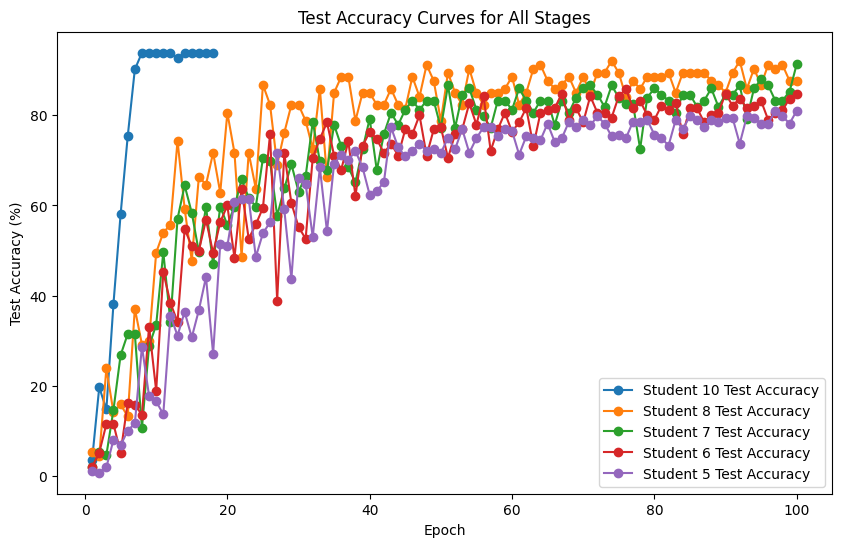

In [4]:
import math
import random
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # For KL divergence in distillation
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from Bio import SeqIO
import matplotlib.pyplot as plt  # For plotting

# Set device
device = (
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

###################################
# 1. Data Preparation Functions
###################################

def parse_fasta_with_labels(fasta_file):
    data = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        header = record.description.strip()
        sequence = str(record.seq).upper()
        label = header.split()[0]
        data.append((label, sequence))
    return data

def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, seq in raw_data:
        label_to_samples[label].append(seq)
    train_data = []
    test_data = []
    for label, seqs in label_to_samples.items():
        random.shuffle(seqs)
        test_seq = seqs[0]
        train_seqs = seqs[1:]
        test_data.append((label, test_seq))
        for s in train_seqs:
            train_data.append((label, s))
    return train_data, test_data

def generate_kmers(sequence, k=6):
    kmers = []
    for i in range(len(sequence) - k + 1):
        kmers.append(sequence[i:i+k])
    return kmers

def build_kmer_vocab(dataset, k=6):
    kmer_set = set()
    for _, seq in dataset:
        kmers = generate_kmers(seq, k)
        kmer_set.update(kmers)
    vocab = {"<UNK>": 0}
    for i, kmer in enumerate(sorted(kmer_set), start=1):
        vocab[kmer] = i
    return vocab

def encode_sequence(sequence, vocab, k=6):
    kmers = generate_kmers(sequence, k)
    encoded = [vocab.get(kmer, vocab["<UNK>"]) for kmer in kmers]
    return encoded

def filter_classes(raw_data, min_count=5):
    label_counts = Counter([label for (label, _) in raw_data])
    filtered_data = [(label, seq) for (label, seq) in raw_data if label_counts[label] >= min_count]
    return filtered_data

def reverse_complement(seq):
    # For simplicity, we just reverse the sequence.
    return seq[::-1]

def create_paired_data(data_list):
    paired = []
    for label, seq in data_list:
        rev_seq = reverse_complement(seq)
        paired.append((label, seq, rev_seq))
    return paired

class TwoFastaKmerDataset(Dataset):
    """
    Each item: (encoded_seq_fwd, encoded_seq_rev, label_idx)
    """
    def __init__(self, paired_data, vocab, k=6):
        super().__init__()
        self.vocab = vocab
        self.k = k
        labels = sorted(set(item[0] for item in paired_data))
        self.label2idx = {lbl: i for i, lbl in enumerate(labels)}
        self.encoded_data = []
        for label, fwd_seq, rev_seq in paired_data:
            x1 = encode_sequence(fwd_seq, self.vocab, k=self.k)
            x2 = encode_sequence(rev_seq, self.vocab, k=self.k)
            y = self.label2idx[label]
            self.encoded_data.append((x1, x2, y))
    
    def __len__(self):
        return len(self.encoded_data)
    
    def __getitem__(self, idx):
        return self.encoded_data[idx]
    
    def get_vocab_size(self):
        return len(self.vocab)
    
    def get_num_classes(self):
        return len(self.label2idx)

def collate_fn_two(batch):
    seqs_fwd, seqs_rev, labels = zip(*batch)
    seqs_fwd_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_fwd]
    seqs_rev_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_rev]
    padded_fwd = pad_sequence(seqs_fwd_tensors, batch_first=True, padding_value=0)
    padded_rev = pad_sequence(seqs_rev_tensors, batch_first=True, padding_value=0)
    labels_tensors = torch.tensor(labels, dtype=torch.long)
    return padded_fwd, padded_rev, labels_tensors

###################################
# 2. Model Architecture
###################################

class ViTDeepSEAEncoder(nn.Module):
    """
    k-mer embedding, DeepSEA-style conv block, projection,
    positional embedding, Transformer encoding, and mean pooling.
    """
    def __init__(
        self,
        vocab_size,
        embed_dim=128,
        d_model=256,
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.2,
        max_seq_len=1000
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.deepsea_conv = nn.Sequential(
            nn.Conv1d(in_channels=embed_dim, out_channels=num_conv_filters[0], kernel_size=conv_kernel_sizes[0]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[0]),
            nn.Conv1d(in_channels=num_conv_filters[0], out_channels=num_conv_filters[1], kernel_size=conv_kernel_sizes[1]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[1]),
            nn.Conv1d(in_channels=num_conv_filters[1], out_channels=num_conv_filters[2], kernel_size=conv_kernel_sizes[2]),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.bn = nn.BatchNorm1d(num_conv_filters[2])
        self.proj = nn.Linear(num_conv_filters[2], d_model)
        self.max_tokens = 150
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.max_tokens, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
        self.final_norm = nn.LayerNorm(d_model)
        
    def forward(self, x):
        x = self.embedding(x)            # [B, seq_len, embed_dim]
        x = x.transpose(1, 2)            # [B, embed_dim, seq_len]
        x = self.deepsea_conv(x)         # [B, num_conv_filters[-1], L_out]
        x = self.bn(x)
        x = x.transpose(1, 2)            # [B, L_out, num_conv_filters[-1]]
        x = self.proj(x)                 # [B, L_out, d_model]
        B, L, _ = x.size()
        pos_embed = self.pos_embedding[:, :L, :]
        x = x + pos_embed
        x = self.transformer_encoder(x)
        x = self.final_norm(x)
        x = x.mean(dim=1)
        return x

class TwoViTDeepSEAFusionDNAClassifierWithFC(nn.Module):
    """
    Two-branch model: processes forward and reverse sequences,
    concatenates features, and applies a fully-connected layer.
    """
    def __init__(
        self,
        vocab_size,
        num_classes,
        embed_dim=128,
        d_model=256,
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.2,
        max_seq_len=1000
    ):
        super().__init__()
        self.vit_branch1 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        self.vit_branch2 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        self.fc = nn.Linear(2 * d_model, num_classes)
    
    def forward(self, x1, x2):
        f1 = self.vit_branch1(x1)
        f2 = self.vit_branch2(x2)
        fused = torch.cat([f1, f2], dim=1)
        logits = self.fc(fused)
        return logits

###################################
# Helper functions for overlapping classes in distillation
###################################

def get_overlapping_indices(teacher_label2idx, student_label2idx):
    """
    Returns two lists of indices corresponding to overlapping classes.
    """
    teacher_indices = []
    student_indices = []
    for label, t_idx in teacher_label2idx.items():
        if label in student_label2idx:
            teacher_indices.append(t_idx)
            student_indices.append(student_label2idx[label])
    return teacher_indices, student_indices

def distillation_loss(student_logits, teacher_logits, student_overlap, teacher_overlap, T):
    """
    Computes KL divergence over the overlapping classes only.
    """
    s_overlap = student_logits[:, student_overlap]  # [B, num_overlap]
    t_overlap = teacher_logits[:, teacher_overlap]  # [B, num_overlap]
    return F.kl_div(F.log_softmax(s_overlap / T, dim=1),
                    F.softmax(t_overlap / T, dim=1),
                    reduction="batchmean") * (T * T)

###################################
# 3. Build Vocabulary from the Entire Dataset
###################################
fasta_file = "data2/fungi_ITS_cleaned.fasta"
raw_data = parse_fasta_with_labels(fasta_file)
vocab = build_kmer_vocab(raw_data, k=6)

###################################
# Stage 1: Student 10 Training (min_count >= 10)
###################################
student10_data = filter_classes(raw_data, min_count=10)
student10_train_data, student10_test_data = create_train_test_split(student10_data)
student10_paired_train = create_paired_data(student10_train_data)
student10_paired_test = create_paired_data(student10_test_data)
student10_dataset = TwoFastaKmerDataset(student10_paired_train, vocab, k=6)
student10_test_dataset = TwoFastaKmerDataset(student10_paired_test, vocab, k=6)

print("Student 10 classes (min_count>=10):")
for cls in student10_dataset.label2idx:
    print(cls)
print("Number of Student 10 classes:", student10_dataset.get_num_classes())

student10_train_loader = DataLoader(student10_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn_two)
student10_test_loader = DataLoader(student10_test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn_two)

num_classes_student10 = student10_dataset.get_num_classes()
vocab_size = student10_dataset.get_vocab_size()

student10_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student10,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320, 480, 960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

student10_epochs = 100
optimizer_student10 = optim.AdamW(student10_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler_student10 = optim.lr_scheduler.CosineAnnealingLR(optimizer_student10, T_max=student10_epochs)

best_student10_acc = 0.0
best_student10_state = None
patience = 10
patience_counter = 0

teacher_test_acc_list = []  # We'll treat Student 10 as the teacher for Stage 2

print("Starting Student 10 training (min_count>=10) with early stopping and LR scheduling...")
for epoch in range(1, student10_epochs + 1):
    student10_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student10_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student10.zero_grad()
        logits = student10_model(fwd, rev)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student10_model.parameters(), max_norm=1.0)
        optimizer_student10.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student10_train_loader)
    
    # Evaluate Student 10 accuracy
    student10_model.eval()
    train_correct = 0
    train_total = 0
    for fwd, rev, labels in student10_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        preds = torch.argmax(student10_model(fwd, rev), dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
    train_acc = 100.0 * train_correct / train_total
    
    test_correct = 0
    test_total = 0
    for fwd, rev, labels in student10_test_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        preds = torch.argmax(student10_model(fwd, rev), dim=1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)
    test_acc = 100.0 * test_correct / test_total
    teacher_test_acc_list.append(test_acc)
    
    scheduler_student10.step(test_acc)
    
    print(f"[Student 10] Epoch {epoch}/{student10_epochs} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")
    
    if test_acc > best_student10_acc:
        best_student10_acc = test_acc
        best_student10_state = student10_model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch}.")
        break

student10_model.load_state_dict(best_student10_state)
for param in student10_model.parameters():
    param.requires_grad = False
student10_model.eval()
print(f"Best Student 10 Accuracy: {best_student10_acc:.2f}%")

###################################
# Stage 2: Student 8 Training with Distillation from Student 10 (min_count >= 8)
###################################
student8_data = filter_classes(raw_data, min_count=8)
student8_train_data, student8_test_data = create_train_test_split(student8_data)
student8_paired_train = create_paired_data(student8_train_data)
student8_paired_test = create_paired_data(student8_test_data)
student8_dataset = TwoFastaKmerDataset(student8_paired_train, vocab, k=6)
student8_test_dataset = TwoFastaKmerDataset(student8_paired_test, vocab, k=6)

print("\nStudent 8 classes (min_count>=8):")
for cls in student8_dataset.label2idx:
    print(cls)
print("Number of Student 8 classes:", student8_dataset.get_num_classes())

student8_train_loader = DataLoader(student8_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
student8_test_loader = DataLoader(student8_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_student8 = student8_dataset.get_num_classes()

student8_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student8,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer_student8 = optim.AdamW(student8_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Distillation hyperparameters
temperature = 4.0
alpha = 0.5

# Get overlapping indices between Student 10 (teacher) and Student 8 (student)
teacher_overlap, student_overlap = get_overlapping_indices(student10_dataset.label2idx, student8_dataset.label2idx)
print("\nOverlapping classes for KD between Student 10 and Student 8:")
for label in student10_dataset.label2idx:
    if label in student8_dataset.label2idx:
        print(label)
print("Number of overlapping classes:", len(teacher_overlap))

student8_test_acc_list = []  # to store test accuracy per epoch for Student 8

student8_epochs = 100
best_student8_acc = 0.0
best_student8_state = None

print("\nStarting Student 8 training with distillation from Student 10...")
for epoch in range(1, student8_epochs + 1):
    student8_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student8_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student8.zero_grad()
        student_logits = student8_model(fwd, rev)
        with torch.no_grad():
            teacher_logits = student10_model(fwd, rev)
        ce_loss = criterion(student_logits, labels)
        kd_loss = distillation_loss(student_logits, teacher_logits, student_overlap, teacher_overlap, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student8_model.parameters(), max_norm=1.0)
        optimizer_student8.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student8_train_loader)
    
    # Evaluate Student 8 accuracy
    student8_model.eval()
    correct = 0
    total = 0
    for fwd, rev, labels in student8_test_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        preds = torch.argmax(student8_model(fwd, rev), dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    test_acc = 100.0 * correct / total
    student8_test_acc_list.append(test_acc)
    
    print(f"[Student 8] Epoch {epoch}/{student8_epochs} | Loss: {avg_loss:.4f} | Test Acc: {test_acc:.2f}%")
    
    if test_acc > best_student8_acc:
        best_student8_acc = test_acc
        best_student8_state = student8_model.state_dict()

student8_model.load_state_dict(best_student8_state)
for param in student8_model.parameters():
    param.requires_grad = False
student8_model.eval()
print(f"\nHighest Student 8 Test Accuracy: {best_student8_acc:.2f}%")

###################################
# Stage 3: Student 7 Training with Distillation from Student 8 (min_count >= 7)
###################################
student7_data = filter_classes(raw_data, min_count=7)
student7_train_data, student7_test_data = create_train_test_split(student7_data)
student7_paired_train = create_paired_data(student7_train_data)
student7_paired_test = create_paired_data(student7_test_data)
student7_dataset = TwoFastaKmerDataset(student7_paired_train, vocab, k=6)
student7_test_dataset = TwoFastaKmerDataset(student7_paired_test, vocab, k=6)

print("\nStudent 7 classes (min_count>=7):")
for cls in student7_dataset.label2idx:
    print(cls)
print("Number of Student 7 classes:", student7_dataset.get_num_classes())

student7_train_loader = DataLoader(student7_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
student7_test_loader = DataLoader(student7_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_student7 = student7_dataset.get_num_classes()

student7_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student7,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer_student7 = optim.AdamW(student7_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

teacher_overlap_7, student_overlap_7 = get_overlapping_indices(student8_dataset.label2idx, student7_dataset.label2idx)
print("\nOverlapping classes for KD between Student 8 and Student 7:")
for label in student8_dataset.label2idx:
    if label in student7_dataset.label2idx:
        print(label)
print("Number of overlapping classes:", len(teacher_overlap_7))

student7_test_acc_list = []

student7_epochs = 100
best_student7_acc = 0.0
best_student7_state = None

print("\nStarting Student 7 training with distillation from Student 8...")
for epoch in range(1, student7_epochs + 1):
    student7_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student7_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student7.zero_grad()
        student_logits = student7_model(fwd, rev)
        with torch.no_grad():
            teacher_logits = student8_model(fwd, rev)
        ce_loss = criterion(student_logits, labels)
        kd_loss = distillation_loss(student_logits, teacher_logits, student_overlap_7, teacher_overlap_7, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student7_model.parameters(), max_norm=1.0)
        optimizer_student7.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student7_train_loader)
    
    student7_model.eval()
    correct = 0
    total = 0
    for fwd, rev, labels in student7_test_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        preds = torch.argmax(student7_model(fwd, rev), dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    test_acc = 100.0 * correct / total
    student7_test_acc_list.append(test_acc)
    
    print(f"[Student 7] Epoch {epoch}/{student7_epochs} | Loss: {avg_loss:.4f} | Test Acc: {test_acc:.2f}%")
    
    if test_acc > best_student7_acc:
        best_student7_acc = test_acc
        best_student7_state = student7_model.state_dict()

student7_model.load_state_dict(best_student7_state)
for param in student7_model.parameters():
    param.requires_grad = False
student7_model.eval()
print(f"\nHighest Student 7 Test Accuracy: {best_student7_acc:.2f}%")

###################################
# Stage 4: Student 6 Training with Distillation from Student 7 (min_count >= 6)
###################################
student6_data = filter_classes(raw_data, min_count=6)
student6_train_data, student6_test_data = create_train_test_split(student6_data)
student6_paired_train = create_paired_data(student6_train_data)
student6_paired_test = create_paired_data(student6_test_data)
student6_dataset = TwoFastaKmerDataset(student6_paired_train, vocab, k=6)
student6_test_dataset = TwoFastaKmerDataset(student6_paired_test, vocab, k=6)

print("\nStudent 6 classes (min_count>=6):")
for cls in student6_dataset.label2idx:
    print(cls)
print("Number of Student 6 classes:", student6_dataset.get_num_classes())

student6_train_loader = DataLoader(student6_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
student6_test_loader = DataLoader(student6_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_student6 = student6_dataset.get_num_classes()

student6_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student6,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer_student6 = optim.AdamW(student6_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

teacher_overlap_6, student_overlap_6 = get_overlapping_indices(student7_dataset.label2idx, student6_dataset.label2idx)
print("\nOverlapping classes for KD between Student 7 and Student 6:")
for label in student7_dataset.label2idx:
    if label in student6_dataset.label2idx:
        print(label)
print("Number of overlapping classes:", len(teacher_overlap_6))

student6_test_acc_list = []

student6_epochs = 100
best_student6_acc = 0.0
best_student6_state = None

print("\nStarting Student 6 training with distillation from Student 7...")
for epoch in range(1, student6_epochs + 1):
    student6_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student6_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student6.zero_grad()
        student_logits = student6_model(fwd, rev)
        with torch.no_grad():
            teacher_logits = student7_model(fwd, rev)
        ce_loss = criterion(student_logits, labels)
        kd_loss = distillation_loss(student_logits, teacher_logits, student_overlap_6, teacher_overlap_6, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student6_model.parameters(), max_norm=1.0)
        optimizer_student6.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student6_train_loader)
    
    student6_model.eval()
    correct = 0
    total = 0
    for fwd, rev, labels in student6_test_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        preds = torch.argmax(student6_model(fwd, rev), dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    test_acc = 100.0 * correct / total
    student6_test_acc_list.append(test_acc)
    
    print(f"[Student 6] Epoch {epoch}/{student6_epochs} | Loss: {avg_loss:.4f} | Test Acc: {test_acc:.2f}%")
    
    if test_acc > best_student6_acc:
        best_student6_acc = test_acc
        best_student6_state = student6_model.state_dict()

student6_model.load_state_dict(best_student6_state)
for param in student6_model.parameters():
    param.requires_grad = False
student6_model.eval()
print(f"\nHighest Student 6 Test Accuracy: {best_student6_acc:.2f}%")

###################################
# Stage 5: Student 5 Training with Distillation from Student 6 (min_count >= 5)
###################################
student5_data = filter_classes(raw_data, min_count=5)
student5_train_data, student5_test_data = create_train_test_split(student5_data)
student5_paired_train = create_paired_data(student5_train_data)
student5_paired_test = create_paired_data(student5_test_data)
student5_dataset = TwoFastaKmerDataset(student5_paired_train, vocab, k=6)
student5_test_dataset = TwoFastaKmerDataset(student5_paired_test, vocab, k=6)

print("\nStudent 5 classes (min_count>=5):")
for cls in student5_dataset.label2idx:
    print(cls)
print("Number of Student 5 classes:", student5_dataset.get_num_classes())

student5_train_loader = DataLoader(student5_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
student5_test_loader = DataLoader(student5_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_student5 = student5_dataset.get_num_classes()

student5_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student5,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer_student5 = optim.AdamW(student5_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

teacher_overlap_5, student_overlap_5 = get_overlapping_indices(student6_dataset.label2idx, student5_dataset.label2idx)
print("\nOverlapping classes for KD between Student 6 and Student 5:")
for label in student6_dataset.label2idx:
    if label in student5_dataset.label2idx:
        print(label)
print("Number of overlapping classes:", len(teacher_overlap_5))

student5_acc_list = []

student5_epochs = 100
best_student5_acc = 0.0
best_student5_state = None

print("\nStarting Student 5 training with distillation from Student 6...")
for epoch in range(1, student5_epochs + 1):
    student5_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student5_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student5.zero_grad()
        student_logits = student5_model(fwd, rev)
        with torch.no_grad():
            teacher_logits = student6_model(fwd, rev)
        ce_loss = criterion(student_logits, labels)
        kd_loss = distillation_loss(student_logits, teacher_logits, student_overlap_5, teacher_overlap_5, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student5_model.parameters(), max_norm=1.0)
        optimizer_student5.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student5_train_loader)
    
    student5_model.eval()
    correct = 0
    total = 0
    for fwd, rev, labels in student5_test_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        preds = torch.argmax(student5_model(fwd, rev), dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    test_acc = 100.0 * correct / total
    student5_acc_list.append(test_acc)
    
    print(f"[Student 5] Epoch {epoch}/{student5_epochs} | Loss: {avg_loss:.4f} | Test Acc: {test_acc:.2f}%")
    
    if test_acc > best_student5_acc:
        best_student5_acc = test_acc
        best_student5_state = student5_model.state_dict()

student5_model.load_state_dict(best_student5_state)
for param in student5_model.parameters():
    param.requires_grad = False
student5_model.eval()
print(f"\nHighest Student 5 Test Accuracy: {best_student5_acc:.2f}% at final epoch")

###################################
# Plotting Test Accuracy Curves
###################################
plt.figure(figsize=(10,6))
plt.plot(range(1, len(teacher_test_acc_list)+1), teacher_test_acc_list, label="Student 10 Test Accuracy", marker="o")
plt.plot(range(1, len(student8_test_acc_list)+1), student8_test_acc_list, label="Student 8 Test Accuracy", marker="o")
plt.plot(range(1, len(student7_test_acc_list)+1), student7_test_acc_list, label="Student 7 Test Accuracy", marker="o")
plt.plot(range(1, len(student6_test_acc_list)+1), student6_test_acc_list, label="Student 6 Test Accuracy", marker="o")
plt.plot(range(1, len(student5_acc_list)+1), student5_acc_list, label="Student 5 Test Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy Curves for All Stages")
plt.legend()
plt.show()


# with HMM

Student 10 classes (min_count>=10):
Absidia
Amanita
Apiospora
Arthroderma
Aspergillus
Backusella
Bambusicola
Blastobotrys
Boletus
Candida
Cantharellus
Cladophialophora
Clavaria
Clavulina
Colacogloea
Coprinopsis
Cortinarius
Crepidotus
Cyberlindnera
Cyphellophora
Elsinoe
Entoloma
Exophiala
Fomitiporia
Geastrum
Genea
Gymnopus
Hydnellum
Hygrocybe
Hygrophorus
Hymenochaete
Hypoxylon
Inocybe
Inosperma
Kazachstania
Lactarius
Lactifluus
Lecanora
Lepiota
Leucoagaricus
Lipomyces
Malassezia
Marasmius
Metschnikowia
Mortierella
Mucor
Mycena
Ogataea
Ophiocordyceps
Orbilia
Otidea
Perenniporia
Phylloporus
Phyllosticta
Pichia
Pluteus
Pseudosperma
Raffaelea
Ramaria
Roussoella
Russula
Saccharomycopsis
Saturnispora
Scolecobasidium
Scytinostroma
Spathaspora
Starmerella
Sugiyamaella
Suhomyces
Talaromyces
Tomentella
Trechispora
Tremella
Trichoderma
Tricholoma
Tuber
Verrucaria
Wickerhamiella
Wickerhamomyces
Xylaria
Xylodon
Number of Student 10 classes: 81


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting Student 10 training (min_count>=10) with early stopping and LR scheduling...


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[Student 10] Epoch 1/100 | Loss: 3.5865 | Train Acc: 20.10% | Test Acc: 4.94%
[Student 10] Epoch 2/100 | Loss: 2.1492 | Train Acc: 28.97% | Test Acc: 7.41%
[Student 10] Epoch 3/100 | Loss: 1.0979 | Train Acc: 41.07% | Test Acc: 13.58%
[Student 10] Epoch 4/100 | Loss: 0.4691 | Train Acc: 58.00% | Test Acc: 24.69%
[Student 10] Epoch 5/100 | Loss: 0.1687 | Train Acc: 92.18% | Test Acc: 49.38%
[Student 10] Epoch 6/100 | Loss: 0.0550 | Train Acc: 100.00% | Test Acc: 80.25%
[Student 10] Epoch 7/100 | Loss: 0.0262 | Train Acc: 100.00% | Test Acc: 95.06%
[Student 10] Epoch 8/100 | Loss: 0.0233 | Train Acc: 100.00% | Test Acc: 95.06%
[Student 10] Epoch 9/100 | Loss: 0.0227 | Train Acc: 100.00% | Test Acc: 96.30%
[Student 10] Epoch 10/100 | Loss: 0.0231 | Train Acc: 100.00% | Test Acc: 96.30%
[Student 10] Epoch 11/100 | Loss: 0.0230 | Train Acc: 100.00% | Test Acc: 96.30%
[Student 10] Epoch 12/100 | Loss: 0.0225 | Train Acc: 100.00% | Test Acc: 95.06%
[Student 10] Epoch 13/100 | Loss: 0.0224 | T

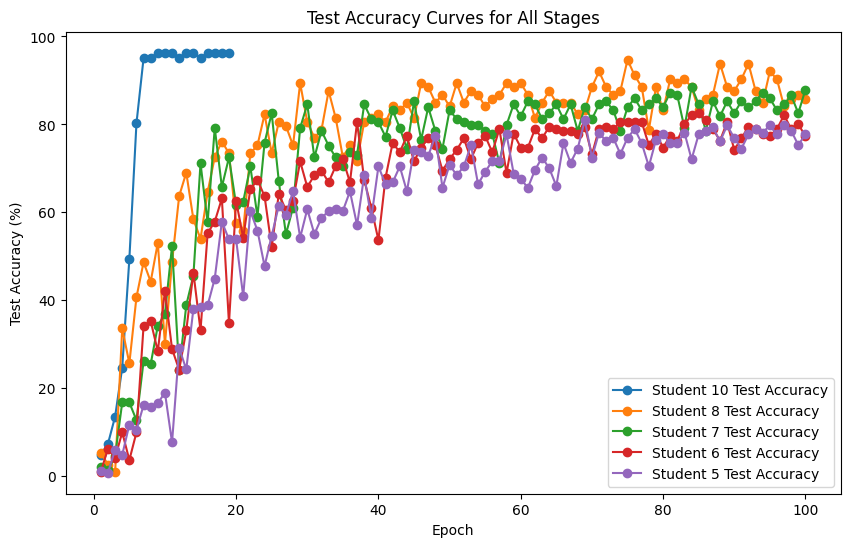

In [ ]:
import math
import random
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # For KL divergence in distillation
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from Bio import SeqIO
import matplotlib.pyplot as plt  # For plotting

# Set device
device = (
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

###################################
# 1. Data Preparation Functions
###################################

def parse_fasta_with_labels(fasta_file):
    data = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        header = record.description.strip()
        sequence = str(record.seq).upper()
        label = header.split()[0]
        data.append((label, sequence))
    return data

def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, seq in raw_data:
        label_to_samples[label].append(seq)
    train_data = []
    test_data = []
    for label, seqs in label_to_samples.items():
        random.shuffle(seqs)
        test_seq = seqs[0]
        train_seqs = seqs[1:]
        test_data.append((label, test_seq))
        for s in train_seqs:
            train_data.append((label, s))
    return train_data, test_data

def generate_kmers(sequence, k=6):
    kmers = []
    for i in range(len(sequence) - k + 1):
        kmers.append(sequence[i:i+k])
    return kmers

def build_kmer_vocab(dataset, k=6):
    kmer_set = set()
    for _, seq in dataset:
        kmers = generate_kmers(seq, k)
        kmer_set.update(kmers)
    vocab = {"<UNK>": 0}
    for i, kmer in enumerate(sorted(kmer_set), start=1):
        vocab[kmer] = i
    return vocab

def encode_sequence(sequence, vocab, k=6):
    kmers = generate_kmers(sequence, k)
    encoded = [vocab.get(kmer, vocab["<UNK>"]) for kmer in kmers]
    return encoded

def filter_classes(raw_data, min_count=5):
    label_counts = Counter([label for (label, _) in raw_data])
    filtered_data = [(label, seq) for (label, seq) in raw_data if label_counts[label] >= min_count]
    return filtered_data

def reverse_complement(seq):
    # For simplicity, we just reverse the sequence.
    return seq[::-1]

def create_paired_data(data_list):
    paired = []
    for label, seq in data_list:
        rev_seq = reverse_complement(seq)
        paired.append((label, seq, rev_seq))
    return paired

class TwoFastaKmerDataset(Dataset):
    """
    Each item: (encoded_seq_fwd, encoded_seq_rev, label_idx)
    """
    def __init__(self, paired_data, vocab, k=6):
        super().__init__()
        self.vocab = vocab
        self.k = k
        labels = sorted(set(item[0] for item in paired_data))
        self.label2idx = {lbl: i for i, lbl in enumerate(labels)}
        self.encoded_data = []
        for label, fwd_seq, rev_seq in paired_data:
            x1 = encode_sequence(fwd_seq, self.vocab, k=self.k)
            x2 = encode_sequence(rev_seq, self.vocab, k=self.k)
            y = self.label2idx[label]
            self.encoded_data.append((x1, x2, y))
    
    def __len__(self):
        return len(self.encoded_data)
    
    def __getitem__(self, idx):
        return self.encoded_data[idx]
    
    def get_vocab_size(self):
        return len(self.vocab)
    
    def get_num_classes(self):
        return len(self.label2idx)

def collate_fn_two(batch):
    seqs_fwd, seqs_rev, labels = zip(*batch)
    seqs_fwd_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_fwd]
    seqs_rev_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_rev]
    padded_fwd = pad_sequence(seqs_fwd_tensors, batch_first=True, padding_value=0)
    padded_rev = pad_sequence(seqs_rev_tensors, batch_first=True, padding_value=0)
    labels_tensors = torch.tensor(labels, dtype=torch.long)
    return padded_fwd, padded_rev, labels_tensors

###################################
# 2. Model Architecture Components
###################################

class ViTDeepSEAEncoder(nn.Module):
    """
    k-mer embedding, DeepSEA-style conv block, projection,
    positional embedding, Transformer encoding, and mean pooling.
    """
    def __init__(
        self,
        vocab_size,
        embed_dim=128,
        d_model=256,
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.2,
        max_seq_len=1000
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.deepsea_conv = nn.Sequential(
            nn.Conv1d(in_channels=embed_dim, out_channels=num_conv_filters[0], kernel_size=conv_kernel_sizes[0]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[0]),
            nn.Conv1d(in_channels=num_conv_filters[0], out_channels=num_conv_filters[1], kernel_size=conv_kernel_sizes[1]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[1]),
            nn.Conv1d(in_channels=num_conv_filters[1], out_channels=num_conv_filters[2], kernel_size=conv_kernel_sizes[2]),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.bn = nn.BatchNorm1d(num_conv_filters[2])
        self.proj = nn.Linear(num_conv_filters[2], d_model)
        self.max_tokens = 150
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.max_tokens, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
        self.final_norm = nn.LayerNorm(d_model)
        
    def forward(self, x):
        x = self.embedding(x)            # [B, seq_len, embed_dim]
        x = x.transpose(1, 2)            # [B, embed_dim, seq_len]
        x = self.deepsea_conv(x)         # [B, num_conv_filters[-1], L_out]
        x = self.bn(x)
        x = x.transpose(1, 2)            # [B, L_out, num_conv_filters[-1]]
        x = self.proj(x)                 # [B, L_out, d_model]
        B, L, _ = x.size()
        pos_embed = self.pos_embedding[:, :L, :]
        x = x + pos_embed
        x = self.transformer_encoder(x)
        x = self.final_norm(x)
        x = x.mean(dim=1)                # [B, d_model]
        return x

###################################
# HMM Feature Extractor Component
###################################

class HMMFeatureExtractor(nn.Module):
    """
    A differentiable HMM layer that computes soft state occupancies as features.
    It takes embedded sequences as input and returns an averaged posterior over states.
    """
    def __init__(self, embed_dim, num_states):
        super().__init__()
        self.num_states = num_states
        # Map embedding at each token to emission logits for each state.
        self.emission_linear = nn.Linear(embed_dim, num_states)
        # Learnable initial state log probabilities.
        self.initial_log_probs = nn.Parameter(torch.randn(num_states))
        # Learnable state transition log probabilities.
        self.transition_log_probs = nn.Parameter(torch.randn(num_states, num_states))
        
    def forward(self, embedded_seq):
        """
        embedded_seq: Tensor of shape [B, L, embed_dim]
        Returns: hmm_features of shape [B, num_states]
        """
        B, L, _ = embedded_seq.size()
        # Compute emission logits then normalize into log-probabilities.
        emissions = self.emission_linear(embedded_seq)  # [B, L, num_states]
        log_emissions = F.log_softmax(emissions, dim=-1)
        
        # Initialize alpha at time 0.
        alpha = self.initial_log_probs + log_emissions[:, 0, :]  # [B, num_states]
        alphas = [alpha]
        
        # Forward algorithm: iterate over time steps.
        for t in range(1, L):
            # Compute logsumexp over previous alphas with transitions.
            alpha = torch.logsumexp(alpha.unsqueeze(2) + self.transition_log_probs.unsqueeze(0), dim=1) \
                    + log_emissions[:, t, :]
            alphas.append(alpha)
        
        # Stack alphas to shape [B, L, num_states].
        alphas = torch.stack(alphas, dim=1)
        # Convert log-alpha to probabilities.
        posterior = F.softmax(alphas, dim=-1)  # [B, L, num_states]
        # Aggregate the state probabilities across the sequence (mean over time).
        hmm_features = posterior.mean(dim=1)    # [B, num_states]
        return hmm_features

###################################
# 3. Hybrid Model with Embedded HMM
###################################

class HybridDNAClassifierWithHMM(nn.Module):
    """
    This model processes both the forward and reverse sequences.
    For each branch, a deep branch (ViTDeepSEAEncoder) extracts hierarchical features,
    while an HMM branch extracts sequential features from a separate embedding.
    Their outputs are concatenated and fused for classification.
    """
    def __init__(
        self,
        vocab_size,
        num_classes,
        embed_dim=128,
        d_model=256,
        num_states=10,
        num_conv_filters=(320,480,960),
        conv_kernel_sizes=(8,8,8),
        pool_kernel_sizes=(4,4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.2,
        max_seq_len=1000
    ):
        super().__init__()
        # Deep feature branches for forward and reverse sequences.
        self.vit_branch1 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        self.vit_branch2 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        # HMM feature branches: use a separate embedding.
        self.hmm_embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.hmm_branch1 = HMMFeatureExtractor(embed_dim, num_states)
        self.hmm_branch2 = HMMFeatureExtractor(embed_dim, num_states)
        # Fully connected classifier.
        # Each branch produces deep features (d_model) and HMM features (num_states).
        # Two branches (forward and reverse) yield a total feature dim of 2*(d_model+num_states).
        self.fc = nn.Linear(2 * (d_model + num_states), num_classes)
    
    def forward(self, x1, x2):
        # Deep features.
        f1_deep = self.vit_branch1(x1)  # [B, d_model]
        f2_deep = self.vit_branch2(x2)  # [B, d_model]
        # HMM features.
        fwd_emb = self.hmm_embedding(x1)  # [B, seq_len, embed_dim]
        rev_emb = self.hmm_embedding(x2)  # [B, seq_len, embed_dim]
        f1_hmm = self.hmm_branch1(fwd_emb)  # [B, num_states]
        f2_hmm = self.hmm_branch2(rev_emb)  # [B, num_states]
        # Concatenate features from both branches.
        fwd_features = torch.cat([f1_deep, f1_hmm], dim=1)  # [B, d_model + num_states]
        rev_features = torch.cat([f2_deep, f2_hmm], dim=1)  # [B, d_model + num_states]
        fused = torch.cat([fwd_features, rev_features], dim=1)  # [B, 2*(d_model + num_states)]
        logits = self.fc(fused)
        return logits

###################################
# 4. Knowledge Distillation Helper Functions
###################################

def get_overlapping_indices(teacher_label2idx, student_label2idx):
    teacher_indices = []
    student_indices = []
    for label, t_idx in teacher_label2idx.items():
        if label in student_label2idx:
            teacher_indices.append(t_idx)
            student_indices.append(student_label2idx[label])
    return teacher_indices, student_indices

def distillation_loss(student_logits, teacher_logits, student_overlap, teacher_overlap, T):
    s_overlap = student_logits[:, student_overlap]  # [B, num_overlap]
    t_overlap = teacher_logits[:, teacher_overlap]  # [B, num_overlap]
    return F.kl_div(F.log_softmax(s_overlap / T, dim=1),
                    F.softmax(t_overlap / T, dim=1),
                    reduction="batchmean") * (T * T)

###################################
# 5. Build Vocabulary and Datasets
###################################

fasta_file = "data2/fungi_ITS_cleaned.fasta"
raw_data = parse_fasta_with_labels(fasta_file)
vocab = build_kmer_vocab(raw_data, k=6)

###################################
# Stage 1: Student 10 Training (min_count >= 10)
###################################
student10_data = filter_classes(raw_data, min_count=10)
student10_train_data, student10_test_data = create_train_test_split(student10_data)
student10_paired_train = create_paired_data(student10_train_data)
student10_paired_test = create_paired_data(student10_test_data)
student10_dataset = TwoFastaKmerDataset(student10_paired_train, vocab, k=6)
student10_test_dataset = TwoFastaKmerDataset(student10_paired_test, vocab, k=6)

print("Student 10 classes (min_count>=10):")
for cls in student10_dataset.label2idx:
    print(cls)
print("Number of Student 10 classes:", student10_dataset.get_num_classes())

student10_train_loader = DataLoader(student10_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn_two)
student10_test_loader = DataLoader(student10_test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn_two)

num_classes_student10 = student10_dataset.get_num_classes()
vocab_size = student10_dataset.get_vocab_size()

student10_model = HybridDNAClassifierWithHMM(
    vocab_size=vocab_size,
    num_classes=num_classes_student10,
    embed_dim=128,
    d_model=256,
    num_states=10,
    num_conv_filters=(320, 480, 960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

student10_epochs = 100
optimizer_student10 = optim.AdamW(student10_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler_student10 = optim.lr_scheduler.CosineAnnealingLR(optimizer_student10, T_max=student10_epochs)

best_student10_acc = 0.0
best_student10_state = None
patience = 10
patience_counter = 0

teacher_test_acc_list = []  # We'll later use Student 10 as teacher.

print("Starting Student 10 training (min_count>=10) with early stopping and LR scheduling...")
for epoch in range(1, student10_epochs + 1):
    student10_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student10_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student10.zero_grad()
        logits = student10_model(fwd, rev)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student10_model.parameters(), max_norm=1.0)
        optimizer_student10.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student10_train_loader)
    
    # Evaluate Student 10 accuracy.
    student10_model.eval()
    train_correct, train_total = 0, 0
    for fwd, rev, labels in student10_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        preds = torch.argmax(student10_model(fwd, rev), dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
    train_acc = 100.0 * train_correct / train_total

    test_correct, test_total = 0, 0
    for fwd, rev, labels in student10_test_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        preds = torch.argmax(student10_model(fwd, rev), dim=1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)
    test_acc = 100.0 * test_correct / test_total
    teacher_test_acc_list.append(test_acc)
    
    scheduler_student10.step(test_acc)
    
    print(f"[Student 10] Epoch {epoch}/{student10_epochs} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")
    
    if test_acc > best_student10_acc:
        best_student10_acc = test_acc
        best_student10_state = student10_model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch}.")
        break

student10_model.load_state_dict(best_student10_state)
for param in student10_model.parameters():
    param.requires_grad = False
student10_model.eval()
print(f"Best Student 10 Accuracy: {best_student10_acc:.2f}%")

###################################
# Stage 2: Student 8 Training with Distillation from Student 10 (min_count >= 8)
###################################
student8_data = filter_classes(raw_data, min_count=8)
student8_train_data, student8_test_data = create_train_test_split(student8_data)
student8_paired_train = create_paired_data(student8_train_data)
student8_paired_test = create_paired_data(student8_test_data)
student8_dataset = TwoFastaKmerDataset(student8_paired_train, vocab, k=6)
student8_test_dataset = TwoFastaKmerDataset(student8_paired_test, vocab, k=6)

print("\nStudent 8 classes (min_count>=8):")
for cls in student8_dataset.label2idx:
    print(cls)
print("Number of Student 8 classes:", student8_dataset.get_num_classes())

student8_train_loader = DataLoader(student8_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
student8_test_loader = DataLoader(student8_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_student8 = student8_dataset.get_num_classes()

student8_model = HybridDNAClassifierWithHMM(
    vocab_size=vocab_size,
    num_classes=num_classes_student8,
    embed_dim=128,
    d_model=256,
    num_states=10,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer_student8 = optim.AdamW(student8_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Distillation hyperparameters.
temperature = 4.0
alpha = 0.5

# Get overlapping indices between Student 10 (teacher) and Student 8 (student).
teacher_overlap, student_overlap = get_overlapping_indices(student10_dataset.label2idx, student8_dataset.label2idx)
print("\nOverlapping classes for KD between Student 10 and Student 8:")
for label in student10_dataset.label2idx:
    if label in student8_dataset.label2idx:
        print(label)
print("Number of overlapping classes:", len(teacher_overlap))

student8_test_acc_list = []

student8_epochs = 100
best_student8_acc = 0.0
best_student8_state = None

print("\nStarting Student 8 training with distillation from Student 10...")
for epoch in range(1, student8_epochs + 1):
    student8_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student8_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student8.zero_grad()
        student_logits = student8_model(fwd, rev)
        with torch.no_grad():
            teacher_logits = student10_model(fwd, rev)
        ce_loss = criterion(student_logits, labels)
        kd_loss = distillation_loss(student_logits, teacher_logits, student_overlap, teacher_overlap, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student8_model.parameters(), max_norm=1.0)
        optimizer_student8.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student8_train_loader)
    
    student8_model.eval()
    correct, total = 0, 0
    for fwd, rev, labels in student8_test_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        preds = torch.argmax(student8_model(fwd, rev), dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    test_acc = 100.0 * correct / total
    student8_test_acc_list.append(test_acc)
    
    print(f"[Student 8] Epoch {epoch}/{student8_epochs} | Loss: {avg_loss:.4f} | Test Acc: {test_acc:.2f}%")
    
    if test_acc > best_student8_acc:
        best_student8_acc = test_acc
        best_student8_state = student8_model.state_dict()

student8_model.load_state_dict(best_student8_state)
for param in student8_model.parameters():
    param.requires_grad = False
student8_model.eval()
print(f"\nHighest Student 8 Test Accuracy: {best_student8_acc:.2f}%")

###################################
# Stage 3: Student 7 Training with Distillation from Student 8 (min_count >= 7)
###################################
student7_data = filter_classes(raw_data, min_count=7)
student7_train_data, student7_test_data = create_train_test_split(student7_data)
student7_paired_train = create_paired_data(student7_train_data)
student7_paired_test = create_paired_data(student7_test_data)
student7_dataset = TwoFastaKmerDataset(student7_paired_train, vocab, k=6)
student7_test_dataset = TwoFastaKmerDataset(student7_paired_test, vocab, k=6)

print("\nStudent 7 classes (min_count>=7):")
for cls in student7_dataset.label2idx:
    print(cls)
print("Number of Student 7 classes:", student7_dataset.get_num_classes())

student7_train_loader = DataLoader(student7_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
student7_test_loader = DataLoader(student7_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_student7 = student7_dataset.get_num_classes()

student7_model = HybridDNAClassifierWithHMM(
    vocab_size=vocab_size,
    num_classes=num_classes_student7,
    embed_dim=128,
    d_model=256,
    num_states=10,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer_student7 = optim.AdamW(student7_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

teacher_overlap_7, student_overlap_7 = get_overlapping_indices(student8_dataset.label2idx, student7_dataset.label2idx)
print("\nOverlapping classes for KD between Student 8 and Student 7:")
for label in student8_dataset.label2idx:
    if label in student7_dataset.label2idx:
        print(label)
print("Number of overlapping classes:", len(teacher_overlap_7))

student7_test_acc_list = []

student7_epochs = 100
best_student7_acc = 0.0
best_student7_state = None

print("\nStarting Student 7 training with distillation from Student 8...")
for epoch in range(1, student7_epochs + 1):
    student7_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student7_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student7.zero_grad()
        student_logits = student7_model(fwd, rev)
        with torch.no_grad():
            teacher_logits = student8_model(fwd, rev)
        ce_loss = criterion(student_logits, labels)
        kd_loss = distillation_loss(student_logits, teacher_logits, student_overlap_7, teacher_overlap_7, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student7_model.parameters(), max_norm=1.0)
        optimizer_student7.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student7_train_loader)
    
    student7_model.eval()
    correct, total = 0, 0
    for fwd, rev, labels in student7_test_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        preds = torch.argmax(student7_model(fwd, rev), dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    test_acc = 100.0 * correct / total
    student7_test_acc_list.append(test_acc)
    
    print(f"[Student 7] Epoch {epoch}/{student7_epochs} | Loss: {avg_loss:.4f} | Test Acc: {test_acc:.2f}%")
    
    if test_acc > best_student7_acc:
        best_student7_acc = test_acc
        best_student7_state = student7_model.state_dict()

student7_model.load_state_dict(best_student7_state)
for param in student7_model.parameters():
    param.requires_grad = False
student7_model.eval()
print(f"\nHighest Student 7 Test Accuracy: {best_student7_acc:.2f}%")

###################################
# Stage 4: Student 6 Training with Distillation from Student 7 (min_count >= 6)
###################################
student6_data = filter_classes(raw_data, min_count=6)
student6_train_data, student6_test_data = create_train_test_split(student6_data)
student6_paired_train = create_paired_data(student6_train_data)
student6_paired_test = create_paired_data(student6_test_data)
student6_dataset = TwoFastaKmerDataset(student6_paired_train, vocab, k=6)
student6_test_dataset = TwoFastaKmerDataset(student6_paired_test, vocab, k=6)

print("\nStudent 6 classes (min_count>=6):")
for cls in student6_dataset.label2idx:
    print(cls)
print("Number of Student 6 classes:", student6_dataset.get_num_classes())

student6_train_loader = DataLoader(student6_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
student6_test_loader = DataLoader(student6_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_student6 = student6_dataset.get_num_classes()

student6_model = HybridDNAClassifierWithHMM(
    vocab_size=vocab_size,
    num_classes=num_classes_student6,
    embed_dim=128,
    d_model=256,
    num_states=10,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer_student6 = optim.AdamW(student6_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

teacher_overlap_6, student_overlap_6 = get_overlapping_indices(student7_dataset.label2idx, student6_dataset.label2idx)
print("\nOverlapping classes for KD between Student 7 and Student 6:")
for label in student7_dataset.label2idx:
    if label in student6_dataset.label2idx:
        print(label)
print("Number of overlapping classes:", len(teacher_overlap_6))

student6_test_acc_list = []

student6_epochs = 100
best_student6_acc = 0.0
best_student6_state = None

print("\nStarting Student 6 training with distillation from Student 7...")
for epoch in range(1, student6_epochs + 1):
    student6_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student6_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student6.zero_grad()
        student_logits = student6_model(fwd, rev)
        with torch.no_grad():
            teacher_logits = student7_model(fwd, rev)
        ce_loss = criterion(student_logits, labels)
        kd_loss = distillation_loss(student_logits, teacher_logits, student_overlap_6, teacher_overlap_6, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student6_model.parameters(), max_norm=1.0)
        optimizer_student6.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student6_train_loader)
    
    student6_model.eval()
    correct, total = 0, 0
    for fwd, rev, labels in student6_test_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        preds = torch.argmax(student6_model(fwd, rev), dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    test_acc = 100.0 * correct / total
    student6_test_acc_list.append(test_acc)
    
    print(f"[Student 6] Epoch {epoch}/{student6_epochs} | Loss: {avg_loss:.4f} | Test Acc: {test_acc:.2f}%")
    
    if test_acc > best_student6_acc:
        best_student6_acc = test_acc
        best_student6_state = student6_model.state_dict()

student6_model.load_state_dict(best_student6_state)
for param in student6_model.parameters():
    param.requires_grad = False
student6_model.eval()
print(f"\nHighest Student 6 Test Accuracy: {best_student6_acc:.2f}%")

###################################
# Stage 5: Student 5 Training with Distillation from Student 6 (min_count >= 5)
###################################
student5_data = filter_classes(raw_data, min_count=5)
student5_train_data, student5_test_data = create_train_test_split(student5_data)
student5_paired_train = create_paired_data(student5_train_data)
student5_paired_test = create_paired_data(student5_test_data)
student5_dataset = TwoFastaKmerDataset(student5_paired_train, vocab, k=6)
student5_test_dataset = TwoFastaKmerDataset(student5_paired_test, vocab, k=6)

print("\nStudent 5 classes (min_count>=5):")
for cls in student5_dataset.label2idx:
    print(cls)
print("Number of Student 5 classes:", student5_dataset.get_num_classes())

student5_train_loader = DataLoader(student5_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
student5_test_loader = DataLoader(student5_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_student5 = student5_dataset.get_num_classes()

student5_model = HybridDNAClassifierWithHMM(
    vocab_size=vocab_size,
    num_classes=num_classes_student5,
    embed_dim=128,
    d_model=256,
    num_states=10,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer_student5 = optim.AdamW(student5_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

teacher_overlap_5, student_overlap_5 = get_overlapping_indices(student6_dataset.label2idx, student5_dataset.label2idx)
print("\nOverlapping classes for KD between Student 6 and Student 5:")
for label in student6_dataset.label2idx:
    if label in student5_dataset.label2idx:
        print(label)
print("Number of overlapping classes:", len(teacher_overlap_5))

student5_acc_list = []

student5_epochs = 100
best_student5_acc = 0.0
best_student5_state = None

print("\nStarting Student 5 training with distillation from Student 6...")
for epoch in range(1, student5_epochs + 1):
    student5_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student5_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student5.zero_grad()
        student_logits = student5_model(fwd, rev)
        with torch.no_grad():
            teacher_logits = student6_model(fwd, rev)
        ce_loss = criterion(student_logits, labels)
        kd_loss = distillation_loss(student_logits, teacher_logits, student_overlap_5, teacher_overlap_5, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student5_model.parameters(), max_norm=1.0)
        optimizer_student5.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student5_train_loader)
    
    student5_model.eval()
    correct, total = 0, 0
    for fwd, rev, labels in student5_test_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        preds = torch.argmax(student5_model(fwd, rev), dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    test_acc = 100.0 * correct / total
    student5_acc_list.append(test_acc)
    
    print(f"[Student 5] Epoch {epoch}/{student5_epochs} | Loss: {avg_loss:.4f} | Test Acc: {test_acc:.2f}%")
    
    if test_acc > best_student5_acc:
        best_student5_acc = test_acc
        best_student5_state = student5_model.state_dict()

student5_model.load_state_dict(best_student5_state)
for param in student5_model.parameters():
    param.requires_grad = False
student5_model.eval()
print(f"\nHighest Student 5 Test Accuracy: {best_student5_acc:.2f}% at final epoch")

###################################
# 6. Plotting Test Accuracy Curves
###################################
plt.figure(figsize=(10,6))
plt.plot(range(1, len(teacher_test_acc_list)+1), teacher_test_acc_list, label="Student 10 Test Accuracy", marker="o")
plt.plot(range(1, len(student8_test_acc_list)+1), student8_test_acc_list, label="Student 8 Test Accuracy", marker="o")
plt.plot(range(1, len(student7_test_acc_list)+1), student7_test_acc_list, label="Student 7 Test Accuracy", marker="o")
plt.plot(range(1, len(student6_test_acc_list)+1), student6_test_acc_list, label="Student 6 Test Accuracy", marker="o")
plt.plot(range(1, len(student5_acc_list)+1), student5_acc_list, label="Student 5 Test Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy Curves for All Stages")
plt.legend()
plt.show()


# with best teacher acc ---- student5 83.4%

Student 10 classes (min_count>=10):
Absidia
Amanita
Apiospora
Arthroderma
Aspergillus
Backusella
Bambusicola
Blastobotrys
Boletus
Candida
Cantharellus
Cladophialophora
Clavaria
Clavulina
Colacogloea
Coprinopsis
Cortinarius
Crepidotus
Cyberlindnera
Cyphellophora
Elsinoe
Entoloma
Exophiala
Fomitiporia
Geastrum
Genea
Gymnopus
Hydnellum
Hygrocybe
Hygrophorus
Hymenochaete
Hypoxylon
Inocybe
Inosperma
Kazachstania
Lactarius
Lactifluus
Lecanora
Lepiota
Leucoagaricus
Lipomyces
Malassezia
Marasmius
Metschnikowia
Mortierella
Mucor
Mycena
Ogataea
Ophiocordyceps
Orbilia
Otidea
Perenniporia
Phylloporus
Phyllosticta
Pichia
Pluteus
Pseudosperma
Raffaelea
Ramaria
Roussoella
Russula
Saccharomycopsis
Saturnispora
Scolecobasidium
Scytinostroma
Spathaspora
Starmerella
Sugiyamaella
Suhomyces
Talaromyces
Tomentella
Trechispora
Tremella
Trichoderma
Tricholoma
Tuber
Verrucaria
Wickerhamiella
Wickerhamomyces
Xylaria
Xylodon
Number of Student 10 classes: 81
Starting Student 10 training (min_count>=10) with early

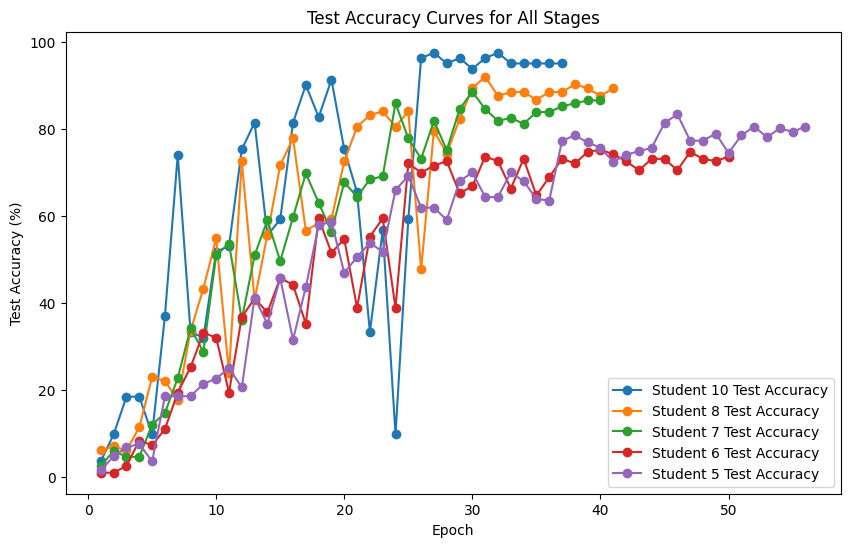

In [9]:
import math
import random
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from Bio import SeqIO
import matplotlib.pyplot as plt

# Set device
device = (
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

###################################
# 1. Data Preparation Functions
###################################

def parse_fasta_with_labels(fasta_file):
    data = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        header = record.description.strip()
        sequence = str(record.seq).upper()
        label = header.split()[0]
        data.append((label, sequence))
    return data

def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, seq in raw_data:
        label_to_samples[label].append(seq)
    train_data = []
    test_data = []
    for label, seqs in label_to_samples.items():
        random.shuffle(seqs)
        test_seq = seqs[0]
        train_seqs = seqs[1:]
        test_data.append((label, test_seq))
        for s in train_seqs:
            train_data.append((label, s))
    return train_data, test_data

def generate_kmers(sequence, k=6):
    kmers = []
    for i in range(len(sequence) - k + 1):
        kmers.append(sequence[i:i+k])
    return kmers

def build_kmer_vocab(dataset, k=6):
    kmer_set = set()
    for _, seq in dataset:
        kmers = generate_kmers(seq, k)
        kmer_set.update(kmers)
    vocab = {"<UNK>": 0}
    for i, kmer in enumerate(sorted(kmer_set), start=1):
        vocab[kmer] = i
    return vocab

def encode_sequence(sequence, vocab, k=6):
    kmers = generate_kmers(sequence, k)
    encoded = [vocab.get(kmer, vocab["<UNK>"]) for kmer in kmers]
    return encoded

def filter_classes(raw_data, min_count=5):
    label_counts = Counter([label for (label, _) in raw_data])
    filtered_data = [(label, seq) for (label, seq) in raw_data if label_counts[label] >= min_count]
    return filtered_data

def reverse_complement(seq):
    # For simplicity, we just reverse the sequence.
    return seq[::-1]

def create_paired_data(data_list):
    paired = []
    for label, seq in data_list:
        rev_seq = reverse_complement(seq)
        paired.append((label, seq, rev_seq))
    return paired

class TwoFastaKmerDataset(Dataset):
    """
    Each item: (encoded_seq_fwd, encoded_seq_rev, label_idx)
    """
    def __init__(self, paired_data, vocab, k=6):
        super().__init__()
        self.vocab = vocab
        self.k = k
        labels = sorted(set(item[0] for item in paired_data))
        self.label2idx = {lbl: i for i, lbl in enumerate(labels)}
        self.encoded_data = []
        for label, fwd_seq, rev_seq in paired_data:
            x1 = encode_sequence(fwd_seq, self.vocab, k=self.k)
            x2 = encode_sequence(rev_seq, self.vocab, k=self.k)
            y = self.label2idx[label]
            self.encoded_data.append((x1, x2, y))
    
    def __len__(self):
        return len(self.encoded_data)
    
    def __getitem__(self, idx):
        return self.encoded_data[idx]
    
    def get_vocab_size(self):
        return len(self.vocab)
    
    def get_num_classes(self):
        return len(self.label2idx)

def collate_fn_two(batch):
    seqs_fwd, seqs_rev, labels = zip(*batch)
    seqs_fwd_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_fwd]
    seqs_rev_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_rev]
    padded_fwd = pad_sequence(seqs_fwd_tensors, batch_first=True, padding_value=0)
    padded_rev = pad_sequence(seqs_rev_tensors, batch_first=True, padding_value=0)
    labels_tensors = torch.tensor(labels, dtype=torch.long)
    return padded_fwd, padded_rev, labels_tensors

###################################
# 2. Model Architecture
###################################

class ViTDeepSEAEncoder(nn.Module):
    """
    k-mer embedding, DeepSEA-style conv block, projection,
    positional embedding, Transformer encoding, and mean pooling.
    """
    def __init__(
        self,
        vocab_size,
        embed_dim=128,
        d_model=256,
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.2,
        max_seq_len=1000
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.deepsea_conv = nn.Sequential(
            nn.Conv1d(in_channels=embed_dim, out_channels=num_conv_filters[0], kernel_size=conv_kernel_sizes[0]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[0]),
            nn.Conv1d(in_channels=num_conv_filters[0], out_channels=num_conv_filters[1], kernel_size=conv_kernel_sizes[1]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[1]),
            nn.Conv1d(in_channels=num_conv_filters[1], out_channels=num_conv_filters[2], kernel_size=conv_kernel_sizes[2]),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.bn = nn.BatchNorm1d(num_conv_filters[2])
        self.proj = nn.Linear(num_conv_filters[2], d_model)
        self.max_tokens = 150
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.max_tokens, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
        self.final_norm = nn.LayerNorm(d_model)
        
    def forward(self, x):
        x = self.embedding(x)            # [B, seq_len, embed_dim]
        x = x.transpose(1, 2)            # [B, embed_dim, seq_len]
        x = self.deepsea_conv(x)         # [B, num_conv_filters[-1], L_out]
        x = self.bn(x)
        x = x.transpose(1, 2)            # [B, L_out, num_conv_filters[-1]]
        x = self.proj(x)                 # [B, L_out, d_model]
        B, L, _ = x.size()
        pos_embed = self.pos_embedding[:, :L, :]
        x = x + pos_embed
        x = self.transformer_encoder(x)
        x = self.final_norm(x)
        x = x.mean(dim=1)
        return x

class TwoViTDeepSEAFusionDNAClassifierWithFC(nn.Module):
    """
    Two-branch model: processes forward and reverse sequences,
    concatenates features, and applies a fully-connected layer.
    """
    def __init__(
        self,
        vocab_size,
        num_classes,
        embed_dim=128,
        d_model=256,
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.2,
        max_seq_len=1000
    ):
        super().__init__()
        self.vit_branch1 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        self.vit_branch2 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        self.fc = nn.Linear(2 * d_model, num_classes)
    
    def forward(self, x1, x2):
        f1 = self.vit_branch1(x1)
        f2 = self.vit_branch2(x2)
        fused = torch.cat([f1, f2], dim=1)
        logits = self.fc(fused)
        return logits

###################################
# Helper functions for overlapping classes in distillation
###################################

def get_overlapping_indices(teacher_label2idx, student_label2idx):
    """
    Returns two lists:
      - teacher_indices: indices in the teacher model corresponding to overlapping classes.
      - student_indices: indices in the student model corresponding to the same overlapping classes.
    """
    teacher_indices = []
    student_indices = []
    for label, t_idx in teacher_label2idx.items():
        if label in student_label2idx:
            teacher_indices.append(t_idx)
            student_indices.append(student_label2idx[label])
    return teacher_indices, student_indices

def distillation_loss(student_logits, teacher_logits, student_overlap, teacher_overlap, T):
    """
    Computes the KL divergence on the overlapping class dimensions only.
    
    student_logits: [B, num_student_classes]
    teacher_logits: [B, num_teacher_classes]
    student_overlap: list of indices in student logits for overlapping classes.
    teacher_overlap: list of indices in teacher logits for overlapping classes.
    T: temperature.
    """
    # Extract only the overlapping classes from the logits.
    s_overlap = student_logits[:, student_overlap]  # shape: [B, num_overlap]
    t_overlap = teacher_logits[:, teacher_overlap]  # shape: [B, num_overlap]
    
    return F.kl_div(F.log_softmax(s_overlap / T, dim=1),
                    F.softmax(t_overlap / T, dim=1),
                    reduction="batchmean") * (T * T)

###################################
# 5. Build Vocabulary and Datasets
###################################

fasta_file = "data2/fungi_ITS_cleaned.fasta"
raw_data = parse_fasta_with_labels(fasta_file)
vocab = build_kmer_vocab(raw_data, k=6)

###################################
# Stage 1: Student 10 Training (min_count >= 10)
###################################
student10_data = filter_classes(raw_data, min_count=10)
student10_train_data, student10_test_data = create_train_test_split(student10_data)
student10_paired_train = create_paired_data(student10_train_data)
student10_paired_test = create_paired_data(student10_test_data)
student10_dataset = TwoFastaKmerDataset(student10_paired_train, vocab, k=6)
student10_test_dataset = TwoFastaKmerDataset(student10_paired_test, vocab, k=6)

print("Student 10 classes (min_count>=10):")
for cls in student10_dataset.label2idx:
    print(cls)
print("Number of Student 10 classes:", student10_dataset.get_num_classes())

student10_train_loader = DataLoader(student10_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
student10_test_loader = DataLoader(student10_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_student10 = student10_dataset.get_num_classes()
vocab_size = student10_dataset.get_vocab_size()

student10_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student10,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320, 480, 960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

student10_epochs = 100
optimizer_student10 = optim.AdamW(student10_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler_student10 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_student10, mode='max', factor=0.5, patience=5, verbose=True)

best_student10_acc = 0.0
best_student10_state = None
patience = 10
patience_counter = 0

teacher_test_acc_list = []  # We'll later use Student 10 as teacher.

print("Starting Student 10 training (min_count>=10) with early stopping and LR scheduling...")
for epoch in range(1, student10_epochs + 1):
    student10_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student10_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student10.zero_grad()
        logits = student10_model(fwd, rev)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student10_model.parameters(), max_norm=1.0)
        optimizer_student10.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student10_train_loader)
    
    # Evaluate Student 10 accuracy.
    student10_model.eval()
    train_correct, train_total = 0, 0
    for fwd, rev, labels in student10_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        preds = torch.argmax(student10_model(fwd, rev), dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
    train_acc = 100.0 * train_correct / train_total

    test_correct, test_total = 0, 0
    for fwd, rev, labels in student10_test_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        preds = torch.argmax(student10_model(fwd, rev), dim=1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)
    test_acc = 100.0 * test_correct / test_total
    teacher_test_acc_list.append(test_acc)
    
    scheduler_student10.step(test_acc)
    
    print(f"[Student 10] Epoch {epoch}/{student10_epochs} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")
    
    if test_acc > best_student10_acc:
        best_student10_acc = test_acc
        best_student10_state = student10_model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch}.")
        break

student10_model.load_state_dict(best_student10_state)
for param in student10_model.parameters():
    param.requires_grad = False
student10_model.eval()
print(f"Best Student 10 Accuracy: {best_student10_acc:.2f}%")

###################################
# Stage 2: Student 8 Training with Distillation from Student 10 (min_count >= 8)
###################################
student8_data = filter_classes(raw_data, min_count=8)
student8_train_data, student8_test_data = create_train_test_split(student8_data)
student8_paired_train = create_paired_data(student8_train_data)
student8_paired_test = create_paired_data(student8_test_data)
student8_dataset = TwoFastaKmerDataset(student8_paired_train, vocab, k=6)
student8_test_dataset = TwoFastaKmerDataset(student8_paired_test, vocab, k=6)

print("\nStudent 8 classes (min_count>=8):")
for cls in student8_dataset.label2idx:
    print(cls)
print("Number of Student 8 classes:", student8_dataset.get_num_classes())

student8_train_loader = DataLoader(student8_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
student8_test_loader = DataLoader(student8_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_student8 = student8_dataset.get_num_classes()

student8_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student8,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer_student8 = optim.AdamW(student8_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Distillation hyperparameters.
temperature = 4.0
alpha = 0.5

# Get overlapping indices between Student 10 (teacher) and Student 8 (student).
teacher_overlap, student_overlap = get_overlapping_indices(student10_dataset.label2idx, student8_dataset.label2idx)
print("\nOverlapping classes for KD between Student 10 and Student 8:")
for label in student10_dataset.label2idx:
    if label in student8_dataset.label2idx:
        print(label)
print("Number of overlapping classes:", len(teacher_overlap))

student8_test_acc_list = []
scheduler_student8 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_student8, mode='max', factor=0.5, patience=5, verbose=True
)

student8_epochs = 100
best_student8_acc = 0.0
best_student8_state = None
patience_counter = 0

print("\nStarting Student 8 training with distillation from Student 10...")
for epoch in range(1, student8_epochs + 1):
    student8_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student8_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student8.zero_grad()
        student_logits = student8_model(fwd, rev)
        with torch.no_grad():
            teacher_logits = student10_model(fwd, rev)
        ce_loss = criterion(student_logits, labels)
        kd_loss = distillation_loss(student_logits, teacher_logits, student_overlap, teacher_overlap, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student8_model.parameters(), max_norm=1.0)
        optimizer_student8.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student8_train_loader)
    
    student8_model.eval()
    correct, total = 0, 0
    for fwd, rev, labels in student8_test_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        preds = torch.argmax(student8_model(fwd, rev), dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    test_acc = 100.0 * correct / total
    student8_test_acc_list.append(test_acc)
    
    scheduler_student8.step(test_acc)
    
    print(f"[Student 8] Epoch {epoch}/{student8_epochs} | Loss: {avg_loss:.4f} | Test Acc: {test_acc:.2f}%")
    
    if test_acc > best_student8_acc:
        best_student8_acc = test_acc
        best_student8_state = student8_model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch} for Student 8.")
        break

student8_model.load_state_dict(best_student8_state)
for param in student8_model.parameters():
    param.requires_grad = False
student8_model.eval()
print(f"\nHighest Student 8 Test Accuracy: {best_student8_acc:.2f}%")

###################################
# Stage 3: Student 7 Training with Distillation from Student 8 (min_count >= 7)
###################################
student7_data = filter_classes(raw_data, min_count=7)
student7_train_data, student7_test_data = create_train_test_split(student7_data)
student7_paired_train = create_paired_data(student7_train_data)
student7_paired_test = create_paired_data(student7_test_data)
student7_dataset = TwoFastaKmerDataset(student7_paired_train, vocab, k=6)
student7_test_dataset = TwoFastaKmerDataset(student7_paired_test, vocab, k=6)

print("\nStudent 7 classes (min_count>=7):")
for cls in student7_dataset.label2idx:
    print(cls)
print("Number of Student 7 classes:", student7_dataset.get_num_classes())

student7_train_loader = DataLoader(student7_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
student7_test_loader = DataLoader(student7_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_student7 = student7_dataset.get_num_classes()

student7_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student7,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer_student7 = optim.AdamW(student7_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

teacher_overlap_7, student_overlap_7 = get_overlapping_indices(student8_dataset.label2idx, student7_dataset.label2idx)
print("\nOverlapping classes for KD between Student 8 and Student 7:")
for label in student8_dataset.label2idx:
    if label in student7_dataset.label2idx:
        print(label)
print("Number of overlapping classes:", len(teacher_overlap_7))

student7_test_acc_list = []
scheduler_student7 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_student7, mode='max', factor=0.5, patience=5, verbose=True
)

student7_epochs = 100
best_student7_acc = 0.0
best_student7_state = None
patience_counter = 0

print("\nStarting Student 7 training with distillation from Student 8...")
for epoch in range(1, student7_epochs + 1):
    student7_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student7_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student7.zero_grad()
        student_logits = student7_model(fwd, rev)
        with torch.no_grad():
            teacher_logits = student8_model(fwd, rev)
        ce_loss = criterion(student_logits, labels)
        kd_loss = distillation_loss(student_logits, teacher_logits, student_overlap_7, teacher_overlap_7, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student7_model.parameters(), max_norm=1.0)
        optimizer_student7.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student7_train_loader)
    
    student7_model.eval()
    correct, total = 0, 0
    for fwd, rev, labels in student7_test_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        preds = torch.argmax(student7_model(fwd, rev), dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    test_acc = 100.0 * correct / total
    student7_test_acc_list.append(test_acc)
    
    scheduler_student7.step(test_acc)
    
    print(f"[Student 7] Epoch {epoch}/{student7_epochs} | Loss: {avg_loss:.4f} | Test Acc: {test_acc:.2f}%")
    
    if test_acc > best_student7_acc:
        best_student7_acc = test_acc
        best_student7_state = student7_model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch} for Student 7.")
        break

student7_model.load_state_dict(best_student7_state)
for param in student7_model.parameters():
    param.requires_grad = False
student7_model.eval()
print(f"\nHighest Student 7 Test Accuracy: {best_student7_acc:.2f}%")

###################################
# Stage 4: Student 6 Training with Distillation from Student 7 (min_count >= 6)
###################################
student6_data = filter_classes(raw_data, min_count=6)
student6_train_data, student6_test_data = create_train_test_split(student6_data)
student6_paired_train = create_paired_data(student6_train_data)
student6_paired_test = create_paired_data(student6_test_data)
student6_dataset = TwoFastaKmerDataset(student6_paired_train, vocab, k=6)
student6_test_dataset = TwoFastaKmerDataset(student6_paired_test, vocab, k=6)

print("\nStudent 6 classes (min_count>=6):")
for cls in student6_dataset.label2idx:
    print(cls)
print("Number of Student 6 classes:", student6_dataset.get_num_classes())

student6_train_loader = DataLoader(student6_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
student6_test_loader = DataLoader(student6_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_student6 = student6_dataset.get_num_classes()

student6_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student6,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer_student6 = optim.AdamW(student6_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

teacher_overlap_6, student_overlap_6 = get_overlapping_indices(student7_dataset.label2idx, student6_dataset.label2idx)
print("\nOverlapping classes for KD between Student 7 and Student 6:")
for label in student7_dataset.label2idx:
    if label in student6_dataset.label2idx:
        print(label)
print("Number of overlapping classes:", len(teacher_overlap_6))

student6_test_acc_list = []
scheduler_student6 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_student6, mode='max', factor=0.5, patience=5, verbose=True
)

student6_epochs = 100
best_student6_acc = 0.0
best_student6_state = None
patience_counter = 0

print("\nStarting Student 6 training with distillation from Student 7...")
for epoch in range(1, student6_epochs + 1):
    student6_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student6_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student6.zero_grad()
        student_logits = student6_model(fwd, rev)
        with torch.no_grad():
            teacher_logits = student7_model(fwd, rev)
        ce_loss = criterion(student_logits, labels)
        kd_loss = distillation_loss(student_logits, teacher_logits, student_overlap_6, teacher_overlap_6, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student6_model.parameters(), max_norm=1.0)
        optimizer_student6.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student6_train_loader)
    
    student6_model.eval()
    correct, total = 0, 0
    for fwd, rev, labels in student6_test_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        preds = torch.argmax(student6_model(fwd, rev), dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    test_acc = 100.0 * correct / total
    student6_test_acc_list.append(test_acc)
    
    scheduler_student6.step(test_acc)
    
    print(f"[Student 6] Epoch {epoch}/{student6_epochs} | Loss: {avg_loss:.4f} | Test Acc: {test_acc:.2f}%")
    
    if test_acc > best_student6_acc:
        best_student6_acc = test_acc
        best_student6_state = student6_model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch} for Student 6.")
        break

student6_model.load_state_dict(best_student6_state)
for param in student6_model.parameters():
    param.requires_grad = False
student6_model.eval()
print(f"\nHighest Student 6 Test Accuracy: {best_student6_acc:.2f}%")

###################################
# Stage 5: Student 5 Training with Distillation from Student 6 (min_count >= 5)
###################################
student5_data = filter_classes(raw_data, min_count=5)
student5_train_data, student5_test_data = create_train_test_split(student5_data)
student5_paired_train = create_paired_data(student5_train_data)
student5_paired_test = create_paired_data(student5_test_data)
student5_dataset = TwoFastaKmerDataset(student5_paired_train, vocab, k=6)
student5_test_dataset = TwoFastaKmerDataset(student5_paired_test, vocab, k=6)

print("\nStudent 5 classes (min_count>=5):")
for cls in student5_dataset.label2idx:
    print(cls)
print("Number of Student 5 classes:", student5_dataset.get_num_classes())

student5_train_loader = DataLoader(student5_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_two)
student5_test_loader = DataLoader(student5_test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_two)

num_classes_student5 = student5_dataset.get_num_classes()

student5_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student5,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer_student5 = optim.AdamW(student5_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

teacher_overlap_5, student_overlap_5 = get_overlapping_indices(student6_dataset.label2idx, student5_dataset.label2idx)
print("\nOverlapping classes for KD between Student 6 and Student 5:")
for label in student6_dataset.label2idx:
    if label in student5_dataset.label2idx:
        print(label)
print("Number of overlapping classes:", len(teacher_overlap_5))

student5_acc_list = []
scheduler_student5 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_student5, mode='max', factor=0.5, patience=5, verbose=True
)

student5_epochs = 100
best_student5_acc = 0.0
best_student5_state = None
patience_counter = 0

print("\nStarting Student 5 training with distillation from Student 6...")
for epoch in range(1, student5_epochs + 1):
    student5_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student5_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student5.zero_grad()
        student_logits = student5_model(fwd, rev)
        with torch.no_grad():
            teacher_logits = student6_model(fwd, rev)
        ce_loss = criterion(student_logits, labels)
        kd_loss = distillation_loss(student_logits, teacher_logits, student_overlap_5, teacher_overlap_5, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student5_model.parameters(), max_norm=1.0)
        optimizer_student5.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student5_train_loader)
    
    student5_model.eval()
    correct, total = 0, 0
    for fwd, rev, labels in student5_test_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        preds = torch.argmax(student5_model(fwd, rev), dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    test_acc = 100.0 * correct / total
    student5_acc_list.append(test_acc)
    
    scheduler_student5.step(test_acc)
    
    print(f"[Student 5] Epoch {epoch}/{student5_epochs} | Loss: {avg_loss:.4f} | Test Acc: {test_acc:.2f}%")
    
    if test_acc > best_student5_acc:
        best_student5_acc = test_acc
        best_student5_state = student5_model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch} for Student 5.")
        break

student5_model.load_state_dict(best_student5_state)
for param in student5_model.parameters():
    param.requires_grad = False
student5_model.eval()
print(f"\nHighest Student 5 Test Accuracy: {best_student5_acc:.2f}% at final epoch")

###################################
# 6. Plotting Test Accuracy Curves
###################################
plt.figure(figsize=(10,6))
plt.plot(range(1, len(teacher_test_acc_list)+1), teacher_test_acc_list, label="Student 10 Test Accuracy", marker="o")
plt.plot(range(1, len(student8_test_acc_list)+1), student8_test_acc_list, label="Student 8 Test Accuracy", marker="o")
plt.plot(range(1, len(student7_test_acc_list)+1), student7_test_acc_list, label="Student 7 Test Accuracy", marker="o")
plt.plot(range(1, len(student6_test_acc_list)+1), student6_test_acc_list, label="Student 6 Test Accuracy", marker="o")
plt.plot(range(1, len(student5_acc_list)+1), student5_acc_list, label="Student 5 Test Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy Curves for All Stages")
plt.legend()
plt.show()


# with best teacher acc ---- no early stopping for 6 and 5, increase batch size, 83%

Student 10 classes (min_count>=10):
Absidia
Amanita
Apiospora
Arthroderma
Aspergillus
Backusella
Bambusicola
Blastobotrys
Boletus
Candida
Cantharellus
Cladophialophora
Clavaria
Clavulina
Colacogloea
Coprinopsis
Cortinarius
Crepidotus
Cyberlindnera
Cyphellophora
Elsinoe
Entoloma
Exophiala
Fomitiporia
Geastrum
Genea
Gymnopus
Hydnellum
Hygrocybe
Hygrophorus
Hymenochaete
Hypoxylon
Inocybe
Inosperma
Kazachstania
Lactarius
Lactifluus
Lecanora
Lepiota
Leucoagaricus
Lipomyces
Malassezia
Marasmius
Metschnikowia
Mortierella
Mucor
Mycena
Ogataea
Ophiocordyceps
Orbilia
Otidea
Perenniporia
Phylloporus
Phyllosticta
Pichia
Pluteus
Pseudosperma
Raffaelea
Ramaria
Roussoella
Russula
Saccharomycopsis
Saturnispora
Scolecobasidium
Scytinostroma
Spathaspora
Starmerella
Sugiyamaella
Suhomyces
Talaromyces
Tomentella
Trechispora
Tremella
Trichoderma
Tricholoma
Tuber
Verrucaria
Wickerhamiella
Wickerhamomyces
Xylaria
Xylodon
Number of Student 10 classes: 81
Starting Student 10 training (min_count>=10) with early

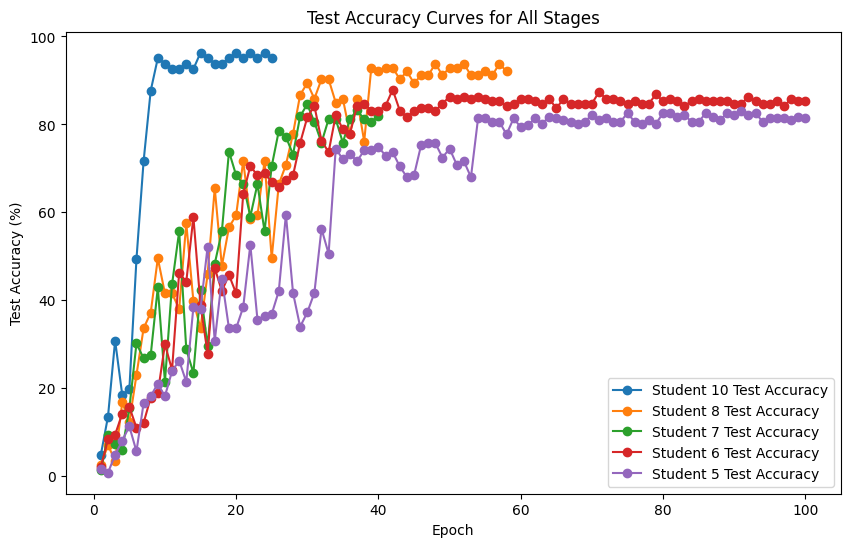

In [10]:
import math
import random
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from Bio import SeqIO
import matplotlib.pyplot as plt

# Set device
device = (
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

###################################
# 1. Data Preparation Functions
###################################

def parse_fasta_with_labels(fasta_file):
    data = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        header = record.description.strip()
        sequence = str(record.seq).upper()
        label = header.split()[0]
        data.append((label, sequence))
    return data

def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, seq in raw_data:
        label_to_samples[label].append(seq)
    train_data = []
    test_data = []
    for label, seqs in label_to_samples.items():
        random.shuffle(seqs)
        test_seq = seqs[0]
        train_seqs = seqs[1:]
        test_data.append((label, test_seq))
        for s in train_seqs:
            train_data.append((label, s))
    return train_data, test_data

def generate_kmers(sequence, k=6):
    kmers = []
    for i in range(len(sequence) - k + 1):
        kmers.append(sequence[i:i+k])
    return kmers

def build_kmer_vocab(dataset, k=6):
    kmer_set = set()
    for _, seq in dataset:
        kmers = generate_kmers(seq, k)
        kmer_set.update(kmers)
    vocab = {"<UNK>": 0}
    for i, kmer in enumerate(sorted(kmer_set), start=1):
        vocab[kmer] = i
    return vocab

def encode_sequence(sequence, vocab, k=6):
    kmers = generate_kmers(sequence, k)
    encoded = [vocab.get(kmer, vocab["<UNK>"]) for kmer in kmers]
    return encoded

def filter_classes(raw_data, min_count=5):
    label_counts = Counter([label for (label, _) in raw_data])
    filtered_data = [(label, seq) for (label, seq) in raw_data if label_counts[label] >= min_count]
    return filtered_data

def reverse_complement(seq):
    # For simplicity, we just reverse the sequence.
    return seq[::-1]

def create_paired_data(data_list):
    paired = []
    for label, seq in data_list:
        rev_seq = reverse_complement(seq)
        paired.append((label, seq, rev_seq))
    return paired

class TwoFastaKmerDataset(Dataset):
    """
    Each item: (encoded_seq_fwd, encoded_seq_rev, label_idx)
    """
    def __init__(self, paired_data, vocab, k=6):
        super().__init__()
        self.vocab = vocab
        self.k = k
        labels = sorted(set(item[0] for item in paired_data))
        self.label2idx = {lbl: i for i, lbl in enumerate(labels)}
        self.encoded_data = []
        for label, fwd_seq, rev_seq in paired_data:
            x1 = encode_sequence(fwd_seq, self.vocab, k=self.k)
            x2 = encode_sequence(rev_seq, self.vocab, k=self.k)
            y = self.label2idx[label]
            self.encoded_data.append((x1, x2, y))
    
    def __len__(self):
        return len(self.encoded_data)
    
    def __getitem__(self, idx):
        return self.encoded_data[idx]
    
    def get_vocab_size(self):
        return len(self.vocab)
    
    def get_num_classes(self):
        return len(self.label2idx)

def collate_fn_two(batch):
    seqs_fwd, seqs_rev, labels = zip(*batch)
    seqs_fwd_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_fwd]
    seqs_rev_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_rev]
    padded_fwd = pad_sequence(seqs_fwd_tensors, batch_first=True, padding_value=0)
    padded_rev = pad_sequence(seqs_rev_tensors, batch_first=True, padding_value=0)
    labels_tensors = torch.tensor(labels, dtype=torch.long)
    return padded_fwd, padded_rev, labels_tensors

###################################
# 2. Model Architecture
###################################

class ViTDeepSEAEncoder(nn.Module):
    """
    k-mer embedding, DeepSEA-style conv block, projection,
    positional embedding, Transformer encoding, and mean pooling.
    """
    def __init__(
        self,
        vocab_size,
        embed_dim=128,
        d_model=256,
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.2,
        max_seq_len=1000
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.deepsea_conv = nn.Sequential(
            nn.Conv1d(in_channels=embed_dim, out_channels=num_conv_filters[0], kernel_size=conv_kernel_sizes[0]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[0]),
            nn.Conv1d(in_channels=num_conv_filters[0], out_channels=num_conv_filters[1], kernel_size=conv_kernel_sizes[1]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[1]),
            nn.Conv1d(in_channels=num_conv_filters[1], out_channels=num_conv_filters[2], kernel_size=conv_kernel_sizes[2]),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.bn = nn.BatchNorm1d(num_conv_filters[2])
        self.proj = nn.Linear(num_conv_filters[2], d_model)
        self.max_tokens = 150
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.max_tokens, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
        self.final_norm = nn.LayerNorm(d_model)
        
    def forward(self, x):
        x = self.embedding(x)            # [B, seq_len, embed_dim]
        x = x.transpose(1, 2)            # [B, embed_dim, seq_len]
        x = self.deepsea_conv(x)         # [B, num_conv_filters[-1], L_out]
        x = self.bn(x)
        x = x.transpose(1, 2)            # [B, L_out, num_conv_filters[-1]]
        x = self.proj(x)                 # [B, L_out, d_model]
        B, L, _ = x.size()
        pos_embed = self.pos_embedding[:, :L, :]
        x = x + pos_embed
        x = self.transformer_encoder(x)
        x = self.final_norm(x)
        x = x.mean(dim=1)
        return x

class TwoViTDeepSEAFusionDNAClassifierWithFC(nn.Module):
    """
    Two-branch model: processes forward and reverse sequences,
    concatenates features, and applies a fully-connected layer.
    """
    def __init__(
        self,
        vocab_size,
        num_classes,
        embed_dim=128,
        d_model=256,
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.2,
        max_seq_len=1000
    ):
        super().__init__()
        self.vit_branch1 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        self.vit_branch2 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        self.fc = nn.Linear(2 * d_model, num_classes)
    
    def forward(self, x1, x2):
        f1 = self.vit_branch1(x1)
        f2 = self.vit_branch2(x2)
        fused = torch.cat([f1, f2], dim=1)
        logits = self.fc(fused)
        return logits

###################################
# Helper functions for overlapping classes in distillation
###################################

def get_overlapping_indices(teacher_label2idx, student_label2idx):
    """
    Returns two lists:
      - teacher_indices: indices in the teacher model corresponding to overlapping classes.
      - student_indices: indices in the student model corresponding to the same overlapping classes.
    """
    teacher_indices = []
    student_indices = []
    for label, t_idx in teacher_label2idx.items():
        if label in student_label2idx:
            teacher_indices.append(t_idx)
            student_indices.append(student_label2idx[label])
    return teacher_indices, student_indices

def distillation_loss(student_logits, teacher_logits, student_overlap, teacher_overlap, T):
    """
    Computes the KL divergence on the overlapping class dimensions only.
    
    student_logits: [B, num_student_classes]
    teacher_logits: [B, num_teacher_classes]
    student_overlap: list of indices in student logits for overlapping classes.
    teacher_overlap: list of indices in teacher logits for overlapping classes.
    T: temperature.
    """
    s_overlap = student_logits[:, student_overlap]  # shape: [B, num_overlap]
    t_overlap = teacher_logits[:, teacher_overlap]  # shape: [B, num_overlap]
    
    return F.kl_div(F.log_softmax(s_overlap / T, dim=1),
                    F.softmax(t_overlap / T, dim=1),
                    reduction="batchmean") * (T * T)

###################################
# 5. Build Vocabulary and Datasets
###################################

fasta_file = "data2/fungi_ITS_cleaned.fasta"
raw_data = parse_fasta_with_labels(fasta_file)
vocab = build_kmer_vocab(raw_data, k=6)

###################################
# Stage 1: Student 10 Training (min_count >= 10)
###################################
student10_data = filter_classes(raw_data, min_count=10)
student10_train_data, student10_test_data = create_train_test_split(student10_data)
student10_paired_train = create_paired_data(student10_train_data)
student10_paired_test = create_paired_data(student10_test_data)
student10_dataset = TwoFastaKmerDataset(student10_paired_train, vocab, k=6)
student10_test_dataset = TwoFastaKmerDataset(student10_paired_test, vocab, k=6)

print("Student 10 classes (min_count>=10):")
for cls in student10_dataset.label2idx:
    print(cls)
print("Number of Student 10 classes:", student10_dataset.get_num_classes())

# Change batch size to 16 here.
student10_train_loader = DataLoader(student10_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn_two)
student10_test_loader = DataLoader(student10_test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn_two)

num_classes_student10 = student10_dataset.get_num_classes()
vocab_size = student10_dataset.get_vocab_size()

student10_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student10,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320, 480, 960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

student10_epochs = 100
optimizer_student10 = optim.AdamW(student10_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler_student10 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_student10, mode='max', factor=0.5, patience=5, verbose=True)

best_student10_acc = 0.0
best_student10_state = None
patience = 10
patience_counter = 0

teacher_test_acc_list = []  # Will be used later for distillation.

print("Starting Student 10 training (min_count>=10) with early stopping and LR scheduling...")
for epoch in range(1, student10_epochs + 1):
    student10_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student10_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student10.zero_grad()
        logits = student10_model(fwd, rev)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student10_model.parameters(), max_norm=1.0)
        optimizer_student10.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student10_train_loader)
    
    student10_model.eval()
    train_correct, train_total = 0, 0
    for fwd, rev, labels in student10_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        preds = torch.argmax(student10_model(fwd, rev), dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
    train_acc = 100.0 * train_correct / train_total

    test_correct, test_total = 0, 0
    for fwd, rev, labels in student10_test_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        preds = torch.argmax(student10_model(fwd, rev), dim=1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)
    test_acc = 100.0 * test_correct / test_total
    teacher_test_acc_list.append(test_acc)
    
    scheduler_student10.step(test_acc)
    
    print(f"[Student 10] Epoch {epoch}/{student10_epochs} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")
    
    if test_acc > best_student10_acc:
        best_student10_acc = test_acc
        best_student10_state = student10_model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch}.")
        break

student10_model.load_state_dict(best_student10_state)
for param in student10_model.parameters():
    param.requires_grad = False
student10_model.eval()
print(f"Best Student 10 Accuracy: {best_student10_acc:.2f}%")

###################################
# Stage 2: Student 8 Training with Distillation from Student 10 (min_count >= 8)
###################################
student8_data = filter_classes(raw_data, min_count=8)
student8_train_data, student8_test_data = create_train_test_split(student8_data)
student8_paired_train = create_paired_data(student8_train_data)
student8_paired_test = create_paired_data(student8_test_data)
student8_dataset = TwoFastaKmerDataset(student8_paired_train, vocab, k=6)
student8_test_dataset = TwoFastaKmerDataset(student8_paired_test, vocab, k=6)

print("\nStudent 8 classes (min_count>=8):")
for cls in student8_dataset.label2idx:
    print(cls)
print("Number of Student 8 classes:", student8_dataset.get_num_classes())

student8_train_loader = DataLoader(student8_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn_two)
student8_test_loader = DataLoader(student8_test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn_two)

num_classes_student8 = student8_dataset.get_num_classes()

student8_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student8,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer_student8 = optim.AdamW(student8_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Distillation hyperparameters.
temperature = 4.0
alpha = 0.5

teacher_overlap, student_overlap = get_overlapping_indices(student10_dataset.label2idx, student8_dataset.label2idx)
print("\nOverlapping classes for KD between Student 10 and Student 8:")
for label in student10_dataset.label2idx:
    if label in student8_dataset.label2idx:
        print(label)
print("Number of overlapping classes:", len(teacher_overlap))

student8_test_acc_list = []
scheduler_student8 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_student8, mode='max', factor=0.5, patience=5, verbose=True
)

student8_epochs = 100
best_student8_acc = 0.0
best_student8_state = None
patience_counter = 0

print("\nStarting Student 8 training with distillation from Student 10...")
for epoch in range(1, student8_epochs + 1):
    student8_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student8_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student8.zero_grad()
        student_logits = student8_model(fwd, rev)
        with torch.no_grad():
            teacher_logits = student10_model(fwd, rev)
        ce_loss = criterion(student_logits, labels)
        kd_loss = distillation_loss(student_logits, teacher_logits, student_overlap, teacher_overlap, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student8_model.parameters(), max_norm=1.0)
        optimizer_student8.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student8_train_loader)
    
    student8_model.eval()
    correct, total = 0, 0
    for fwd, rev, labels in student8_test_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        preds = torch.argmax(student8_model(fwd, rev), dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    test_acc = 100.0 * correct / total
    student8_test_acc_list.append(test_acc)
    
    scheduler_student8.step(test_acc)
    
    print(f"[Student 8] Epoch {epoch}/{student8_epochs} | Loss: {avg_loss:.4f} | Test Acc: {test_acc:.2f}%")
    
    if test_acc > best_student8_acc:
        best_student8_acc = test_acc
        best_student8_state = student8_model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch} for Student 8.")
        break

student8_model.load_state_dict(best_student8_state)
for param in student8_model.parameters():
    param.requires_grad = False
student8_model.eval()
print(f"\nHighest Student 8 Test Accuracy: {best_student8_acc:.2f}%")

###################################
# Stage 3: Student 7 Training with Distillation from Student 8 (min_count >= 7)
###################################
student7_data = filter_classes(raw_data, min_count=7)
student7_train_data, student7_test_data = create_train_test_split(student7_data)
student7_paired_train = create_paired_data(student7_train_data)
student7_paired_test = create_paired_data(student7_test_data)
student7_dataset = TwoFastaKmerDataset(student7_paired_train, vocab, k=6)
student7_test_dataset = TwoFastaKmerDataset(student7_paired_test, vocab, k=6)

print("\nStudent 7 classes (min_count>=7):")
for cls in student7_dataset.label2idx:
    print(cls)
print("Number of Student 7 classes:", student7_dataset.get_num_classes())

student7_train_loader = DataLoader(student7_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn_two)
student7_test_loader = DataLoader(student7_test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn_two)

num_classes_student7 = student7_dataset.get_num_classes()

student7_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student7,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer_student7 = optim.AdamW(student7_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

teacher_overlap_7, student_overlap_7 = get_overlapping_indices(student8_dataset.label2idx, student7_dataset.label2idx)
print("\nOverlapping classes for KD between Student 8 and Student 7:")
for label in student8_dataset.label2idx:
    if label in student7_dataset.label2idx:
        print(label)
print("Number of overlapping classes:", len(teacher_overlap_7))

student7_test_acc_list = []
scheduler_student7 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_student7, mode='max', factor=0.5, patience=5, verbose=True
)

student7_epochs = 100
best_student7_acc = 0.0
best_student7_state = None
patience_counter = 0

print("\nStarting Student 7 training with distillation from Student 8...")
for epoch in range(1, student7_epochs + 1):
    student7_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student7_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student7.zero_grad()
        student_logits = student7_model(fwd, rev)
        with torch.no_grad():
            teacher_logits = student8_model(fwd, rev)
        ce_loss = criterion(student_logits, labels)
        kd_loss = distillation_loss(student_logits, teacher_logits, student_overlap_7, teacher_overlap_7, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student7_model.parameters(), max_norm=1.0)
        optimizer_student7.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student7_train_loader)
    
    student7_model.eval()
    correct, total = 0, 0
    for fwd, rev, labels in student7_test_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        preds = torch.argmax(student7_model(fwd, rev), dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    test_acc = 100.0 * correct / total
    student7_test_acc_list.append(test_acc)
    
    scheduler_student7.step(test_acc)
    
    print(f"[Student 7] Epoch {epoch}/{student7_epochs} | Loss: {avg_loss:.4f} | Test Acc: {test_acc:.2f}%")
    
    if test_acc > best_student7_acc:
        best_student7_acc = test_acc
        best_student7_state = student7_model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch} for Student 7.")
        break

student7_model.load_state_dict(best_student7_state)
for param in student7_model.parameters():
    param.requires_grad = False
student7_model.eval()
print(f"\nHighest Student 7 Test Accuracy: {best_student7_acc:.2f}%")

###################################
# Stage 4: Student 6 Training with Distillation from Student 7 (min_count >= 6)
###################################
student6_data = filter_classes(raw_data, min_count=6)
student6_train_data, student6_test_data = create_train_test_split(student6_data)
student6_paired_train = create_paired_data(student6_train_data)
student6_paired_test = create_paired_data(student6_test_data)
student6_dataset = TwoFastaKmerDataset(student6_paired_train, vocab, k=6)
student6_test_dataset = TwoFastaKmerDataset(student6_paired_test, vocab, k=6)

print("\nStudent 6 classes (min_count>=6):")
for cls in student6_dataset.label2idx:
    print(cls)
print("Number of Student 6 classes:", student6_dataset.get_num_classes())

student6_train_loader = DataLoader(student6_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn_two)
student6_test_loader = DataLoader(student6_test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn_two)

num_classes_student6 = student6_dataset.get_num_classes()

student6_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student6,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer_student6 = optim.AdamW(student6_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

teacher_overlap_6, student_overlap_6 = get_overlapping_indices(student7_dataset.label2idx, student6_dataset.label2idx)
print("\nOverlapping classes for KD between Student 7 and Student 6:")
for label in student7_dataset.label2idx:
    if label in student6_dataset.label2idx:
        print(label)
print("Number of overlapping classes:", len(teacher_overlap_6))

student6_test_acc_list = []
scheduler_student6 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_student6, mode='max', factor=0.5, patience=5, verbose=True
)

student6_epochs = 100
best_student6_acc = 0.0
best_student6_state = None

print("\nStarting Student 6 training with distillation from Student 7...")
for epoch in range(1, student6_epochs + 1):
    student6_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student6_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student6.zero_grad()
        student_logits = student6_model(fwd, rev)
        with torch.no_grad():
            teacher_logits = student7_model(fwd, rev)
        ce_loss = criterion(student_logits, labels)
        kd_loss = distillation_loss(student_logits, teacher_logits, student_overlap_6, teacher_overlap_6, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student6_model.parameters(), max_norm=1.0)
        optimizer_student6.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student6_train_loader)
    
    student6_model.eval()
    correct, total = 0, 0
    for fwd, rev, labels in student6_test_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        preds = torch.argmax(student6_model(fwd, rev), dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    test_acc = 100.0 * correct / total
    student6_test_acc_list.append(test_acc)
    
    scheduler_student6.step(test_acc)
    
    print(f"[Student 6] Epoch {epoch}/{student6_epochs} | Loss: {avg_loss:.4f} | Test Acc: {test_acc:.2f}%")
    
    if test_acc > best_student6_acc:
        best_student6_acc = test_acc
        best_student6_state = student6_model.state_dict()

student6_model.load_state_dict(best_student6_state)
for param in student6_model.parameters():
    param.requires_grad = False
student6_model.eval()
print(f"\nHighest Student 6 Test Accuracy: {best_student6_acc:.2f}%")

###################################
# Stage 5: Student 5 Training with Distillation from Student 6 (min_count >= 5)
###################################
student5_data = filter_classes(raw_data, min_count=5)
student5_train_data, student5_test_data = create_train_test_split(student5_data)
student5_paired_train = create_paired_data(student5_train_data)
student5_paired_test = create_paired_data(student5_test_data)
student5_dataset = TwoFastaKmerDataset(student5_paired_train, vocab, k=6)
student5_test_dataset = TwoFastaKmerDataset(student5_paired_test, vocab, k=6)

print("\nStudent 5 classes (min_count>=5):")
for cls in student5_dataset.label2idx:
    print(cls)
print("Number of Student 5 classes:", student5_dataset.get_num_classes())

student5_train_loader = DataLoader(student5_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn_two)
student5_test_loader = DataLoader(student5_test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn_two)

num_classes_student5 = student5_dataset.get_num_classes()

student5_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student5,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer_student5 = optim.AdamW(student5_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

teacher_overlap_5, student_overlap_5 = get_overlapping_indices(student6_dataset.label2idx, student5_dataset.label2idx)
print("\nOverlapping classes for KD between Student 6 and Student 5:")
for label in student6_dataset.label2idx:
    if label in student5_dataset.label2idx:
        print(label)
print("Number of overlapping classes:", len(teacher_overlap_5))

student5_acc_list = []
scheduler_student5 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_student5, mode='max', factor=0.5, patience=5, verbose=True
)

student5_epochs = 100
best_student5_acc = 0.0
best_student5_state = None

print("\nStarting Student 5 training with distillation from Student 6...")
for epoch in range(1, student5_epochs + 1):
    student5_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student5_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student5.zero_grad()
        student_logits = student5_model(fwd, rev)
        with torch.no_grad():
            teacher_logits = student6_model(fwd, rev)
        ce_loss = criterion(student_logits, labels)
        kd_loss = distillation_loss(student_logits, teacher_logits, student_overlap_5, teacher_overlap_5, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student5_model.parameters(), max_norm=1.0)
        optimizer_student5.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student5_train_loader)
    
    student5_model.eval()
    correct, total = 0, 0
    for fwd, rev, labels in student5_test_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        preds = torch.argmax(student5_model(fwd, rev), dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    test_acc = 100.0 * correct / total
    student5_acc_list.append(test_acc)
    
    scheduler_student5.step(test_acc)
    
    print(f"[Student 5] Epoch {epoch}/{student5_epochs} | Loss: {avg_loss:.4f} | Test Acc: {test_acc:.2f}%")
    
    if test_acc > best_student5_acc:
        best_student5_acc = test_acc
        best_student5_state = student5_model.state_dict()

student5_model.load_state_dict(best_student5_state)
for param in student5_model.parameters():
    param.requires_grad = False
student5_model.eval()
print(f"\nHighest Student 5 Test Accuracy: {best_student5_acc:.2f}% at final epoch")

###################################
# 6. Plotting Test Accuracy Curves
###################################
plt.figure(figsize=(10,6))
plt.plot(range(1, len(teacher_test_acc_list)+1), teacher_test_acc_list, label="Student 10 Test Accuracy", marker="o")
plt.plot(range(1, len(student8_test_acc_list)+1), student8_test_acc_list, label="Student 8 Test Accuracy", marker="o")
plt.plot(range(1, len(student7_test_acc_list)+1), student7_test_acc_list, label="Student 7 Test Accuracy", marker="o")
plt.plot(range(1, len(student6_test_acc_list)+1), student6_test_acc_list, label="Student 6 Test Accuracy", marker="o")
plt.plot(range(1, len(student5_acc_list)+1), student5_acc_list, label="Student 5 Test Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy Curves for All Stages")
plt.legend()
plt.show()


# with best teacher acc ---- no early stopping for 6 and 5, increase batch size, with data augmentation

In [ ]:
import math
import random
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from Bio import SeqIO
import matplotlib.pyplot as plt

# Set device
device = (
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

###################################
# Data Augmentation Function
###################################
def augment_sequence(seq, mutation_rate=0.1):
    """
    Randomly mutates each nucleotide with probability mutation_rate.
    """
    bases = ['A', 'C', 'G', 'T']
    seq_list = list(seq)
    for i, base in enumerate(seq_list):
        if random.random() < mutation_rate:
            # Choose a new base different from the current base.
            seq_list[i] = random.choice([b for b in bases if b != base])
    return "".join(seq_list)

###################################
# 1. Data Preparation Functions
###################################

def parse_fasta_with_labels(fasta_file):
    data = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        header = record.description.strip()
        sequence = str(record.seq).upper()
        label = header.split()[0]
        data.append((label, sequence))
    return data

def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, seq in raw_data:
        label_to_samples[label].append(seq)
    train_data = []
    test_data = []
    for label, seqs in label_to_samples.items():
        random.shuffle(seqs)
        test_seq = seqs[0]
        train_seqs = seqs[1:]
        test_data.append((label, test_seq))
        for s in train_seqs:
            train_data.append((label, s))
    return train_data, test_data

def generate_kmers(sequence, k=6):
    kmers = []
    for i in range(len(sequence) - k + 1):
        kmers.append(sequence[i:i+k])
    return kmers

def build_kmer_vocab(dataset, k=6):
    kmer_set = set()
    for _, seq in dataset:
        kmers = generate_kmers(seq, k)
        kmer_set.update(kmers)
    vocab = {"<UNK>": 0}
    for i, kmer in enumerate(sorted(kmer_set), start=1):
        vocab[kmer] = i
    return vocab

def encode_sequence(sequence, vocab, k=6):
    kmers = generate_kmers(sequence, k)
    encoded = [vocab.get(kmer, vocab["<UNK>"]) for kmer in kmers]
    return encoded

def filter_classes(raw_data, min_count=5):
    label_counts = Counter([label for (label, _) in raw_data])
    filtered_data = [(label, seq) for (label, seq) in raw_data if label_counts[label] >= min_count]
    return filtered_data

def reverse_complement(seq):
    # For simplicity, we simply reverse the sequence.
    return seq[::-1]

def create_paired_data(data_list):
    """
    Returns a list of tuples: (label, forward_seq, reverse_seq)
    Note that augmentation is now done on-the-fly in the Dataset.
    """
    paired = []
    for label, seq in data_list:
        # Initially, we store the original sequence.
        paired.append((label, seq, reverse_complement(seq)))
    return paired

###################################
# 2. Dataset with Optional Augmentation
###################################

class TwoFastaKmerDataset(Dataset):
    """
    Each item: (encoded_seq_fwd, encoded_seq_rev, label_idx)
    If 'augment' is True, the forward sequence is augmented on-the-fly 
    (and the reverse branch is recomputed as the reverse complement of the augmented sequence).
    """
    def __init__(self, paired_data, vocab, k=6, augment=False):
        super().__init__()
        self.vocab = vocab
        self.k = k
        self.augment = augment
        self.data = paired_data  # List of tuples: (label, fwd_seq, rev_seq)
        labels = sorted(set(item[0] for item in self.data))
        self.label2idx = {lbl: i for i, lbl in enumerate(labels)}
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        label, fwd_seq, _ = self.data[idx]
        # If augmentation is enabled, randomly mutate the forward sequence.
        if self.augment:
            fwd_seq = augment_sequence(fwd_seq, mutation_rate=0.1)
        # Always recompute the reverse branch from the (possibly augmented) forward sequence.
        rev_seq = reverse_complement(fwd_seq)
        encoded_fwd = encode_sequence(fwd_seq, self.vocab, k=self.k)
        encoded_rev = encode_sequence(rev_seq, self.vocab, k=self.k)
        label_idx = self.label2idx[label]
        return encoded_fwd, encoded_rev, label_idx
    
    def get_vocab_size(self):
        return len(self.vocab)
    
    def get_num_classes(self):
        return len(self.label2idx)

def collate_fn_two(batch):
    seqs_fwd, seqs_rev, labels = zip(*batch)
    seqs_fwd_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_fwd]
    seqs_rev_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_rev]
    padded_fwd = pad_sequence(seqs_fwd_tensors, batch_first=True, padding_value=0)
    padded_rev = pad_sequence(seqs_rev_tensors, batch_first=True, padding_value=0)
    labels_tensors = torch.tensor(labels, dtype=torch.long)
    return padded_fwd, padded_rev, labels_tensors

###################################
# 3. Model Architecture
###################################

class ViTDeepSEAEncoder(nn.Module):
    """
    k-mer embedding, DeepSEA-style conv block, projection,
    positional embedding, Transformer encoding, and mean pooling.
    """
    def __init__(
        self,
        vocab_size,
        embed_dim=128,
        d_model=256,
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.2,
        max_seq_len=1000
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.deepsea_conv = nn.Sequential(
            nn.Conv1d(in_channels=embed_dim, out_channels=num_conv_filters[0], kernel_size=conv_kernel_sizes[0]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[0]),
            nn.Conv1d(in_channels=num_conv_filters[0], out_channels=num_conv_filters[1], kernel_size=conv_kernel_sizes[1]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[1]),
            nn.Conv1d(in_channels=num_conv_filters[1], out_channels=num_conv_filters[2], kernel_size=conv_kernel_sizes[2]),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.bn = nn.BatchNorm1d(num_conv_filters[2])
        self.proj = nn.Linear(num_conv_filters[2], d_model)
        self.max_tokens = 150
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.max_tokens, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
        self.final_norm = nn.LayerNorm(d_model)
        
    def forward(self, x):
        x = self.embedding(x)            # [B, seq_len, embed_dim]
        x = x.transpose(1, 2)            # [B, embed_dim, seq_len]
        x = self.deepsea_conv(x)         # [B, num_conv_filters[-1], L_out]
        x = self.bn(x)
        x = x.transpose(1, 2)            # [B, L_out, num_conv_filters[-1]]
        x = self.proj(x)                 # [B, L_out, d_model]
        B, L, _ = x.size()
        pos_embed = self.pos_embedding[:, :L, :]
        x = x + pos_embed
        x = self.transformer_encoder(x)
        x = self.final_norm(x)
        x = x.mean(dim=1)
        return x

class TwoViTDeepSEAFusionDNAClassifierWithFC(nn.Module):
    """
    Two-branch model: processes forward and reverse sequences,
    concatenates features, and applies a fully-connected layer.
    """
    def __init__(
        self,
        vocab_size,
        num_classes,
        embed_dim=128,
        d_model=256,
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.2,
        max_seq_len=1000
    ):
        super().__init__()
        self.vit_branch1 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        self.vit_branch2 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        self.fc = nn.Linear(2 * d_model, num_classes)
    
    def forward(self, x1, x2):
        f1 = self.vit_branch1(x1)
        f2 = self.vit_branch2(x2)
        fused = torch.cat([f1, f2], dim=1)
        logits = self.fc(fused)
        return logits

###################################
# 4. Helper Functions for Distillation
###################################

def get_overlapping_indices(teacher_label2idx, student_label2idx):
    teacher_indices = []
    student_indices = []
    for label, t_idx in teacher_label2idx.items():
        if label in student_label2idx:
            teacher_indices.append(t_idx)
            student_indices.append(student_label2idx[label])
    return teacher_indices, student_indices

def distillation_loss(student_logits, teacher_logits, student_overlap, teacher_overlap, T):
    s_overlap = student_logits[:, student_overlap]  # [B, num_overlap]
    t_overlap = teacher_logits[:, teacher_overlap]  # [B, num_overlap]
    return F.kl_div(F.log_softmax(s_overlap / T, dim=1),
                    F.softmax(t_overlap / T, dim=1),
                    reduction="batchmean") * (T * T)

###################################
# 5. Build Vocabulary and Datasets
###################################

fasta_file = "data2/fungi_ITS_cleaned.fasta"
raw_data = parse_fasta_with_labels(fasta_file)
vocab = build_kmer_vocab(raw_data, k=6)

###################################
# Stage 1: Student 10 Training (min_count >= 10)
###################################
student10_data = filter_classes(raw_data, min_count=10)
student10_train_data, student10_test_data = create_train_test_split(student10_data)
student10_paired_train = create_paired_data(student10_train_data)
student10_paired_test = create_paired_data(student10_test_data)

# Use augmentation for training data only.
student10_dataset = TwoFastaKmerDataset(student10_paired_train, vocab, k=6, augment=True)
student10_test_dataset = TwoFastaKmerDataset(student10_paired_test, vocab, k=6, augment=False)

print("Student 10 classes (min_count>=10):")
for cls in student10_dataset.label2idx:
    print(cls)
print("Number of Student 10 classes:", student10_dataset.get_num_classes())

# Batch size changed to 16.
student10_train_loader = DataLoader(student10_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn_two)
student10_test_loader = DataLoader(student10_test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn_two)

num_classes_student10 = student10_dataset.get_num_classes()
vocab_size = student10_dataset.get_vocab_size()

student10_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student10,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320, 480, 960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

student10_epochs = 100
optimizer_student10 = optim.AdamW(student10_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler_student10 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_student10, mode='max', factor=0.5, patience=5, verbose=True)

best_student10_acc = 0.0
best_student10_state = None
patience = 10
patience_counter = 0

teacher_test_acc_list = []  # For distillation later.

print("Starting Student 10 training with early stopping and LR scheduling...")
for epoch in range(1, student10_epochs + 1):
    student10_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student10_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student10.zero_grad()
        logits = student10_model(fwd, rev)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student10_model.parameters(), max_norm=1.0)
        optimizer_student10.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student10_train_loader)
    
    student10_model.eval()
    train_correct, train_total = 0, 0
    for fwd, rev, labels in student10_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        preds = torch.argmax(student10_model(fwd, rev), dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
    train_acc = 100.0 * train_correct / train_total

    test_correct, test_total = 0, 0
    for fwd, rev, labels in student10_test_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        preds = torch.argmax(student10_model(fwd, rev), dim=1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)
    test_acc = 100.0 * test_correct / test_total
    teacher_test_acc_list.append(test_acc)
    
    scheduler_student10.step(test_acc)
    
    print(f"[Student 10] Epoch {epoch}/{student10_epochs} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")
    
    if test_acc > best_student10_acc:
        best_student10_acc = test_acc
        best_student10_state = student10_model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch}.")
        break

student10_model.load_state_dict(best_student10_state)
for param in student10_model.parameters():
    param.requires_grad = False
student10_model.eval()
print(f"Best Student 10 Accuracy: {best_student10_acc:.2f}%")

###################################
# Stage 2: Student 8 Training with Distillation (min_count >= 8)
###################################
student8_data = filter_classes(raw_data, min_count=8)
student8_train_data, student8_test_data = create_train_test_split(student8_data)
student8_paired_train = create_paired_data(student8_train_data)
student8_paired_test = create_paired_data(student8_test_data)

student8_dataset = TwoFastaKmerDataset(student8_paired_train, vocab, k=6, augment=True)
student8_test_dataset = TwoFastaKmerDataset(student8_paired_test, vocab, k=6, augment=False)

print("\nStudent 8 classes (min_count>=8):")
for cls in student8_dataset.label2idx:
    print(cls)
print("Number of Student 8 classes:", student8_dataset.get_num_classes())

student8_train_loader = DataLoader(student8_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn_two)
student8_test_loader = DataLoader(student8_test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn_two)

num_classes_student8 = student8_dataset.get_num_classes()

student8_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student8,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer_student8 = optim.AdamW(student8_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

temperature = 4.0
alpha = 0.5

teacher_overlap, student_overlap = get_overlapping_indices(student10_dataset.label2idx, student8_dataset.label2idx)
print("\nOverlapping classes for KD between Student 10 and Student 8:")
for label in student10_dataset.label2idx:
    if label in student8_dataset.label2idx:
        print(label)
print("Number of overlapping classes:", len(teacher_overlap))

student8_test_acc_list = []
scheduler_student8 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_student8, mode='max', factor=0.5, patience=5, verbose=True
)

student8_epochs = 100
best_student8_acc = 0.0
best_student8_state = None
patience_counter = 0

print("\nStarting Student 8 training with distillation from Student 10...")
for epoch in range(1, student8_epochs + 1):
    student8_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student8_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student8.zero_grad()
        student_logits = student8_model(fwd, rev)
        with torch.no_grad():
            teacher_logits = student10_model(fwd, rev)
        ce_loss = criterion(student_logits, labels)
        kd_loss = distillation_loss(student_logits, teacher_logits, student_overlap, teacher_overlap, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student8_model.parameters(), max_norm=1.0)
        optimizer_student8.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student8_train_loader)
    
    student8_model.eval()
    correct, total = 0, 0
    for fwd, rev, labels in student8_test_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        preds = torch.argmax(student8_model(fwd, rev), dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    test_acc = 100.0 * correct / total
    student8_test_acc_list.append(test_acc)
    
    scheduler_student8.step(test_acc)
    
    print(f"[Student 8] Epoch {epoch}/{student8_epochs} | Loss: {avg_loss:.4f} | Test Acc: {test_acc:.2f}%")
    
    if test_acc > best_student8_acc:
        best_student8_acc = test_acc
        best_student8_state = student8_model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch} for Student 8.")
        break

student8_model.load_state_dict(best_student8_state)
for param in student8_model.parameters():
    param.requires_grad = False
student8_model.eval()
print(f"\nHighest Student 8 Test Accuracy: {best_student8_acc:.2f}%")

###################################
# Stage 3: Student 7 Training with Distillation (min_count >= 7)
###################################
student7_data = filter_classes(raw_data, min_count=7)
student7_train_data, student7_test_data = create_train_test_split(student7_data)
student7_paired_train = create_paired_data(student7_train_data)
student7_paired_test = create_paired_data(student7_test_data)

student7_dataset = TwoFastaKmerDataset(student7_paired_train, vocab, k=6, augment=True)
student7_test_dataset = TwoFastaKmerDataset(student7_paired_test, vocab, k=6, augment=False)

print("\nStudent 7 classes (min_count>=7):")
for cls in student7_dataset.label2idx:
    print(cls)
print("Number of Student 7 classes:", student7_dataset.get_num_classes())

student7_train_loader = DataLoader(student7_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn_two)
student7_test_loader = DataLoader(student7_test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn_two)

num_classes_student7 = student7_dataset.get_num_classes()

student7_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student7,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer_student7 = optim.AdamW(student7_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

teacher_overlap_7, student_overlap_7 = get_overlapping_indices(student8_dataset.label2idx, student7_dataset.label2idx)
print("\nOverlapping classes for KD between Student 8 and Student 7:")
for label in student8_dataset.label2idx:
    if label in student7_dataset.label2idx:
        print(label)
print("Number of overlapping classes:", len(teacher_overlap_7))

student7_test_acc_list = []
scheduler_student7 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_student7, mode='max', factor=0.5, patience=5, verbose=True
)

student7_epochs = 100
best_student7_acc = 0.0
best_student7_state = None
patience_counter = 0

print("\nStarting Student 7 training with distillation from Student 8...")
for epoch in range(1, student7_epochs + 1):
    student7_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student7_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student7.zero_grad()
        student_logits = student7_model(fwd, rev)
        with torch.no_grad():
            teacher_logits = student8_model(fwd, rev)
        ce_loss = criterion(student_logits, labels)
        kd_loss = distillation_loss(student_logits, teacher_logits, student_overlap_7, teacher_overlap_7, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student7_model.parameters(), max_norm=1.0)
        optimizer_student7.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student7_train_loader)
    
    student7_model.eval()
    correct, total = 0, 0
    for fwd, rev, labels in student7_test_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        preds = torch.argmax(student7_model(fwd, rev), dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    test_acc = 100.0 * correct / total
    student7_test_acc_list.append(test_acc)
    
    scheduler_student7.step(test_acc)
    
    print(f"[Student 7] Epoch {epoch}/{student7_epochs} | Loss: {avg_loss:.4f} | Test Acc: {test_acc:.2f}%")
    
    if test_acc > best_student7_acc:
        best_student7_acc = test_acc
        best_student7_state = student7_model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch} for Student 7.")
        break

student7_model.load_state_dict(best_student7_state)
for param in student7_model.parameters():
    param.requires_grad = False
student7_model.eval()
print(f"\nHighest Student 7 Test Accuracy: {best_student7_acc:.2f}%")

###################################
# Stage 4: Student 6 Training with Distillation (min_count >= 6)
# (No early stopping for Student 6)
###################################
student6_data = filter_classes(raw_data, min_count=6)
student6_train_data, student6_test_data = create_train_test_split(student6_data)
student6_paired_train = create_paired_data(student6_train_data)
student6_paired_test = create_paired_data(student6_test_data)

student6_dataset = TwoFastaKmerDataset(student6_paired_train, vocab, k=6, augment=True)
student6_test_dataset = TwoFastaKmerDataset(student6_paired_test, vocab, k=6, augment=False)

print("\nStudent 6 classes (min_count>=6):")
for cls in student6_dataset.label2idx:
    print(cls)
print("Number of Student 6 classes:", student6_dataset.get_num_classes())

student6_train_loader = DataLoader(student6_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn_two)
student6_test_loader = DataLoader(student6_test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn_two)

num_classes_student6 = student6_dataset.get_num_classes()

student6_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student6,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer_student6 = optim.AdamW(student6_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

teacher_overlap_6, student_overlap_6 = get_overlapping_indices(student7_dataset.label2idx, student6_dataset.label2idx)
print("\nOverlapping classes for KD between Student 7 and Student 6:")
for label in student7_dataset.label2idx:
    if label in student6_dataset.label2idx:
        print(label)
print("Number of overlapping classes:", len(teacher_overlap_6))

student6_test_acc_list = []
scheduler_student6 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_student6, mode='max', factor=0.5, patience=5, verbose=True
)

student6_epochs = 100
best_student6_acc = 0.0
best_student6_state = None

print("\nStarting Student 6 training with distillation from Student 7 (no early stopping)...")
for epoch in range(1, student6_epochs + 1):
    student6_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student6_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student6.zero_grad()
        student_logits = student6_model(fwd, rev)
        with torch.no_grad():
            teacher_logits = student7_model(fwd, rev)
        ce_loss = criterion(student_logits, labels)
        kd_loss = distillation_loss(student_logits, teacher_logits, student_overlap_6, teacher_overlap_6, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student6_model.parameters(), max_norm=1.0)
        optimizer_student6.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student6_train_loader)
    
    student6_model.eval()
    correct, total = 0, 0
    for fwd, rev, labels in student6_test_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        preds = torch.argmax(student6_model(fwd, rev), dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    test_acc = 100.0 * correct / total
    student6_test_acc_list.append(test_acc)
    
    scheduler_student6.step(test_acc)
    
    print(f"[Student 6] Epoch {epoch}/{student6_epochs} | Loss: {avg_loss:.4f} | Test Acc: {test_acc:.2f}%")
    
    if test_acc > best_student6_acc:
        best_student6_acc = test_acc
        best_student6_state = student6_model.state_dict()

student6_model.load_state_dict(best_student6_state)
for param in student6_model.parameters():
    param.requires_grad = False
student6_model.eval()
print(f"\nHighest Student 6 Test Accuracy: {best_student6_acc:.2f}%")

###################################
# Stage 5: Student 5 Training with Distillation (min_count >= 5)
# (No early stopping for Student 5)
###################################
student5_data = filter_classes(raw_data, min_count=5)
student5_train_data, student5_test_data = create_train_test_split(student5_data)
student5_paired_train = create_paired_data(student5_train_data)
student5_paired_test = create_paired_data(student5_test_data)

student5_dataset = TwoFastaKmerDataset(student5_paired_train, vocab, k=6, augment=True)
student5_test_dataset = TwoFastaKmerDataset(student5_paired_test, vocab, k=6, augment=False)

print("\nStudent 5 classes (min_count>=5):")
for cls in student5_dataset.label2idx:
    print(cls)
print("Number of Student 5 classes:", student5_dataset.get_num_classes())

student5_train_loader = DataLoader(student5_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn_two)
student5_test_loader = DataLoader(student5_test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn_two)

num_classes_student5 = student5_dataset.get_num_classes()

student5_model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes_student5,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320,480,960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer_student5 = optim.AdamW(student5_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

teacher_overlap_5, student_overlap_5 = get_overlapping_indices(student6_dataset.label2idx, student5_dataset.label2idx)
print("\nOverlapping classes for KD between Student 6 and Student 5:")
for label in student6_dataset.label2idx:
    if label in student5_dataset.label2idx:
        print(label)
print("Number of overlapping classes:", len(teacher_overlap_5))

student5_acc_list = []
scheduler_student5 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_student5, mode='max', factor=0.5, patience=5, verbose=True
)

student5_epochs = 100
best_student5_acc = 0.0
best_student5_state = None

print("\nStarting Student 5 training with distillation from Student 6 (no early stopping)...")
for epoch in range(1, student5_epochs + 1):
    student5_model.train()
    total_loss = 0.0
    for fwd, rev, labels in student5_train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer_student5.zero_grad()
        student_logits = student5_model(fwd, rev)
        with torch.no_grad():
            teacher_logits = student6_model(fwd, rev)
        ce_loss = criterion(student_logits, labels)
        kd_loss = distillation_loss(student_logits, teacher_logits, student_overlap_5, teacher_overlap_5, temperature)
        loss = alpha * kd_loss + (1 - alpha) * ce_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student5_model.parameters(), max_norm=1.0)
        optimizer_student5.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(student5_train_loader)
    
    student5_model.eval()
    correct, total = 0, 0
    for fwd, rev, labels in student5_test_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        preds = torch.argmax(student5_model(fwd, rev), dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    test_acc = 100.0 * correct / total
    student5_acc_list.append(test_acc)
    
    scheduler_student5.step(test_acc)
    
    print(f"[Student 5] Epoch {epoch}/{student5_epochs} | Loss: {avg_loss:.4f} | Test Acc: {test_acc:.2f}%")
    
    if test_acc > best_student5_acc:
        best_student5_acc = test_acc
        best_student5_state = student5_model.state_dict()

student5_model.load_state_dict(best_student5_state)
for param in student5_model.parameters():
    param.requires_grad = False
student5_model.eval()
print(f"\nHighest Student 5 Test Accuracy: {best_student5_acc:.2f}% at final epoch")

###################################
# 6. Plotting Test Accuracy Curves
###################################
plt.figure(figsize=(10,6))
plt.plot(range(1, len(teacher_test_acc_list)+1), teacher_test_acc_list, label="Student 10 Test Accuracy", marker="o")
plt.plot(range(1, len(student8_test_acc_list)+1), student8_test_acc_list, label="Student 8 Test Accuracy", marker="o")
plt.plot(range(1, len(student7_test_acc_list)+1), student7_test_acc_list, label="Student 7 Test Accuracy", marker="o")
plt.plot(range(1, len(student6_test_acc_list)+1), student6_test_acc_list, label="Student 6 Test Accuracy", marker="o")
plt.plot(range(1, len(student5_acc_list)+1), student5_acc_list, label="Student 5 Test Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy Curves for All Stages")
plt.legend()
plt.show()


Student 10 classes (min_count>=10):
Absidia
Amanita
Apiospora
Arthroderma
Aspergillus
Backusella
Bambusicola
Blastobotrys
Boletus
Candida
Cantharellus
Cladophialophora
Clavaria
Clavulina
Colacogloea
Coprinopsis
Cortinarius
Crepidotus
Cyberlindnera
Cyphellophora
Elsinoe
Entoloma
Exophiala
Fomitiporia
Geastrum
Genea
Gymnopus
Hydnellum
Hygrocybe
Hygrophorus
Hymenochaete
Hypoxylon
Inocybe
Inosperma
Kazachstania
Lactarius
Lactifluus
Lecanora
Lepiota
Leucoagaricus
Lipomyces
Malassezia
Marasmius
Metschnikowia
Mortierella
Mucor
Mycena
Ogataea
Ophiocordyceps
Orbilia
Otidea
Perenniporia
Phylloporus
Phyllosticta
Pichia
Pluteus
Pseudosperma
Raffaelea
Ramaria
Roussoella
Russula
Saccharomycopsis
Saturnispora
Scolecobasidium
Scytinostroma
Spathaspora
Starmerella
Sugiyamaella
Suhomyces
Talaromyces
Tomentella
Trechispora
Tremella
Trichoderma
Tricholoma
Tuber
Verrucaria
Wickerhamiella
Wickerhamomyces
Xylaria
Xylodon
Number of Student 10 classes: 81
Starting Student 10 training with early stopping and LR

# with best teacher acc ---- no early stopping for 6 and 5, increase batch size, FC->RF

In [ ]:
import math
import random
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from Bio import SeqIO
import matplotlib.pyplot as plt

# For the random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Set device
device = (
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

###################################
# 1. Data Preparation Functions (No Augmentation)
###################################

def parse_fasta_with_labels(fasta_file):
    data = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        header = record.description.strip()
        sequence = str(record.seq).upper()
        label = header.split()[0]
        data.append((label, sequence))
    return data

def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, seq in raw_data:
        label_to_samples[label].append(seq)
    train_data = []
    test_data = []
    for label, seqs in label_to_samples.items():
        random.shuffle(seqs)
        test_seq = seqs[0]
        train_seqs = seqs[1:]
        test_data.append((label, test_seq))
        for s in train_seqs:
            train_data.append((label, s))
    return train_data, test_data

def generate_kmers(sequence, k=6):
    kmers = []
    for i in range(len(sequence) - k + 1):
        kmers.append(sequence[i:i+k])
    return kmers

def build_kmer_vocab(dataset, k=6):
    kmer_set = set()
    for _, seq in dataset:
        kmers = generate_kmers(seq, k)
        kmer_set.update(kmers)
    vocab = {"<UNK>": 0}
    for i, kmer in enumerate(sorted(kmer_set), start=1):
        vocab[kmer] = i
    return vocab

def encode_sequence(sequence, vocab, k=6):
    kmers = generate_kmers(sequence, k)
    encoded = [vocab.get(kmer, vocab["<UNK>"]) for kmer in kmers]
    return encoded

def filter_classes(raw_data, min_count=5):
    label_counts = Counter([label for (label, _) in raw_data])
    filtered_data = [(label, seq) for (label, seq) in raw_data if label_counts[label] >= min_count]
    return filtered_data

def reverse_complement(seq):
    # For simplicity, we simply reverse the sequence.
    return seq[::-1]

def create_paired_data(data_list):
    """Returns list of tuples: (label, forward_seq, reverse_seq)."""
    paired = []
    for label, seq in data_list:
        paired.append((label, seq, reverse_complement(seq)))
    return paired

###################################
# 2. Dataset (No Augmentation)
###################################

class TwoFastaKmerDataset(Dataset):
    """
    Each item: (encoded_seq_fwd, encoded_seq_rev, label_idx)
    """
    def __init__(self, paired_data, vocab, k=6):
        super().__init__()
        self.vocab = vocab
        self.k = k
        self.data = paired_data  # List of tuples: (label, fwd_seq, rev_seq)
        labels = sorted(set(item[0] for item in self.data))
        self.label2idx = {lbl: i for i, lbl in enumerate(labels)}
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        label, fwd_seq, _ = self.data[idx]
        # Always use the original sequence.
        rev_seq = reverse_complement(fwd_seq)
        encoded_fwd = encode_sequence(fwd_seq, self.vocab, k=self.k)
        encoded_rev = encode_sequence(rev_seq, self.vocab, k=self.k)
        label_idx = self.label2idx[label]
        return encoded_fwd, encoded_rev, label_idx
    
    def get_vocab_size(self):
        return len(self.vocab)
    
    def get_num_classes(self):
        return len(self.label2idx)

def collate_fn_two(batch):
    seqs_fwd, seqs_rev, labels = zip(*batch)
    seqs_fwd_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_fwd]
    seqs_rev_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_rev]
    padded_fwd = pad_sequence(seqs_fwd_tensors, batch_first=True, padding_value=0)
    padded_rev = pad_sequence(seqs_rev_tensors, batch_first=True, padding_value=0)
    labels_tensors = torch.tensor(labels, dtype=torch.long)
    return padded_fwd, padded_rev, labels_tensors

###################################
# 3. Model Architecture
###################################
# We keep the original backbone architecture and fc head for pretraining.
# Later we add a method to extract features (the concatenated outputs
# of the two branches) so that we can train a RandomForest on them.

class ViTDeepSEAEncoder(nn.Module):
    def __init__(
        self,
        vocab_size,
        embed_dim=128,
        d_model=256,
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.2,
        max_seq_len=1000
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.deepsea_conv = nn.Sequential(
            nn.Conv1d(in_channels=embed_dim, out_channels=num_conv_filters[0], kernel_size=conv_kernel_sizes[0]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[0]),
            nn.Conv1d(in_channels=num_conv_filters[0], out_channels=num_conv_filters[1], kernel_size=conv_kernel_sizes[1]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[1]),
            nn.Conv1d(in_channels=num_conv_filters[1], out_channels=num_conv_filters[2], kernel_size=conv_kernel_sizes[2]),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.bn = nn.BatchNorm1d(num_conv_filters[2])
        self.proj = nn.Linear(num_conv_filters[2], d_model)
        self.max_tokens = 150
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.max_tokens, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
        self.final_norm = nn.LayerNorm(d_model)
        
    def forward(self, x):
        x = self.embedding(x)            # [B, seq_len, embed_dim]
        x = x.transpose(1, 2)            # [B, embed_dim, seq_len]
        x = self.deepsea_conv(x)         # [B, num_conv_filters[-1], L_out]
        x = self.bn(x)
        x = x.transpose(1, 2)            # [B, L_out, num_conv_filters[-1]]
        x = self.proj(x)                 # [B, L_out, d_model]
        B, L, _ = x.size()
        pos_embed = self.pos_embedding[:, :L, :]
        x = x + pos_embed
        x = self.transformer_encoder(x)
        x = self.final_norm(x)
        # Instead of pooling in the network, we compute mean-pooled features.
        features = x.mean(dim=1)         # [B, d_model]
        return features

class TwoViTDeepSEAFusionDNAClassifier(nn.Module):
    """
    Two-branch model that processes forward and reverse sequences.
    For pretraining, a temporary fc head is appended.
    """
    def __init__(
        self,
        vocab_size,
        num_classes,
        embed_dim=128,
        d_model=256,
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.2,
        max_seq_len=1000
    ):
        super().__init__()
        self.branch1 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        self.branch2 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        # Temporary fully-connected head for pretraining.
        self.fc = nn.Linear(2 * d_model, num_classes)
    
    def forward(self, x1, x2):
        feat1 = self.branch1(x1)  # [B, d_model]
        feat2 = self.branch2(x2)  # [B, d_model]
        features = torch.cat([feat1, feat2], dim=1)  # [B, 2*d_model]
        logits = self.fc(features)
        return logits
    
    def extract_features(self, x1, x2):
        """Return the concatenated features without passing through fc."""
        feat1 = self.branch1(x1)
        feat2 = self.branch2(x2)
        features = torch.cat([feat1, feat2], dim=1)
        return features

###################################
# 4. Training the Backbone (Pretraining Phase)
###################################

# Build vocabulary and datasets.
fasta_file = "data2/fungi_ITS_cleaned.fasta"
raw_data = parse_fasta_with_labels(fasta_file)
vocab = build_kmer_vocab(raw_data, k=6)

# For pretraining we use Student 10 (min_count >= 10).
student10_data = filter_classes(raw_data, min_count=10)
train_data, test_data = create_train_test_split(student10_data)
paired_train = create_paired_data(train_data)
paired_test = create_paired_data(test_data)

train_dataset = TwoFastaKmerDataset(paired_train, vocab, k=6)
test_dataset = TwoFastaKmerDataset(paired_test, vocab, k=6)

# Use batch size 16.
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn_two)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn_two)

num_classes = train_dataset.get_num_classes()
vocab_size = train_dataset.get_vocab_size()

# Initialize the model with fc head.
model = TwoViTDeepSEAFusionDNAClassifier(
    vocab_size=vocab_size,
    num_classes=num_classes,
    embed_dim=128,
    d_model=256,
    num_conv_filters=(320, 480, 960),
    conv_kernel_sizes=(8,8,8),
    pool_kernel_sizes=(4,4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.2,
    max_seq_len=1000
).to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

best_acc = 0.0
best_state = None
patience = 10
patience_counter = 0
num_epochs = 100

print("Pretraining the backbone with fc head...")
for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0.0
    for fwd, rev, labels in train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(fwd, rev)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    
    # Evaluate on test set.
    model.eval()
    correct = 0
    total = 0
    for fwd, rev, labels in test_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        preds = torch.argmax(model(fwd, rev), dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    test_acc = 100.0 * correct / total
    scheduler.step(test_acc)
    print(f"Epoch {epoch}/{num_epochs} | Loss: {avg_loss:.4f} | Test Acc: {test_acc:.2f}%")
    
    if test_acc > best_acc:
        best_acc = test_acc
        best_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch}.")
        break

# Load best pretrained state.
model.load_state_dict(best_state)
# Freeze the backbone parameters.
for param in model.parameters():
    param.requires_grad = False
model.eval()
print(f"Pretraining complete. Best Test Accuracy: {best_acc:.2f}%")

###################################
# 5. Feature Extraction and Random Forest Training
###################################

def extract_dataset_features(model, loader):
    features_list = []
    labels_list = []
    with torch.no_grad():
        for fwd, rev, labels in loader:
            fwd, rev = fwd.to(device), rev.to(device)
            feats = model.extract_features(fwd, rev)  # [B, 2*d_model]
            features_list.append(feats.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    return features, labels

print("Extracting features for training and test sets...")
train_features, train_labels = extract_dataset_features(model, train_loader)
test_features, test_labels = extract_dataset_features(model, test_loader)

# Train a RandomForestClassifier on the extracted features.
print("Training RandomForestClassifier on extracted features...")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(train_features, train_labels)

# Predict on test set.
test_preds = rf.predict(test_features)
rf_acc = accuracy_score(test_labels, test_preds) * 100.0
print(f"Random Forest Test Accuracy: {rf_acc:.2f}%")

###################################
# 6. (Optional) Plotting Test Accuracy Curve from Pretraining
###################################
plt.figure(figsize=(8,5))
plt.plot(range(1, len(teacher_test_acc_list)+1), teacher_test_acc_list, label="Pretraining Test Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Pretraining Test Accuracy")
plt.legend()
plt.show()
